# Appendix __________________ - Supporting Python Code

#### Steve Desilets

#### December 3, 2023

# 1) Introduction and Exploratory Data Analysis

Let's import the MNIST Fashion Dataset and conduct exploratory data analysis.

In [24]:
from tensorflow.keras.datasets import fashion_mnist

(X_train_eda, Y_train_eda), (X_test_eda, Y_test_eda) = fashion_mnist.load_data()
print('Fashion MNIST Dataset Shape:')
print('X_train: ' + str(X_train_eda.shape))
print('Y_train: ' + str(Y_train_eda.shape))
print('X_test:  '  + str(X_test_eda.shape))
print('Y_test:  '  + str(Y_test_eda.shape))


Fashion MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's visualize sample images from our dataset

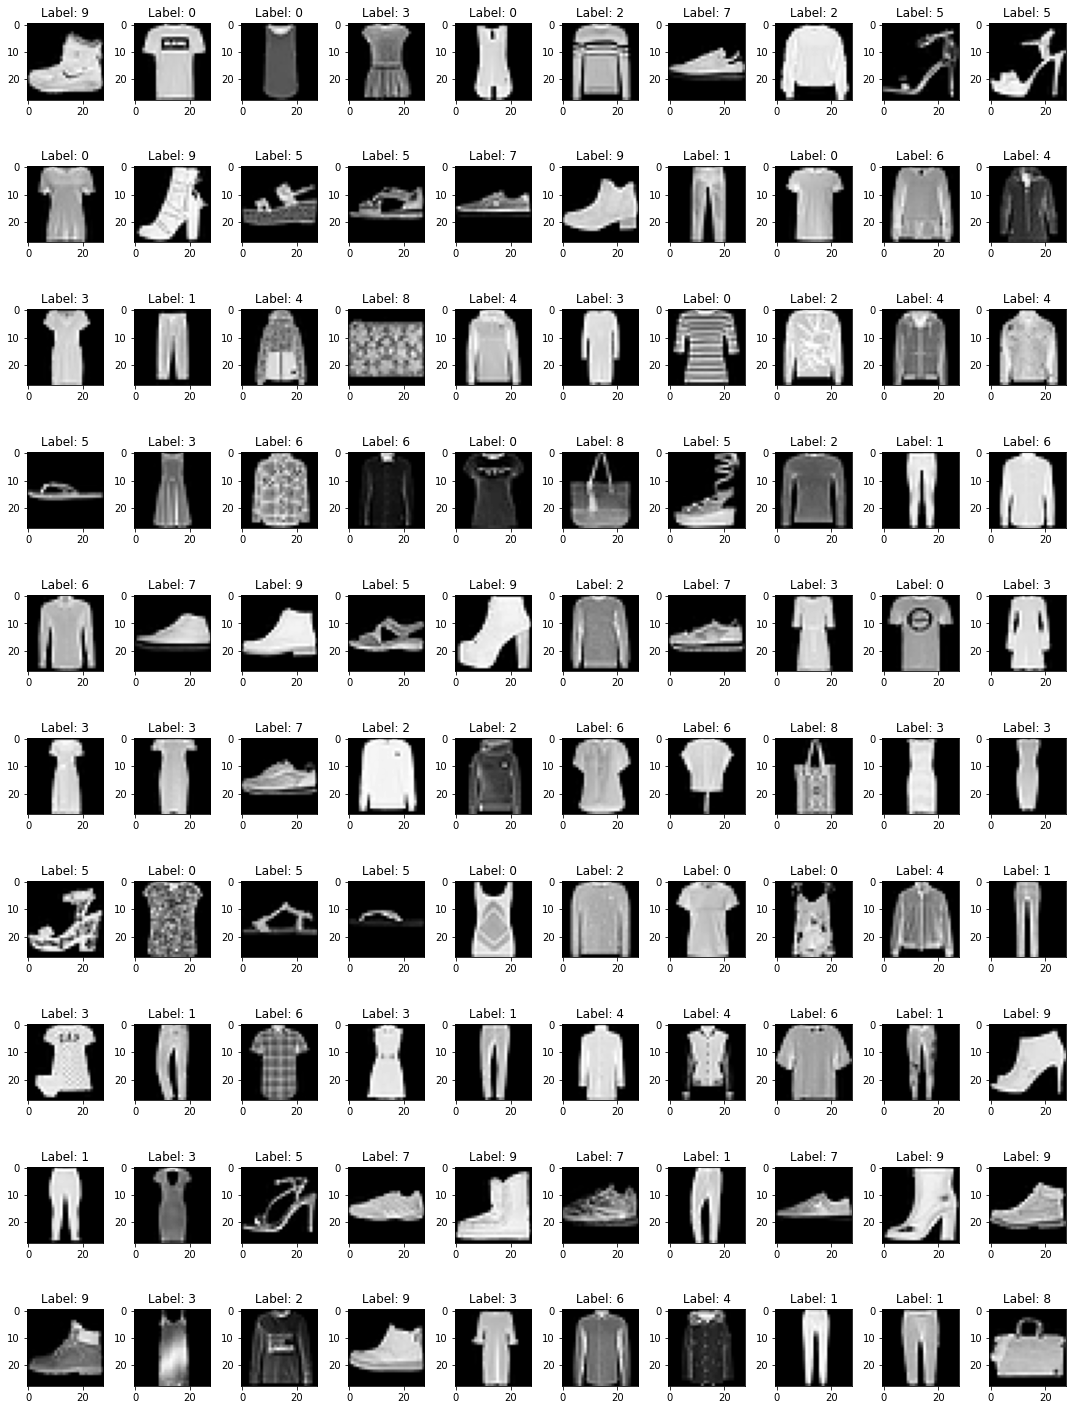

In [28]:
# specify the number of rows and columns you want to see
num_row = 10
num_col = 10

# get a segment of the dataset
num = num_row*num_col
images_eda = X_train_eda[:num]
labels_eda = Y_train_eda[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images_eda[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels_eda[i]))
plt.tight_layout()
plt.show()

Let's create a graph to display the number of observations that correspond to each of our 10 categories (as outlined below).

| Label In MNIST Fashion Dataset | Description 
| --- | --- |
| 0 | T-Shirt Or Top |
| 1 | Trousers |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal|
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

In [33]:
print(type(Y_train_eda))

<class 'numpy.ndarray'>


In [36]:
unique_eda, counts_eda = np.unique(Y_train_eda, return_counts=True)

dict_of_counts = dict(zip(unique_eda, counts_eda))


In [40]:
import pandas as pd

df_counts = pd.DataFrame(list(dict_of_counts.items()), columns=['MNIST Dataset Label', 'Count of Observations'])
df_counts

,MNIST Dataset Label,Count of Observations
0,0,6000
1,1,6000
2,2,6000
3,3,6000
4,4,6000
5,5,6000
6,6,6000
7,7,6000
8,8,6000
9,9,6000


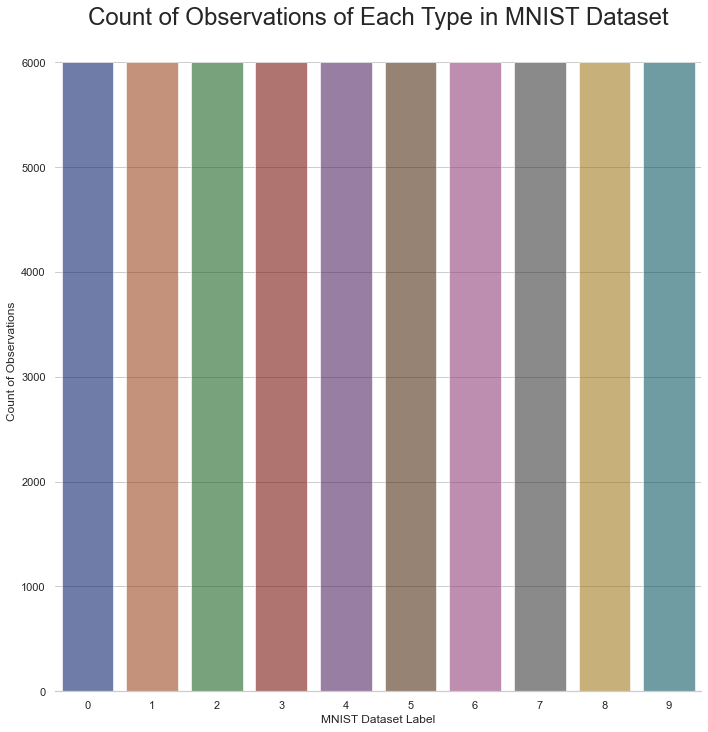

In [48]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_counts, kind="bar",
    x="MNIST Dataset Label", y="Count of Observations", 
    palette="dark", alpha=.6, height=10
)
g.despine(left=True)
sns.set(font_scale=2.0)
g.set_axis_labels("MNIST Dataset Label", "Count of Observations")
g.set(title='Count of Observations of Each Type in MNIST Dataset')

## 2) Model 1 - First AC-GAN Model

## 2.1) Create the Model

In [2]:
!pip install pydot


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# example of defining the discriminator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 32)   320         ['input_9[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_16[0][0]']              
                                                                                                  
 dropout_16 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_16[0][0]']         
                                                                                            

In [10]:
# example of defining the generator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 18816)        1900416     ['input_11[0][0]']               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_10[0][0]']               
                                                                                            

In [11]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 247ms/step
>1, dr[0.497,3.104], df[1.586,2.983], g[0.505,3.093]
1/1 [==============================] - 0s 138ms/step
>2, dr[0.418,2.847], df[1.411,3.368], g[0.856,3.244]
1/1 [==============================] - 0s 137ms/step
>3, dr[0.746,2.975], df[1.035,3.395], g[0.867,3.275]
1/1 [==============================] - 0s 105ms/step
>4, dr[0.615,3.115], df[0.806,2.889], g[0.850,3.403]
1/1 [==============================] - 0s 99ms/step
>5, dr[0.825,3.034], df[0.971,2.724], g[1.119,3.434]
1/1 [==============================] - 0s 97ms/step
>6, dr[0.614,2.641], df[0.868,3.382], g[1.119,3.095]
1/1 [==============================] - 0s 129ms/step
>7, dr[0.709,2.766], df[0.661,3.220], g[1.075,2.810]
1/1 [==============================] - 0s 124ms/step
>8, dr[0.498,2.774], df[0.640,3.229], g[1.388,3.031]
1/1 [==============================] - 0s 101ms/step
>9, dr[0.439,2.467], df[0.533,3.058], g[1.107,3.179]
1/1 [===============

1/1 [==============================] - 0s 115ms/step
>78, dr[0.131,1.329], df[0.089,3.226], g[0.131,2.878]
1/1 [==============================] - 0s 123ms/step
>79, dr[0.102,1.370], df[0.097,2.905], g[0.111,3.153]
1/1 [==============================] - 0s 137ms/step
>80, dr[0.240,1.448], df[0.027,3.276], g[0.084,3.153]
1/1 [==============================] - 0s 115ms/step
>81, dr[0.148,1.432], df[0.105,3.146], g[0.064,3.073]
1/1 [==============================] - 0s 95ms/step
>82, dr[0.139,0.915], df[0.152,2.922], g[0.045,2.580]
1/1 [==============================] - 0s 120ms/step
>83, dr[0.049,1.152], df[0.197,2.776], g[0.140,2.825]
1/1 [==============================] - 0s 92ms/step
>84, dr[0.319,1.520], df[0.114,2.715], g[0.062,2.869]
1/1 [==============================] - 0s 93ms/step
>85, dr[0.054,1.355], df[0.094,3.192], g[0.095,3.191]
1/1 [==============================] - 0s 95ms/step
>86, dr[0.124,1.076], df[0.088,3.624], g[0.067,3.135]
1/1 [==============================] - 0s

>154, dr[0.246,1.208], df[0.588,0.603], g[0.131,0.639]
1/1 [==============================] - 0s 145ms/step
>155, dr[0.244,0.624], df[0.076,0.729], g[0.140,0.720]
1/1 [==============================] - 0s 99ms/step
>156, dr[0.084,1.062], df[0.090,0.780], g[0.043,0.707]
1/1 [==============================] - 0s 92ms/step
>157, dr[0.221,1.016], df[0.280,0.780], g[0.049,0.493]
1/1 [==============================] - 0s 124ms/step
>158, dr[0.144,0.930], df[0.067,0.803], g[0.055,0.624]
1/1 [==============================] - 0s 105ms/step
>159, dr[0.099,1.485], df[0.158,0.535], g[0.098,0.548]
1/1 [==============================] - 0s 93ms/step
>160, dr[0.118,1.679], df[0.144,0.704], g[0.082,0.433]
1/1 [==============================] - 0s 119ms/step
>161, dr[0.112,1.040], df[0.105,0.612], g[0.116,0.314]
1/1 [==============================] - 0s 98ms/step
>162, dr[0.157,0.901], df[0.043,0.803], g[0.053,0.522]
1/1 [==============================] - 0s 93ms/step
>163, dr[0.215,1.233], df[0.193,0

1/1 [==============================] - 0s 79ms/step
>231, dr[0.059,0.813], df[0.027,0.216], g[0.245,0.148]
1/1 [==============================] - 0s 132ms/step
>232, dr[0.032,0.878], df[0.063,0.214], g[0.173,0.131]
1/1 [==============================] - 0s 102ms/step
>233, dr[0.032,1.087], df[0.072,0.220], g[0.163,0.191]
1/1 [==============================] - 0s 96ms/step
>234, dr[0.035,0.828], df[0.029,0.155], g[0.165,0.285]
1/1 [==============================] - 0s 89ms/step
>235, dr[0.036,0.680], df[0.047,0.146], g[0.180,0.150]
1/1 [==============================] - 0s 103ms/step
>236, dr[0.076,1.264], df[0.053,0.229], g[0.062,0.198]
1/1 [==============================] - 0s 87ms/step
>237, dr[0.032,1.183], df[0.148,0.129], g[0.345,0.169]
1/1 [==============================] - 0s 132ms/step
>238, dr[0.104,0.679], df[0.093,0.144], g[0.340,0.248]
1/1 [==============================] - 0s 86ms/step
>239, dr[0.050,0.642], df[0.221,0.254], g[0.580,0.228]
1/1 [============================

1/1 [==============================] - 0s 98ms/step
>307, dr[0.257,0.838], df[0.086,0.056], g[0.529,0.195]
1/1 [==============================] - 0s 94ms/step
>308, dr[0.930,0.542], df[0.750,0.035], g[0.392,0.076]
1/1 [==============================] - 0s 95ms/step
>309, dr[0.380,0.567], df[0.744,0.050], g[2.219,0.239]
1/1 [==============================] - 0s 94ms/step
>310, dr[1.433,1.016], df[1.457,0.045], g[2.973,0.302]
1/1 [==============================] - 0s 96ms/step
>311, dr[1.292,0.887], df[0.454,0.241], g[0.865,0.164]
1/1 [==============================] - 0s 86ms/step
>312, dr[1.079,0.971], df[1.650,0.099], g[0.549,0.099]
1/1 [==============================] - 0s 97ms/step
>313, dr[0.283,0.684], df[0.318,0.090], g[0.900,0.114]
1/1 [==============================] - 0s 92ms/step
>314, dr[0.622,0.676], df[0.316,0.040], g[0.333,0.164]
1/1 [==============================] - 0s 97ms/step
>315, dr[0.303,0.927], df[0.741,0.156], g[0.639,0.104]
1/1 [==============================] 

1/1 [==============================] - 0s 128ms/step
>383, dr[0.444,0.564], df[0.156,0.061], g[1.092,0.135]
1/1 [==============================] - 0s 95ms/step
>384, dr[0.550,0.546], df[0.502,0.077], g[0.782,0.293]
1/1 [==============================] - 0s 103ms/step
>385, dr[0.377,1.057], df[0.594,0.048], g[1.383,0.116]
1/1 [==============================] - 0s 100ms/step
>386, dr[0.401,0.678], df[0.317,0.099], g[1.737,0.138]
1/1 [==============================] - 0s 87ms/step
>387, dr[0.630,0.806], df[0.664,0.097], g[1.862,0.102]
1/1 [==============================] - 0s 91ms/step
>388, dr[0.461,0.805], df[0.301,0.083], g[1.529,0.107]
1/1 [==============================] - 0s 90ms/step
>389, dr[0.601,0.874], df[0.736,0.053], g[1.782,0.100]
1/1 [==============================] - 0s 95ms/step
>390, dr[0.387,0.790], df[0.485,0.078], g[2.031,0.205]
1/1 [==============================] - 0s 97ms/step
>391, dr[0.433,0.568], df[0.233,0.103], g[2.002,0.115]
1/1 [=============================

1/1 [==============================] - 0s 130ms/step
>459, dr[0.255,1.349], df[0.779,0.299], g[3.563,0.172]
1/1 [==============================] - 0s 84ms/step
>460, dr[0.546,0.729], df[0.179,0.232], g[2.929,0.180]
1/1 [==============================] - 0s 98ms/step
>461, dr[0.493,0.388], df[0.292,0.171], g[2.492,0.213]
1/1 [==============================] - 0s 85ms/step
>462, dr[0.483,1.005], df[0.531,0.486], g[2.041,0.186]
1/1 [==============================] - 0s 98ms/step
>463, dr[0.365,1.062], df[0.148,0.394], g[2.215,0.124]
1/1 [==============================] - 0s 118ms/step
>464, dr[0.789,1.109], df[0.300,0.509], g[1.490,0.145]
1/1 [==============================] - 0s 105ms/step
>465, dr[0.210,0.615], df[0.303,0.293], g[1.273,0.141]
1/1 [==============================] - 0s 94ms/step
>466, dr[0.270,0.387], df[0.172,0.167], g[1.358,0.131]
1/1 [==============================] - 0s 101ms/step
>467, dr[0.331,0.772], df[0.414,0.106], g[1.264,0.095]
1/1 [============================

1/1 [==============================] - 0s 105ms/step
>535, dr[0.498,0.963], df[0.293,0.210], g[1.903,0.191]
1/1 [==============================] - 0s 108ms/step
>536, dr[0.592,0.358], df[0.696,0.057], g[1.884,0.169]
1/1 [==============================] - 0s 109ms/step
>537, dr[0.618,0.949], df[0.575,0.219], g[2.160,0.138]
1/1 [==============================] - 0s 119ms/step
>538, dr[0.600,0.625], df[0.273,0.038], g[2.521,0.127]
1/1 [==============================] - 0s 111ms/step
>539, dr[0.496,0.702], df[0.362,0.023], g[2.340,0.199]
1/1 [==============================] - 0s 96ms/step
>540, dr[0.405,0.987], df[0.415,0.118], g[2.400,0.173]
1/1 [==============================] - 0s 112ms/step
>541, dr[0.426,0.668], df[0.298,0.195], g[1.902,0.195]
1/1 [==============================] - 0s 90ms/step
>542, dr[0.324,0.687], df[0.333,0.228], g[2.354,0.085]
1/1 [==============================] - 0s 113ms/step
>543, dr[0.372,0.997], df[0.469,0.114], g[2.396,0.174]
1/1 [=========================

1/1 [==============================] - 0s 100ms/step
>611, dr[0.464,0.592], df[0.399,0.130], g[0.762,0.127]
1/1 [==============================] - 0s 145ms/step
>612, dr[0.511,1.249], df[0.178,0.055], g[0.684,0.138]
1/1 [==============================] - 0s 98ms/step
>613, dr[0.459,0.979], df[0.440,0.196], g[0.708,0.109]
1/1 [==============================] - 0s 181ms/step
>614, dr[0.354,0.894], df[0.362,0.151], g[1.068,0.142]
1/1 [==============================] - 0s 108ms/step
>615, dr[0.479,1.746], df[0.256,0.105], g[1.008,0.177]
1/1 [==============================] - 0s 123ms/step
>616, dr[0.582,1.093], df[0.397,0.058], g[1.072,0.117]
1/1 [==============================] - 0s 154ms/step
>617, dr[0.277,0.643], df[0.314,0.060], g[1.870,0.132]
1/1 [==============================] - 0s 105ms/step
>618, dr[0.443,1.462], df[0.104,0.061], g[1.939,0.162]
1/1 [==============================] - 0s 95ms/step
>619, dr[0.449,1.204], df[0.407,0.154], g[1.840,0.246]
1/1 [=========================

1/1 [==============================] - 0s 101ms/step
>687, dr[0.092,0.887], df[0.174,0.104], g[2.651,0.199]
1/1 [==============================] - 0s 91ms/step
>688, dr[0.193,0.791], df[0.124,0.074], g[3.238,0.102]
1/1 [==============================] - 0s 94ms/step
>689, dr[0.240,0.446], df[0.121,0.185], g[2.817,0.220]
1/1 [==============================] - 0s 117ms/step
>690, dr[0.090,0.791], df[0.073,0.159], g[3.112,0.147]
1/1 [==============================] - 0s 97ms/step
>691, dr[0.149,0.879], df[0.202,0.030], g[3.157,0.125]
1/1 [==============================] - 0s 92ms/step
>692, dr[0.142,1.365], df[0.125,0.106], g[2.733,0.133]
1/1 [==============================] - 0s 117ms/step
>693, dr[0.382,1.013], df[0.398,0.086], g[2.920,0.146]
1/1 [==============================] - 0s 93ms/step
>694, dr[0.283,1.362], df[0.242,0.240], g[3.370,0.118]
1/1 [==============================] - 0s 98ms/step
>695, dr[0.165,0.760], df[0.214,0.236], g[3.725,0.156]
1/1 [=============================

1/1 [==============================] - 0s 116ms/step
>763, dr[0.175,0.908], df[0.347,0.180], g[2.594,0.026]
1/1 [==============================] - 0s 128ms/step
>764, dr[0.458,0.723], df[0.199,0.084], g[2.430,0.127]
1/1 [==============================] - 0s 95ms/step
>765, dr[0.474,1.412], df[0.394,0.029], g[2.212,0.108]
1/1 [==============================] - 0s 104ms/step
>766, dr[0.262,0.846], df[0.404,0.049], g[2.574,0.077]
1/1 [==============================] - 0s 89ms/step
>767, dr[0.446,1.015], df[0.161,0.047], g[2.310,0.105]
1/1 [==============================] - 0s 162ms/step
>768, dr[0.127,0.284], df[0.335,0.045], g[2.571,0.055]
1/1 [==============================] - 0s 88ms/step
>769, dr[0.194,0.810], df[0.178,0.021], g[3.189,0.073]
1/1 [==============================] - 0s 99ms/step
>770, dr[0.146,0.403], df[0.207,0.069], g[3.059,0.141]
1/1 [==============================] - 0s 92ms/step
>771, dr[0.523,1.172], df[0.233,0.062], g[2.034,0.132]
1/1 [============================

1/1 [==============================] - 0s 104ms/step
>839, dr[0.386,1.005], df[0.218,0.042], g[2.075,0.039]
1/1 [==============================] - 0s 116ms/step
>840, dr[0.309,0.646], df[0.238,0.042], g[2.201,0.042]
1/1 [==============================] - 0s 109ms/step
>841, dr[0.251,0.626], df[0.568,0.025], g[2.504,0.070]
1/1 [==============================] - 0s 125ms/step
>842, dr[0.477,0.807], df[0.484,0.026], g[2.073,0.038]
1/1 [==============================] - 0s 104ms/step
>843, dr[0.380,0.480], df[0.298,0.081], g[2.332,0.087]
1/1 [==============================] - 0s 117ms/step
>844, dr[0.370,0.758], df[0.410,0.075], g[2.075,0.062]
1/1 [==============================] - 0s 128ms/step
>845, dr[0.525,0.824], df[0.441,0.048], g[2.393,0.050]
1/1 [==============================] - 0s 107ms/step
>846, dr[0.710,0.840], df[0.336,0.056], g[1.378,0.036]
1/1 [==============================] - 0s 95ms/step
>847, dr[0.224,0.604], df[0.688,0.151], g[2.101,0.078]
1/1 [========================

1/1 [==============================] - 0s 98ms/step
>915, dr[0.186,0.938], df[0.340,0.053], g[1.863,0.141]
1/1 [==============================] - 0s 98ms/step
>916, dr[0.636,0.640], df[0.240,0.060], g[1.698,0.134]
1/1 [==============================] - 0s 88ms/step
>917, dr[0.431,0.712], df[0.230,0.105], g[1.524,0.085]
1/1 [==============================] - 0s 113ms/step
>918, dr[0.153,0.391], df[1.008,0.046], g[3.816,0.060]
1/1 [==============================] - 0s 142ms/step
>919, dr[0.620,0.689], df[0.045,0.056], g[2.685,0.043]
1/1 [==============================] - 0s 119ms/step
>920, dr[0.495,0.812], df[0.348,0.094], g[2.531,0.095]
1/1 [==============================] - 0s 97ms/step
>921, dr[0.278,0.516], df[0.303,0.034], g[1.629,0.050]
1/1 [==============================] - 0s 91ms/step
>922, dr[0.188,0.361], df[0.368,0.077], g[1.368,0.107]
1/1 [==============================] - 0s 100ms/step
>923, dr[0.343,0.828], df[0.324,0.041], g[2.109,0.036]
1/1 [============================

## 2.2) Evaluate Model Performance

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_0937.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 54ms/step
(3000, 28, 28, 1)


In [6]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 15s 2s/step
score 1.1270496 0.002707503


## 3) Model 2 - AC-GAN with 200-Dimensional Latent Space

### 3.1) Build The Model

Let's construct and train the AC-GAN model. For this model, we will try to improve performance by modifying the first model by having a 200-dimensional latent space instead of a 100-dimensional latent space.

In [11]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 200
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 215ms/step
>1, dr[0.954,3.227], df[1.220,2.911], g[0.850,3.034]
1/1 [==============================] - 0s 93ms/step
>2, dr[0.634,2.991], df[1.203,3.373], g[0.820,3.339]
1/1 [==============================] - 0s 93ms/step
>3, dr[0.562,3.365], df[0.779,2.931], g[1.056,3.061]
1/1 [==============================] - 0s 69ms/step
>4, dr[0.547,2.710], df[0.736,2.713], g[1.054,3.428]
1/1 [==============================] - 0s 85ms/step
>5, dr[0.816,2.661], df[0.675,3.024], g[1.008,3.156]
1/1 [==============================] - 0s 75ms/step
>6, dr[0.529,2.709], df[0.809,2.823], g[1.118,3.045]
1/1 [==============================] - 0s 80ms/step
>7, dr[0.457,2.955], df[0.421,3.245], g[1.467,2.902]
1/1 [==============================] - 0s 69ms/step
>8, dr[0.736,2.612], df[0.760,3.277], g[1.192,3.286]
1/1 [==============================] - 0s 76ms/step
>9, dr[0.483,2.815], df[0.731,2.885], g[1.349,3.526]
1/1 [=====================

1/1 [==============================] - 0s 80ms/step
>78, dr[0.043,1.058], df[0.150,3.365], g[0.122,3.030]
1/1 [==============================] - 0s 75ms/step
>79, dr[0.068,1.386], df[0.085,2.745], g[0.138,2.916]
1/1 [==============================] - 0s 80ms/step
>80, dr[0.105,0.846], df[0.050,2.686], g[0.084,3.148]
1/1 [==============================] - 0s 80ms/step
>81, dr[0.095,1.315], df[0.072,3.055], g[0.068,3.072]
1/1 [==============================] - 0s 88ms/step
>82, dr[0.104,1.009], df[0.158,3.105], g[0.062,2.909]
1/1 [==============================] - 0s 76ms/step
>83, dr[0.263,1.232], df[0.199,2.557], g[0.118,3.173]
1/1 [==============================] - 0s 74ms/step
>84, dr[0.055,1.441], df[0.097,2.869], g[0.083,2.659]
1/1 [==============================] - 0s 74ms/step
>85, dr[0.101,1.336], df[0.227,3.067], g[0.159,2.862]
1/1 [==============================] - 0s 85ms/step
>86, dr[0.203,1.255], df[0.213,2.998], g[0.219,2.649]
1/1 [==============================] - 0s 88ms

1/1 [==============================] - 0s 79ms/step
>155, dr[0.048,0.817], df[0.168,1.008], g[0.141,0.801]
1/1 [==============================] - 0s 69ms/step
>156, dr[0.168,1.129], df[0.093,0.953], g[0.089,0.837]
1/1 [==============================] - 0s 71ms/step
>157, dr[0.157,0.682], df[0.134,0.848], g[0.124,0.887]
1/1 [==============================] - 0s 71ms/step
>158, dr[0.124,0.710], df[0.235,0.611], g[0.254,0.793]
1/1 [==============================] - 0s 70ms/step
>159, dr[0.193,0.961], df[0.072,0.817], g[0.277,1.042]
1/1 [==============================] - 0s 78ms/step
>160, dr[0.209,0.735], df[0.061,0.898], g[0.100,0.675]
1/1 [==============================] - 0s 75ms/step
>161, dr[0.121,0.899], df[0.128,0.736], g[0.119,0.799]
1/1 [==============================] - 0s 74ms/step
>162, dr[0.104,1.252], df[0.067,0.821], g[0.080,0.734]
1/1 [==============================] - 0s 71ms/step
>163, dr[0.109,1.382], df[0.120,1.026], g[0.060,0.812]
1/1 [==============================] 

1/1 [==============================] - 0s 94ms/step
>232, dr[0.077,0.827], df[0.236,0.313], g[1.248,0.260]
1/1 [==============================] - 0s 75ms/step
>233, dr[0.168,0.845], df[0.108,0.328], g[1.086,0.393]
1/1 [==============================] - 0s 80ms/step
>234, dr[0.145,1.032], df[0.090,0.199], g[0.477,0.250]
1/1 [==============================] - 0s 80ms/step
>235, dr[0.248,0.713], df[0.606,0.266], g[1.032,0.283]
1/1 [==============================] - 0s 81ms/step
>236, dr[0.298,0.594], df[0.055,0.163], g[0.598,0.173]
1/1 [==============================] - 0s 78ms/step
>237, dr[0.114,0.446], df[0.277,0.216], g[0.575,0.243]
1/1 [==============================] - 0s 74ms/step
>238, dr[0.297,0.929], df[0.205,0.305], g[0.526,0.270]
1/1 [==============================] - 0s 96ms/step
>239, dr[0.105,0.798], df[0.107,0.222], g[0.688,0.233]
1/1 [==============================] - 0s 79ms/step
>240, dr[0.417,0.848], df[1.017,0.143], g[2.998,0.275]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>309, dr[0.327,0.442], df[0.256,0.176], g[1.182,0.125]
1/1 [==============================] - 0s 73ms/step
>310, dr[0.393,1.007], df[0.303,0.198], g[0.972,0.054]
1/1 [==============================] - 0s 76ms/step
>311, dr[0.198,0.677], df[0.527,0.108], g[1.625,0.253]
1/1 [==============================] - 0s 77ms/step
>312, dr[0.498,1.056], df[0.314,0.129], g[1.257,0.204]
1/1 [==============================] - 0s 78ms/step
>313, dr[0.789,1.457], df[1.062,0.173], g[1.432,0.172]
1/1 [==============================] - 0s 70ms/step
>314, dr[0.504,0.926], df[0.257,0.188], g[1.287,0.377]
1/1 [==============================] - 0s 72ms/step
>315, dr[0.636,0.800], df[1.238,0.074], g[1.979,0.197]
1/1 [==============================] - 0s 69ms/step
>316, dr[0.646,0.998], df[0.355,0.054], g[1.895,0.214]
1/1 [==============================] - 0s 69ms/step
>317, dr[1.119,0.915], df[0.987,0.249], g[2.343,0.230]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>386, dr[0.474,0.572], df[0.405,0.242], g[2.538,0.227]
1/1 [==============================] - 0s 79ms/step
>387, dr[0.431,0.631], df[0.690,0.129], g[2.626,0.196]
1/1 [==============================] - 0s 82ms/step
>388, dr[1.046,1.005], df[0.625,0.095], g[2.039,0.098]
1/1 [==============================] - 0s 74ms/step
>389, dr[0.302,0.963], df[0.645,0.055], g[2.243,0.052]
1/1 [==============================] - 0s 70ms/step
>390, dr[0.475,0.872], df[0.191,0.063], g[2.486,0.051]
1/1 [==============================] - 0s 68ms/step
>391, dr[0.556,0.907], df[0.633,0.135], g[1.618,0.063]
1/1 [==============================] - 0s 72ms/step
>392, dr[0.367,0.637], df[0.435,0.062], g[2.065,0.114]
1/1 [==============================] - 0s 67ms/step
>393, dr[0.634,1.283], df[0.356,0.240], g[1.907,0.104]
1/1 [==============================] - 0s 87ms/step
>394, dr[0.633,0.539], df[0.547,0.279], g[2.296,0.109]
1/1 [==============================] 

>462, dr[0.178,0.648], df[0.247,0.104], g[2.332,0.057]
1/1 [==============================] - 0s 73ms/step
>463, dr[0.901,1.079], df[0.633,0.080], g[1.845,0.089]
1/1 [==============================] - 0s 80ms/step
>464, dr[0.186,0.681], df[0.734,0.100], g[2.606,0.150]
1/1 [==============================] - 0s 83ms/step
>465, dr[0.427,0.813], df[0.758,0.190], g[2.868,0.142]
1/1 [==============================] - 0s 74ms/step
>466, dr[0.984,0.720], df[0.714,0.326], g[2.332,0.069]
1/1 [==============================] - 0s 70ms/step
>467, dr[0.588,1.021], df[1.041,0.434], g[2.370,0.081]
1/1 [==============================] - 0s 71ms/step
>468, dr[0.674,0.770], df[0.784,0.087], g[2.879,0.088]
1/1 [==============================] - 0s 77ms/step
>469, dr[0.430,0.472], df[0.336,0.211], g[3.076,0.145]
1/1 [==============================] - 0s 94ms/step
>470, dr[0.316,0.666], df[0.380,0.118], g[2.720,0.214]
1/1 [==============================] - 0s 86ms/step
>471, dr[0.372,1.270], df[0.708,0.105

1/1 [==============================] - 0s 70ms/step
>539, dr[0.284,0.441], df[0.722,0.196], g[2.124,0.263]
1/1 [==============================] - 0s 72ms/step
>540, dr[0.913,1.084], df[0.268,0.073], g[1.628,0.107]
1/1 [==============================] - 0s 74ms/step
>541, dr[0.402,0.954], df[0.542,0.442], g[1.880,0.204]
1/1 [==============================] - 0s 81ms/step
>542, dr[0.351,1.126], df[0.285,0.223], g[2.281,0.168]
1/1 [==============================] - 0s 84ms/step
>543, dr[0.443,0.454], df[0.479,0.161], g[2.854,0.288]
1/1 [==============================] - 0s 80ms/step
>544, dr[0.605,0.918], df[0.184,0.388], g[2.300,0.156]
1/1 [==============================] - 0s 72ms/step
>545, dr[0.291,0.479], df[0.300,0.109], g[2.145,0.209]
1/1 [==============================] - 0s 76ms/step
>546, dr[0.426,0.703], df[0.410,0.252], g[2.881,0.187]
1/1 [==============================] - 0s 70ms/step
>547, dr[0.468,0.569], df[0.446,0.119], g[3.092,0.195]
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step
>616, dr[0.164,1.371], df[0.302,0.127], g[2.915,0.157]
1/1 [==============================] - 0s 69ms/step
>617, dr[0.246,0.603], df[0.284,0.070], g[3.498,0.080]
1/1 [==============================] - 0s 66ms/step
>618, dr[0.714,0.935], df[0.234,0.077], g[2.375,0.063]
1/1 [==============================] - 0s 72ms/step
>619, dr[0.231,0.555], df[0.474,0.096], g[3.435,0.121]
1/1 [==============================] - 0s 75ms/step
>620, dr[0.368,0.793], df[0.304,0.109], g[3.261,0.115]
1/1 [==============================] - 0s 71ms/step
>621, dr[0.405,1.295], df[0.188,0.212], g[3.606,0.283]
1/1 [==============================] - 0s 80ms/step
>622, dr[0.444,0.691], df[0.274,0.079], g[2.422,0.122]
1/1 [==============================] - 0s 69ms/step
>623, dr[0.153,0.569], df[0.290,0.109], g[2.520,0.200]
1/1 [==============================] - 0s 78ms/step
>624, dr[0.247,1.034], df[0.317,0.292], g[3.179,0.100]
1/1 [==============================] 

1/1 [==============================] - 0s 85ms/step
>693, dr[0.312,0.793], df[0.306,0.020], g[2.237,0.224]
1/1 [==============================] - 0s 74ms/step
>694, dr[0.273,0.892], df[0.219,0.116], g[1.916,0.192]
1/1 [==============================] - 0s 80ms/step
>695, dr[0.403,0.618], df[0.372,0.212], g[2.339,0.248]
1/1 [==============================] - 0s 77ms/step
>696, dr[0.364,0.665], df[0.125,0.157], g[1.558,0.347]
1/1 [==============================] - 0s 76ms/step
>697, dr[0.655,0.666], df[0.702,0.327], g[2.016,0.244]
1/1 [==============================] - 0s 85ms/step
>698, dr[0.217,1.130], df[0.255,0.110], g[2.347,0.187]
1/1 [==============================] - 0s 83ms/step
>699, dr[0.235,1.172], df[0.399,0.122], g[2.510,0.208]
1/1 [==============================] - 0s 82ms/step
>700, dr[0.471,0.419], df[0.271,0.038], g[1.526,0.118]
1/1 [==============================] - 0s 72ms/step
>701, dr[0.233,0.727], df[0.441,0.277], g[2.104,0.188]
1/1 [==============================] 

1/1 [==============================] - 0s 83ms/step
>770, dr[0.717,1.039], df[0.432,0.155], g[1.481,0.175]
1/1 [==============================] - 0s 81ms/step
>771, dr[0.649,0.440], df[0.659,0.132], g[2.286,0.170]
1/1 [==============================] - 0s 84ms/step
>772, dr[0.576,0.838], df[0.300,0.085], g[2.190,0.144]
1/1 [==============================] - 0s 73ms/step
>773, dr[0.197,0.830], df[0.249,0.116], g[2.307,0.155]
1/1 [==============================] - 0s 80ms/step
>774, dr[0.432,0.783], df[0.390,0.112], g[2.918,0.207]
1/1 [==============================] - 0s 91ms/step
>775, dr[0.527,1.425], df[0.155,0.215], g[1.911,0.151]
1/1 [==============================] - 0s 77ms/step
>776, dr[0.315,0.559], df[0.278,0.258], g[1.326,0.271]
1/1 [==============================] - 0s 88ms/step
>777, dr[0.064,0.708], df[0.281,0.057], g[2.321,0.236]
1/1 [==============================] - 0s 86ms/step
>778, dr[0.215,0.706], df[0.144,0.244], g[2.883,0.207]
1/1 [==============================] 

>846, dr[0.097,0.935], df[0.037,0.033], g[2.757,0.238]
1/1 [==============================] - 0s 105ms/step
>847, dr[0.023,1.027], df[0.060,0.103], g[2.672,0.072]
1/1 [==============================] - 0s 118ms/step
>848, dr[0.109,0.637], df[0.059,0.030], g[2.603,0.055]
1/1 [==============================] - 0s 90ms/step
>849, dr[0.015,0.805], df[0.061,0.060], g[3.256,0.047]
1/1 [==============================] - 0s 91ms/step
>850, dr[0.031,1.011], df[0.024,0.065], g[3.114,0.077]
1/1 [==============================] - 0s 81ms/step
>851, dr[0.026,0.662], df[0.107,0.165], g[3.186,0.032]
1/1 [==============================] - 0s 78ms/step
>852, dr[0.022,0.733], df[0.036,0.093], g[3.552,0.062]
1/1 [==============================] - 0s 82ms/step
>853, dr[0.032,0.490], df[0.019,0.046], g[2.921,0.048]
1/1 [==============================] - 0s 87ms/step
>854, dr[0.037,0.493], df[0.027,0.081], g[2.701,0.088]
1/1 [==============================] - 0s 80ms/step
>855, dr[0.084,0.858], df[0.020,0.1

1/1 [==============================] - 0s 78ms/step
>923, dr[0.393,0.553], df[0.340,0.106], g[2.021,0.169]
1/1 [==============================] - 0s 99ms/step
>924, dr[0.213,0.933], df[0.169,0.105], g[3.127,0.072]
1/1 [==============================] - 0s 105ms/step
>925, dr[0.213,0.708], df[0.114,0.089], g[2.544,0.079]
1/1 [==============================] - 0s 83ms/step
>926, dr[0.295,0.693], df[0.333,0.090], g[2.071,0.091]
1/1 [==============================] - 0s 82ms/step
>927, dr[0.278,0.591], df[0.274,0.059], g[2.631,0.078]
1/1 [==============================] - 0s 91ms/step
>928, dr[0.237,0.237], df[0.179,0.083], g[2.507,0.084]
1/1 [==============================] - 0s 91ms/step
>929, dr[0.413,0.784], df[0.204,0.056], g[2.509,0.065]
1/1 [==============================] - 0s 90ms/step
>930, dr[0.101,0.495], df[0.666,0.042], g[3.549,0.096]
1/1 [==============================] - 0s 98ms/step
>931, dr[0.353,0.698], df[0.159,0.025], g[3.415,0.063]
1/1 [==============================]

In [16]:
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_192 (Conv2D)            (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 14, 14, 32)   0           ['conv2d_192[0][0]']             
                                                                                                  
 dropout_4 (Dropout)            (None, 14, 14, 32)   0           ['leaky_re_lu_4[0][0]']          
                                                                                            

In [15]:
generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 18816)        3782016     ['input_8[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_7[0][0]']                
                                                                                            

## 3.2) Evaluate Model Performance

Let's generate fake images of clothes that can be used to calculate the inception scores

In [17]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_0937.h5')
latent_dim = 200
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 59ms/step
(3000, 28, 28, 1)


Let's calculate the inception score

In [18]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 15s 1s/step
score 1.1502178 0.0031078113


# 4) Model 3 - Increased Number of Epochs

## 4.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 184ms/step
>1, dr[0.910,2.330], df[1.358,3.024], g[0.735,3.081]
1/1 [==============================] - 0s 71ms/step
>2, dr[0.492,3.007], df[1.164,3.010], g[0.978,3.280]
1/1 [==============================] - 0s 74ms/step
>3, dr[0.810,3.164], df[0.937,2.860], g[1.117,2.933]
1/1 [==============================] - 0s 88ms/step
>4, dr[0.736,2.396], df[0.593,3.451], g[1.163,3.178]
1/1 [==============================] - 0s 73ms/step
>5, dr[0.663,2.821], df[0.758,3.011], g[1.049,2.984]
1/1 [==============================] - 0s 80ms/step
>6, dr[0.555,2.854], df[0.571,3.249], g[1.350,2.981]
1/1 [==============================] - 0s 85ms/step
>7, dr[0.505,2.397], df[0.599,2.899], g[1.182,2.927]
1/1 [==============================] - 0s 77ms/step
>8, dr[0.503,2.482], df[0.651,3.375], g[1.604,3.021]
1/1 [==============================] - 0s 66ms/step
>9, dr[0.521,2.463], df[0.841,2.813], g[1.592,2.734]
1/1 [=====================

1/1 [==============================] - 0s 83ms/step
>78, dr[0.070,1.100], df[0.094,3.098], g[0.032,3.169]
1/1 [==============================] - 0s 74ms/step
>79, dr[0.139,1.119], df[0.070,3.553], g[0.030,3.042]
1/1 [==============================] - 0s 92ms/step
>80, dr[0.059,1.591], df[0.038,2.958], g[0.045,3.133]
1/1 [==============================] - 0s 128ms/step
>81, dr[0.047,1.188], df[0.054,3.183], g[0.041,3.466]
1/1 [==============================] - 0s 100ms/step
>82, dr[0.054,1.032], df[0.070,3.557], g[0.057,3.034]
1/1 [==============================] - 0s 94ms/step
>83, dr[0.138,1.047], df[0.098,3.142], g[0.026,3.088]
1/1 [==============================] - 0s 78ms/step
>84, dr[0.142,1.480], df[0.080,2.650], g[0.058,2.805]
1/1 [==============================] - 0s 125ms/step
>85, dr[0.024,1.472], df[0.075,2.808], g[0.080,3.013]
1/1 [==============================] - 0s 85ms/step
>86, dr[0.151,1.457], df[0.042,3.319], g[0.036,2.780]
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 72ms/step
>155, dr[0.130,1.029], df[0.198,0.620], g[0.077,0.713]
1/1 [==============================] - 0s 71ms/step
>156, dr[0.090,1.069], df[0.048,0.405], g[0.078,0.659]
1/1 [==============================] - 0s 71ms/step
>157, dr[0.089,0.715], df[0.040,0.779], g[0.044,0.628]
1/1 [==============================] - 0s 65ms/step
>158, dr[0.071,0.849], df[0.125,0.571], g[0.094,0.498]
1/1 [==============================] - 0s 72ms/step
>159, dr[0.148,1.318], df[0.091,0.484], g[0.051,0.514]
1/1 [==============================] - 0s 64ms/step
>160, dr[0.107,1.055], df[0.035,0.619], g[0.050,0.646]
1/1 [==============================] - 0s 72ms/step
>161, dr[0.093,0.917], df[0.145,0.491], g[0.049,0.564]
1/1 [==============================] - 0s 67ms/step
>162, dr[0.045,1.032], df[0.041,0.380], g[0.063,0.564]
1/1 [==============================] - 0s 71ms/step
>163, dr[0.154,0.549], df[0.027,0.844], g[0.022,0.444]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>232, dr[0.030,0.862], df[0.015,0.192], g[0.066,0.148]
1/1 [==============================] - 0s 66ms/step
>233, dr[0.031,0.635], df[0.026,0.186], g[0.037,0.121]
1/1 [==============================] - 0s 74ms/step
>234, dr[0.151,0.648], df[0.031,0.232], g[0.021,0.110]
1/1 [==============================] - 0s 68ms/step
>235, dr[0.019,0.892], df[0.147,0.195], g[0.150,0.140]
1/1 [==============================] - 0s 77ms/step
>236, dr[0.091,0.514], df[0.012,0.090], g[0.110,0.100]
1/1 [==============================] - 0s 68ms/step
>237, dr[0.044,1.105], df[0.015,0.094], g[0.023,0.090]
1/1 [==============================] - 0s 80ms/step
>238, dr[0.051,0.671], df[0.122,0.146], g[0.087,0.189]
1/1 [==============================] - 0s 67ms/step
>239, dr[0.109,0.959], df[0.019,0.106], g[0.071,0.162]
1/1 [==============================] - 0s 73ms/step
>240, dr[0.091,0.649], df[0.065,0.129], g[0.063,0.141]
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step
>309, dr[0.704,1.186], df[0.754,0.764], g[1.312,0.081]
1/1 [==============================] - 0s 74ms/step
>310, dr[0.303,1.088], df[0.040,0.276], g[1.186,0.214]
1/1 [==============================] - 0s 72ms/step
>311, dr[0.842,1.057], df[1.343,0.215], g[1.088,0.131]
1/1 [==============================] - 0s 71ms/step
>312, dr[0.446,1.146], df[0.290,0.066], g[0.954,0.109]
1/1 [==============================] - 0s 78ms/step
>313, dr[0.763,0.843], df[0.915,0.121], g[0.647,0.116]
1/1 [==============================] - 0s 71ms/step
>314, dr[2.000,1.420], df[3.041,0.171], g[0.658,0.081]
1/1 [==============================] - 0s 80ms/step
>315, dr[0.417,0.436], df[0.816,0.097], g[2.188,0.135]
1/1 [==============================] - 0s 85ms/step
>316, dr[1.543,1.093], df[0.754,0.219], g[1.927,0.089]
1/1 [==============================] - 0s 74ms/step
>317, dr[1.061,0.745], df[0.632,0.105], g[1.400,0.164]
1/1 [==============================] 

1/1 [==============================] - 0s 75ms/step
>386, dr[0.557,1.138], df[0.421,0.070], g[1.712,0.080]
1/1 [==============================] - 0s 81ms/step
>387, dr[0.640,1.421], df[0.676,0.037], g[1.484,0.107]
1/1 [==============================] - 0s 80ms/step
>388, dr[0.432,1.223], df[0.430,0.133], g[1.843,0.090]
1/1 [==============================] - 0s 67ms/step
>389, dr[0.538,1.174], df[0.364,0.099], g[1.426,0.056]
1/1 [==============================] - 0s 72ms/step
>390, dr[0.489,0.560], df[0.582,0.034], g[1.254,0.072]
1/1 [==============================] - 0s 70ms/step
>391, dr[0.366,0.647], df[0.301,0.048], g[1.610,0.078]
1/1 [==============================] - 0s 82ms/step
>392, dr[0.618,0.725], df[0.580,0.065], g[1.294,0.082]
1/1 [==============================] - 0s 65ms/step
>393, dr[0.275,1.151], df[0.559,0.065], g[1.895,0.099]
1/1 [==============================] - 0s 79ms/step
>394, dr[0.516,1.072], df[0.320,0.071], g[1.366,0.133]
1/1 [==============================] 

1/1 [==============================] - 0s 65ms/step
>463, dr[0.322,0.441], df[0.550,0.068], g[2.265,0.104]
1/1 [==============================] - 0s 70ms/step
>464, dr[0.544,1.273], df[0.440,0.065], g[2.211,0.066]
1/1 [==============================] - 0s 66ms/step
>465, dr[0.659,0.822], df[0.511,0.046], g[2.118,0.087]
1/1 [==============================] - 0s 73ms/step
>466, dr[0.656,1.015], df[0.288,0.092], g[1.872,0.123]
1/1 [==============================] - 0s 70ms/step
>467, dr[0.315,0.458], df[0.550,0.048], g[2.239,0.096]
1/1 [==============================] - 0s 74ms/step
>468, dr[0.709,0.677], df[0.502,0.089], g[1.981,0.057]
1/1 [==============================] - 0s 68ms/step
>469, dr[0.459,0.722], df[0.558,0.034], g[2.081,0.043]
1/1 [==============================] - 0s 71ms/step
>470, dr[0.918,1.250], df[0.551,0.066], g[1.455,0.047]
1/1 [==============================] - 0s 66ms/step
>471, dr[0.194,0.931], df[0.487,0.027], g[2.429,0.034]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>540, dr[0.574,0.502], df[0.469,0.105], g[1.888,0.106]
1/1 [==============================] - 0s 80ms/step
>541, dr[0.641,0.708], df[0.579,0.213], g[1.719,0.125]
1/1 [==============================] - 0s 76ms/step
>542, dr[0.594,0.699], df[0.854,0.056], g[2.219,0.104]
1/1 [==============================] - 0s 70ms/step
>543, dr[0.757,0.461], df[0.391,0.101], g[2.652,0.109]
1/1 [==============================] - 0s 70ms/step
>544, dr[0.855,0.464], df[0.708,0.228], g[2.001,0.200]
1/1 [==============================] - 0s 74ms/step
>545, dr[0.259,0.452], df[0.410,0.106], g[2.462,0.068]
1/1 [==============================] - 0s 73ms/step
>546, dr[0.503,0.713], df[0.305,0.028], g[1.813,0.253]
1/1 [==============================] - 0s 76ms/step
>547, dr[0.346,1.147], df[0.599,0.422], g[2.298,0.230]
1/1 [==============================] - 0s 77ms/step
>548, dr[0.700,0.653], df[0.529,0.182], g[2.051,0.063]
1/1 [==============================] 

1/1 [==============================] - 0s 77ms/step
>617, dr[0.085,0.702], df[0.321,0.099], g[0.449,0.165]
1/1 [==============================] - 0s 72ms/step
>618, dr[0.188,0.951], df[1.276,0.064], g[0.898,0.063]
1/1 [==============================] - 0s 76ms/step
>619, dr[0.821,0.590], df[0.572,0.028], g[1.178,0.088]
1/1 [==============================] - 0s 75ms/step
>620, dr[2.003,1.146], df[1.577,0.260], g[2.670,0.069]
1/1 [==============================] - 0s 72ms/step
>621, dr[1.596,0.486], df[0.292,0.133], g[4.230,0.131]
1/1 [==============================] - 0s 75ms/step
>622, dr[0.401,0.712], df[0.255,0.119], g[3.902,0.069]
1/1 [==============================] - 0s 75ms/step
>623, dr[0.226,0.467], df[0.171,0.060], g[3.374,0.103]
1/1 [==============================] - 0s 66ms/step
>624, dr[0.221,0.762], df[0.317,0.098], g[2.568,0.094]
1/1 [==============================] - 0s 78ms/step
>625, dr[0.576,0.547], df[0.515,0.145], g[2.303,0.097]
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step
>694, dr[0.179,1.341], df[0.327,0.157], g[2.979,0.090]
1/1 [==============================] - 0s 68ms/step
>695, dr[0.156,0.454], df[0.525,0.067], g[3.329,0.139]
1/1 [==============================] - 0s 75ms/step
>696, dr[0.569,0.554], df[0.155,0.041], g[2.716,0.254]
1/1 [==============================] - 0s 65ms/step
>697, dr[0.238,0.814], df[0.260,0.012], g[3.346,0.178]
1/1 [==============================] - 0s 76ms/step
>698, dr[0.131,0.470], df[0.477,0.149], g[3.430,0.158]
1/1 [==============================] - 0s 70ms/step
>699, dr[0.287,1.103], df[0.201,0.069], g[2.960,0.087]
1/1 [==============================] - 0s 72ms/step
>700, dr[0.317,1.054], df[0.338,0.030], g[2.777,0.214]
1/1 [==============================] - 0s 66ms/step
>701, dr[0.398,1.130], df[0.368,0.249], g[2.350,0.210]
1/1 [==============================] - 0s 72ms/step
>702, dr[0.205,0.615], df[0.560,0.178], g[2.681,0.114]
1/1 [==============================] 

1/1 [==============================] - 0s 80ms/step
>771, dr[0.339,0.665], df[0.248,0.020], g[2.189,0.075]
1/1 [==============================] - 0s 81ms/step
>772, dr[0.343,1.057], df[0.319,0.042], g[1.839,0.054]
1/1 [==============================] - 0s 76ms/step
>773, dr[0.507,1.000], df[0.790,0.047], g[2.760,0.123]
1/1 [==============================] - 0s 84ms/step
>774, dr[0.519,0.617], df[0.326,0.262], g[2.895,0.063]
1/1 [==============================] - 0s 79ms/step
>775, dr[0.824,0.904], df[0.507,0.081], g[2.211,0.092]
1/1 [==============================] - 0s 81ms/step
>776, dr[0.382,0.822], df[0.155,0.089], g[1.769,0.154]
1/1 [==============================] - 0s 75ms/step
>777, dr[0.289,1.087], df[0.262,0.072], g[1.850,0.149]
1/1 [==============================] - 0s 74ms/step
>778, dr[0.280,1.267], df[0.269,0.118], g[2.216,0.101]
1/1 [==============================] - 0s 86ms/step
>779, dr[0.181,0.762], df[0.308,0.052], g[1.672,0.076]
1/1 [==============================] 

1/1 [==============================] - 0s 84ms/step
>848, dr[0.588,0.351], df[0.465,0.065], g[1.974,0.128]
1/1 [==============================] - 0s 82ms/step
>849, dr[0.319,1.329], df[0.276,0.027], g[1.955,0.064]
1/1 [==============================] - 0s 78ms/step
>850, dr[0.401,1.150], df[0.349,0.092], g[1.653,0.102]
1/1 [==============================] - 0s 93ms/step
>851, dr[0.627,0.975], df[0.842,0.123], g[1.621,0.100]
1/1 [==============================] - 0s 84ms/step
>852, dr[0.437,0.604], df[0.487,0.181], g[1.779,0.118]
1/1 [==============================] - 0s 83ms/step
>853, dr[0.442,0.535], df[0.373,0.099], g[1.943,0.129]
1/1 [==============================] - 0s 90ms/step
>854, dr[0.296,0.545], df[0.250,0.165], g[1.553,0.077]
1/1 [==============================] - 0s 86ms/step
>855, dr[0.394,1.139], df[0.464,0.078], g[1.214,0.068]
1/1 [==============================] - 0s 91ms/step
>856, dr[0.507,0.785], df[0.606,0.097], g[1.766,0.107]
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step
>925, dr[0.594,0.541], df[0.393,0.045], g[1.355,0.115]
1/1 [==============================] - 0s 76ms/step
>926, dr[0.477,1.182], df[0.762,0.070], g[1.469,0.062]
1/1 [==============================] - 0s 76ms/step
>927, dr[0.360,0.835], df[0.673,0.092], g[2.264,0.169]
1/1 [==============================] - 0s 81ms/step
>928, dr[0.744,0.452], df[0.451,0.061], g[1.999,0.059]
1/1 [==============================] - 0s 75ms/step
>929, dr[0.604,0.957], df[0.721,0.088], g[1.820,0.092]
1/1 [==============================] - 0s 72ms/step
>930, dr[0.544,0.435], df[0.536,0.026], g[2.038,0.146]
1/1 [==============================] - 0s 75ms/step
>931, dr[0.524,1.188], df[0.542,0.089], g[1.224,0.053]
1/1 [==============================] - 0s 75ms/step
>932, dr[0.522,1.394], df[0.663,0.111], g[1.652,0.097]
1/1 [==============================] - 0s 77ms/step
>933, dr[0.640,0.816], df[0.750,0.156], g[2.214,0.087]
1/1 [==============================] 

1/1 [==============================] - 0s 81ms/step
>999, dr[0.739,0.364], df[0.706,0.178], g[1.616,0.087]
1/1 [==============================] - 0s 85ms/step
>1000, dr[0.452,0.963], df[0.648,0.068], g[2.294,0.150]
1/1 [==============================] - 0s 95ms/step
>1001, dr[0.915,0.663], df[0.420,0.194], g[1.945,0.136]
1/1 [==============================] - 0s 97ms/step
>1002, dr[0.283,0.629], df[0.484,0.041], g[1.682,0.225]
1/1 [==============================] - 0s 96ms/step
>1003, dr[0.566,0.572], df[0.603,0.212], g[1.853,0.131]
1/1 [==============================] - 0s 89ms/step
>1004, dr[0.526,1.050], df[0.512,0.118], g[1.719,0.068]
1/1 [==============================] - 0s 105ms/step
>1005, dr[0.703,0.795], df[0.684,0.165], g[1.742,0.175]
1/1 [==============================] - 0s 97ms/step
>1006, dr[0.714,0.989], df[0.589,0.150], g[1.626,0.134]
1/1 [==============================] - 0s 95ms/step
>1007, dr[0.418,0.720], df[0.796,0.341], g[2.187,0.092]
1/1 [=======================

1/1 [==============================] - 0s 127ms/step
>1075, dr[0.462,0.966], df[0.594,0.186], g[1.783,0.098]
1/1 [==============================] - 0s 102ms/step
>1076, dr[0.521,0.868], df[0.510,0.264], g[1.735,0.153]
1/1 [==============================] - 0s 114ms/step
>1077, dr[0.459,1.011], df[0.859,0.227], g[2.184,0.254]
1/1 [==============================] - 0s 95ms/step
>1078, dr[0.566,1.020], df[0.405,0.090], g[2.080,0.177]
1/1 [==============================] - 0s 112ms/step
>1079, dr[0.919,0.607], df[0.425,0.298], g[1.510,0.234]
1/1 [==============================] - 0s 112ms/step
>1080, dr[0.485,0.819], df[0.690,0.168], g[1.647,0.078]
1/1 [==============================] - 0s 94ms/step
>1081, dr[0.485,0.762], df[0.844,0.133], g[1.935,0.231]
1/1 [==============================] - 0s 105ms/step
>1082, dr[0.951,0.890], df[0.492,0.137], g[1.625,0.130]
1/1 [==============================] - 0s 97ms/step
>1083, dr[0.503,0.873], df[0.895,0.169], g[1.819,0.090]
1/1 [=================

>1150, dr[0.691,0.378], df[0.780,0.167], g[1.743,0.074]
1/1 [==============================] - 0s 75ms/step
>1151, dr[0.419,0.843], df[0.767,0.319], g[2.020,0.151]
1/1 [==============================] - 0s 79ms/step
>1152, dr[0.978,1.167], df[0.574,0.091], g[1.929,0.130]
1/1 [==============================] - 0s 77ms/step
>1153, dr[0.487,0.288], df[0.965,0.233], g[2.225,0.093]
1/1 [==============================] - 0s 76ms/step
>1154, dr[0.869,0.825], df[0.518,0.089], g[2.007,0.072]
1/1 [==============================] - 0s 78ms/step
>1155, dr[0.768,0.628], df[0.785,0.206], g[1.603,0.138]
1/1 [==============================] - 0s 77ms/step
>1156, dr[0.668,0.542], df[0.577,0.046], g[1.578,0.077]
1/1 [==============================] - 0s 83ms/step
>1157, dr[0.341,0.898], df[0.380,0.130], g[1.828,0.072]
1/1 [==============================] - 0s 72ms/step
>1158, dr[0.732,0.960], df[0.765,0.169], g[1.549,0.151]
1/1 [==============================] - 0s 82ms/step
>1159, dr[0.688,0.750], df[0

1/1 [==============================] - 0s 75ms/step
>1226, dr[0.485,0.800], df[0.638,0.201], g[1.600,0.103]
1/1 [==============================] - 0s 72ms/step
>1227, dr[0.852,0.550], df[0.577,0.141], g[1.580,0.104]
1/1 [==============================] - 0s 73ms/step
>1228, dr[0.666,0.944], df[0.471,0.053], g[1.766,0.057]
1/1 [==============================] - 0s 69ms/step
>1229, dr[0.502,0.795], df[0.778,0.088], g[1.819,0.053]
1/1 [==============================] - 0s 83ms/step
>1230, dr[0.439,1.560], df[0.398,0.041], g[2.137,0.093]
1/1 [==============================] - 0s 73ms/step
>1231, dr[0.524,0.697], df[0.272,0.132], g[2.113,0.063]
1/1 [==============================] - 0s 80ms/step
>1232, dr[0.570,0.450], df[0.720,0.266], g[1.589,0.094]
1/1 [==============================] - 0s 70ms/step
>1233, dr[0.593,0.579], df[0.494,0.105], g[1.822,0.216]
1/1 [==============================] - 0s 81ms/step
>1234, dr[0.587,0.496], df[0.554,0.099], g[1.783,0.112]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>1302, dr[0.481,0.709], df[0.471,0.083], g[2.112,0.060]
1/1 [==============================] - 0s 71ms/step
>1303, dr[0.499,0.549], df[0.409,0.113], g[2.058,0.132]
1/1 [==============================] - 0s 72ms/step
>1304, dr[0.674,0.758], df[0.542,0.094], g[1.890,0.114]
1/1 [==============================] - 0s 85ms/step
>1305, dr[0.571,1.195], df[0.841,0.070], g[1.790,0.157]
1/1 [==============================] - 0s 83ms/step
>1306, dr[0.428,1.130], df[0.510,0.352], g[1.748,0.044]
1/1 [==============================] - 0s 95ms/step
>1307, dr[0.706,0.916], df[0.505,0.119], g[1.689,0.087]
1/1 [==============================] - 0s 91ms/step
>1308, dr[0.413,0.604], df[0.759,0.084], g[1.664,0.077]
1/1 [==============================] - 0s 152ms/step
>1309, dr[0.905,0.338], df[0.574,0.143], g[1.853,0.078]
1/1 [==============================] - 0s 110ms/step
>1310, dr[0.553,0.895], df[0.736,0.182], g[1.652,0.084]
1/1 [=====================

1/1 [==============================] - 0s 73ms/step
>1378, dr[0.484,0.424], df[0.399,0.079], g[1.658,0.098]
1/1 [==============================] - 0s 78ms/step
>1379, dr[0.318,0.585], df[0.476,0.245], g[1.926,0.132]
1/1 [==============================] - 0s 73ms/step
>1380, dr[0.477,0.714], df[0.343,0.071], g[2.117,0.090]
1/1 [==============================] - 0s 77ms/step
>1381, dr[0.699,0.561], df[0.464,0.136], g[1.622,0.057]
1/1 [==============================] - 0s 72ms/step
>1382, dr[0.453,0.477], df[0.404,0.098], g[1.662,0.111]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.379,0.730], df[0.565,0.112], g[1.787,0.206]
1/1 [==============================] - 0s 72ms/step
>1384, dr[0.452,0.664], df[0.459,0.123], g[2.435,0.086]
1/1 [==============================] - 0s 73ms/step
>1385, dr[0.702,0.806], df[0.395,0.045], g[1.751,0.042]
1/1 [==============================] - 0s 75ms/step
>1386, dr[0.398,0.683], df[0.516,0.186], g[2.074,0.075]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1454, dr[0.698,1.042], df[0.440,0.107], g[1.659,0.089]
1/1 [==============================] - 0s 84ms/step
>1455, dr[0.586,0.721], df[0.624,0.112], g[2.075,0.124]
1/1 [==============================] - 0s 75ms/step
>1456, dr[0.555,1.352], df[0.441,0.070], g[1.865,0.076]
1/1 [==============================] - 0s 79ms/step
>1457, dr[0.384,0.630], df[0.374,0.091], g[1.804,0.137]
1/1 [==============================] - 0s 76ms/step
>1458, dr[0.463,0.553], df[0.546,0.096], g[1.828,0.112]
1/1 [==============================] - 0s 87ms/step
>1459, dr[0.291,0.497], df[0.390,0.132], g[1.944,0.110]
1/1 [==============================] - 0s 78ms/step
>1460, dr[0.448,0.476], df[0.435,0.214], g[2.076,0.142]
1/1 [==============================] - 0s 77ms/step
>1461, dr[0.376,0.444], df[0.459,0.072], g[1.764,0.138]
1/1 [==============================] - 0s 80ms/step
>1462, dr[0.667,0.669], df[0.604,0.116], g[1.602,0.075]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1530, dr[0.430,0.419], df[0.352,0.069], g[2.177,0.087]
1/1 [==============================] - 0s 86ms/step
>1531, dr[0.552,0.426], df[0.496,0.087], g[1.896,0.123]
1/1 [==============================] - 0s 87ms/step
>1532, dr[0.400,0.593], df[0.286,0.069], g[1.608,0.052]
1/1 [==============================] - 0s 87ms/step
>1533, dr[0.325,0.404], df[0.737,0.106], g[1.934,0.079]
1/1 [==============================] - 0s 86ms/step
>1534, dr[0.370,0.650], df[0.395,0.025], g[2.392,0.090]
1/1 [==============================] - 0s 92ms/step
>1535, dr[0.594,1.034], df[0.375,0.067], g[1.812,0.117]
1/1 [==============================] - 0s 86ms/step
>1536, dr[0.552,1.077], df[0.522,0.094], g[1.651,0.130]
1/1 [==============================] - 0s 82ms/step
>1537, dr[0.373,0.347], df[0.633,0.087], g[1.825,0.058]
1/1 [==============================] - 0s 80ms/step
>1538, dr[0.272,0.717], df[0.592,0.030], g[1.768,0.052]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>1606, dr[0.489,0.489], df[0.715,0.078], g[2.273,0.148]
1/1 [==============================] - 0s 91ms/step
>1607, dr[0.565,0.580], df[0.473,0.037], g[1.838,0.120]
1/1 [==============================] - 0s 83ms/step
>1608, dr[0.404,0.848], df[0.384,0.110], g[2.331,0.224]
1/1 [==============================] - 0s 90ms/step
>1609, dr[0.718,1.252], df[0.339,0.083], g[1.745,0.120]
1/1 [==============================] - 0s 86ms/step
>1610, dr[0.389,0.736], df[0.530,0.098], g[2.169,0.144]
1/1 [==============================] - 0s 95ms/step
>1611, dr[0.283,0.731], df[0.426,0.157], g[2.249,0.064]
1/1 [==============================] - 0s 88ms/step
>1612, dr[0.359,0.425], df[0.267,0.165], g[2.320,0.101]
1/1 [==============================] - 0s 90ms/step
>1613, dr[0.338,1.164], df[0.546,0.166], g[2.223,0.133]
1/1 [==============================] - 0s 86ms/step
>1614, dr[0.476,0.298], df[0.481,0.153], g[2.056,0.071]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>1682, dr[0.245,0.588], df[0.347,0.178], g[1.993,0.075]
1/1 [==============================] - 0s 81ms/step
>1683, dr[0.363,0.444], df[0.353,0.111], g[2.134,0.062]
1/1 [==============================] - 0s 82ms/step
>1684, dr[0.410,0.417], df[0.447,0.052], g[1.817,0.128]
1/1 [==============================] - 0s 80ms/step
>1685, dr[0.492,0.269], df[0.295,0.039], g[1.665,0.171]
1/1 [==============================] - 0s 82ms/step
>1686, dr[0.476,1.172], df[0.726,0.196], g[2.128,0.064]
1/1 [==============================] - 0s 79ms/step
>1687, dr[0.312,0.906], df[0.295,0.152], g[1.933,0.125]
1/1 [==============================] - 0s 80ms/step
>1688, dr[0.448,1.155], df[0.539,0.111], g[1.877,0.099]
1/1 [==============================] - 0s 86ms/step
>1689, dr[0.361,0.593], df[0.375,0.072], g[2.329,0.116]
1/1 [==============================] - 0s 95ms/step
>1690, dr[0.590,0.847], df[0.420,0.054], g[1.712,0.110]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>1758, dr[0.286,0.846], df[0.295,0.111], g[1.993,0.108]
1/1 [==============================] - 0s 111ms/step
>1759, dr[0.886,0.684], df[0.363,0.067], g[1.475,0.080]
1/1 [==============================] - 0s 81ms/step
>1760, dr[0.247,0.660], df[0.755,0.206], g[1.494,0.162]
1/1 [==============================] - 0s 83ms/step
>1761, dr[0.186,1.206], df[0.189,0.120], g[2.006,0.105]
1/1 [==============================] - 0s 84ms/step
>1762, dr[0.655,0.515], df[0.623,0.158], g[1.787,0.118]
1/1 [==============================] - 0s 93ms/step
>1763, dr[0.444,0.382], df[0.382,0.054], g[1.950,0.112]
1/1 [==============================] - 0s 101ms/step
>1764, dr[0.449,1.023], df[0.593,0.172], g[1.745,0.081]
1/1 [==============================] - 0s 93ms/step
>1765, dr[0.270,0.536], df[0.363,0.038], g[2.156,0.270]
1/1 [==============================] - 0s 105ms/step
>1766, dr[0.723,0.561], df[0.204,0.052], g[1.359,0.126]
1/1 [====================

1/1 [==============================] - 0s 79ms/step
>1834, dr[0.238,0.990], df[0.534,0.045], g[1.920,0.125]
1/1 [==============================] - 0s 82ms/step
>1835, dr[0.764,0.531], df[0.490,0.101], g[1.564,0.114]
1/1 [==============================] - 0s 74ms/step
>1836, dr[0.366,0.752], df[0.759,0.181], g[2.330,0.083]
1/1 [==============================] - 0s 88ms/step
>1837, dr[0.519,0.610], df[0.469,0.233], g[2.114,0.260]
1/1 [==============================] - 0s 86ms/step
>1838, dr[0.542,0.221], df[0.264,0.105], g[1.956,0.182]
1/1 [==============================] - 0s 78ms/step
>1839, dr[0.705,0.776], df[0.788,0.051], g[2.002,0.108]
1/1 [==============================] - 0s 82ms/step
>1840, dr[0.442,0.465], df[0.686,0.064], g[1.732,0.183]
1/1 [==============================] - 0s 78ms/step
>1841, dr[0.436,0.541], df[0.347,0.095], g[1.869,0.144]
1/1 [==============================] - 0s 83ms/step
>1842, dr[0.464,0.654], df[0.489,0.087], g[1.889,0.162]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1907, dr[0.468,0.806], df[0.600,0.098], g[1.562,0.116]
1/1 [==============================] - 0s 72ms/step
>1908, dr[0.697,0.640], df[0.567,0.154], g[1.811,0.074]
1/1 [==============================] - 0s 81ms/step
>1909, dr[0.481,0.844], df[0.473,0.140], g[1.884,0.110]
1/1 [==============================] - 0s 78ms/step
>1910, dr[0.542,0.749], df[0.403,0.098], g[1.914,0.075]
1/1 [==============================] - 0s 80ms/step
>1911, dr[0.474,0.470], df[0.387,0.062], g[1.475,0.206]
1/1 [==============================] - 0s 73ms/step
>1912, dr[0.603,0.473], df[0.449,0.060], g[1.632,0.083]
1/1 [==============================] - 0s 82ms/step
>1913, dr[0.254,0.527], df[0.566,0.083], g[2.006,0.090]
1/1 [==============================] - 0s 74ms/step
>1914, dr[0.400,0.609], df[0.391,0.085], g[2.403,0.092]
1/1 [==============================] - 0s 81ms/step
>1915, dr[0.491,0.357], df[0.435,0.052], g[2.268,0.244]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1983, dr[0.475,0.223], df[0.301,0.112], g[1.781,0.237]
1/1 [==============================] - 0s 74ms/step
>1984, dr[0.783,0.674], df[0.512,0.115], g[1.276,0.137]
1/1 [==============================] - 0s 71ms/step
>1985, dr[0.301,0.296], df[0.610,0.060], g[1.626,0.066]
1/1 [==============================] - 0s 77ms/step
>1986, dr[0.443,0.360], df[0.494,0.038], g[1.598,0.098]
1/1 [==============================] - 0s 73ms/step
>1987, dr[0.372,0.850], df[0.633,0.131], g[1.980,0.102]
1/1 [==============================] - 0s 70ms/step
>1988, dr[0.649,0.526], df[0.433,0.130], g[1.874,0.088]
1/1 [==============================] - 0s 79ms/step
>1989, dr[0.457,0.403], df[0.550,0.223], g[1.650,0.121]
1/1 [==============================] - 0s 75ms/step
>1990, dr[0.540,0.994], df[0.503,0.040], g[1.993,0.045]
1/1 [==============================] - 0s 96ms/step
>1991, dr[0.330,0.656], df[0.375,0.033], g[1.810,0.147]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2059, dr[0.504,0.687], df[0.586,0.077], g[1.643,0.131]
1/1 [==============================] - 0s 72ms/step
>2060, dr[0.421,0.522], df[0.402,0.044], g[2.191,0.070]
1/1 [==============================] - 0s 76ms/step
>2061, dr[0.621,0.423], df[0.373,0.115], g[1.603,0.138]
1/1 [==============================] - 0s 71ms/step
>2062, dr[0.396,0.318], df[0.582,0.117], g[1.369,0.071]
1/1 [==============================] - 0s 83ms/step
>2063, dr[0.419,0.641], df[0.616,0.043], g[1.759,0.198]
1/1 [==============================] - 0s 70ms/step
>2064, dr[0.372,0.760], df[0.510,0.132], g[2.009,0.103]
1/1 [==============================] - 0s 79ms/step
>2065, dr[0.545,0.654], df[0.463,0.079], g[1.797,0.064]
1/1 [==============================] - 0s 71ms/step
>2066, dr[0.561,0.723], df[0.303,0.152], g[1.595,0.118]
1/1 [==============================] - 0s 75ms/step
>2067, dr[0.548,0.627], df[0.633,0.050], g[1.473,0.060]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2135, dr[0.380,0.795], df[0.433,0.080], g[1.889,0.116]
1/1 [==============================] - 0s 80ms/step
>2136, dr[0.441,0.629], df[0.388,0.074], g[1.567,0.032]
1/1 [==============================] - 0s 72ms/step
>2137, dr[0.387,0.364], df[0.432,0.053], g[1.566,0.170]
1/1 [==============================] - 0s 78ms/step
>2138, dr[0.443,0.455], df[0.409,0.045], g[1.608,0.083]
1/1 [==============================] - 0s 80ms/step
>2139, dr[0.682,0.399], df[0.397,0.023], g[1.339,0.112]
1/1 [==============================] - 0s 75ms/step
>2140, dr[0.392,0.800], df[0.668,0.099], g[1.763,0.087]
1/1 [==============================] - 0s 76ms/step
>2141, dr[0.375,0.480], df[0.552,0.041], g[1.430,0.207]
1/1 [==============================] - 0s 72ms/step
>2142, dr[0.500,0.537], df[0.299,0.039], g[1.632,0.053]
1/1 [==============================] - 0s 79ms/step
>2143, dr[0.545,0.971], df[0.546,0.104], g[1.975,0.140]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>2211, dr[0.701,0.614], df[0.516,0.036], g[1.547,0.101]
1/1 [==============================] - 0s 80ms/step
>2212, dr[0.707,1.213], df[0.601,0.246], g[1.624,0.085]
1/1 [==============================] - 0s 74ms/step
>2213, dr[0.540,0.617], df[0.730,0.165], g[1.233,0.072]
1/1 [==============================] - 0s 82ms/step
>2214, dr[0.465,0.208], df[0.606,0.058], g[1.458,0.108]
1/1 [==============================] - 0s 80ms/step
>2215, dr[0.457,0.537], df[0.378,0.105], g[1.916,0.067]
1/1 [==============================] - 0s 83ms/step
>2216, dr[0.450,0.573], df[0.314,0.151], g[1.924,0.085]
1/1 [==============================] - 0s 81ms/step
>2217, dr[0.420,0.585], df[0.456,0.073], g[1.487,0.093]
1/1 [==============================] - 0s 76ms/step
>2218, dr[0.454,0.739], df[0.466,0.175], g[1.260,0.165]
1/1 [==============================] - 0s 77ms/step
>2219, dr[0.611,0.744], df[0.718,0.099], g[1.515,0.090]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2287, dr[0.537,0.426], df[0.444,0.091], g[1.652,0.106]
1/1 [==============================] - 0s 79ms/step
>2288, dr[0.374,0.643], df[0.781,0.119], g[1.834,0.142]
1/1 [==============================] - 0s 71ms/step
>2289, dr[0.590,0.870], df[0.446,0.133], g[1.777,0.165]
1/1 [==============================] - 0s 81ms/step
>2290, dr[0.515,0.496], df[0.457,0.156], g[1.876,0.106]
1/1 [==============================] - 0s 71ms/step
>2291, dr[0.984,0.641], df[0.748,0.091], g[1.561,0.191]
1/1 [==============================] - 0s 72ms/step
>2292, dr[0.494,0.763], df[0.512,0.102], g[1.656,0.114]
1/1 [==============================] - 0s 71ms/step
>2293, dr[0.497,0.254], df[0.484,0.081], g[1.474,0.101]
1/1 [==============================] - 0s 75ms/step
>2294, dr[0.511,0.979], df[0.795,0.066], g[1.682,0.072]
1/1 [==============================] - 0s 79ms/step
>2295, dr[0.542,0.438], df[0.423,0.173], g[1.761,0.038]
1/1 [=======================

1/1 [==============================] - 0s 93ms/step
>2363, dr[0.381,0.403], df[0.804,0.051], g[1.561,0.109]
1/1 [==============================] - 0s 87ms/step
>2364, dr[0.682,0.640], df[0.399,0.214], g[1.423,0.096]
1/1 [==============================] - 0s 92ms/step
>2365, dr[0.584,0.623], df[0.753,0.108], g[1.410,0.100]
1/1 [==============================] - 0s 84ms/step
>2366, dr[0.485,0.463], df[0.453,0.038], g[1.322,0.065]
1/1 [==============================] - 0s 90ms/step
>2367, dr[0.471,0.506], df[0.768,0.277], g[1.595,0.063]
1/1 [==============================] - 0s 86ms/step
>2368, dr[0.746,0.671], df[0.483,0.051], g[1.409,0.155]
1/1 [==============================] - 0s 84ms/step
>2369, dr[0.516,0.341], df[0.679,0.211], g[1.244,0.111]
1/1 [==============================] - 0s 92ms/step
>2370, dr[0.591,0.335], df[0.804,0.052], g[1.357,0.127]
1/1 [==============================] - 0s 86ms/step
>2371, dr[0.718,1.458], df[0.801,0.294], g[1.611,0.096]
1/1 [=======================

1/1 [==============================] - 0s 92ms/step
>2439, dr[0.650,0.551], df[0.464,0.133], g[1.604,0.086]
1/1 [==============================] - 0s 80ms/step
>2440, dr[0.433,1.121], df[0.692,0.072], g[1.626,0.101]
1/1 [==============================] - 0s 78ms/step
>2441, dr[0.528,0.172], df[0.629,0.056], g[1.550,0.204]
1/1 [==============================] - 0s 74ms/step
>2442, dr[0.607,0.602], df[0.436,0.094], g[1.578,0.162]
1/1 [==============================] - 0s 75ms/step
>2443, dr[0.782,0.619], df[0.453,0.125], g[1.443,0.056]
1/1 [==============================] - 0s 73ms/step
>2444, dr[0.546,0.321], df[0.873,0.144], g[1.435,0.126]
1/1 [==============================] - 0s 75ms/step
>2445, dr[0.413,0.798], df[0.705,0.220], g[1.425,0.150]
1/1 [==============================] - 0s 81ms/step
>2446, dr[0.584,0.641], df[0.360,0.042], g[1.730,0.040]
1/1 [==============================] - 0s 76ms/step
>2447, dr[0.508,0.520], df[0.441,0.063], g[1.329,0.106]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2515, dr[0.626,0.573], df[0.613,0.055], g[1.528,0.066]
1/1 [==============================] - 0s 81ms/step
>2516, dr[0.373,0.467], df[0.736,0.171], g[1.780,0.129]
1/1 [==============================] - 0s 77ms/step
>2517, dr[0.539,1.175], df[0.569,0.045], g[1.834,0.101]
1/1 [==============================] - 0s 79ms/step
>2518, dr[0.562,0.564], df[0.533,0.140], g[1.712,0.073]
1/1 [==============================] - 0s 86ms/step
>2519, dr[0.582,0.568], df[0.340,0.064], g[1.517,0.115]
1/1 [==============================] - 0s 81ms/step
>2520, dr[0.473,0.832], df[0.459,0.117], g[1.352,0.124]
1/1 [==============================] - 0s 78ms/step
>2521, dr[0.489,0.930], df[0.526,0.033], g[1.433,0.073]
1/1 [==============================] - 0s 79ms/step
>2522, dr[0.466,0.502], df[0.755,0.063], g[1.792,0.093]
1/1 [==============================] - 0s 77ms/step
>2523, dr[0.544,0.508], df[0.597,0.121], g[1.880,0.096]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>2591, dr[0.548,0.522], df[0.432,0.055], g[1.581,0.098]
1/1 [==============================] - 0s 83ms/step
>2592, dr[0.419,0.120], df[0.467,0.120], g[1.724,0.090]
1/1 [==============================] - 0s 76ms/step
>2593, dr[0.508,0.734], df[0.569,0.146], g[1.527,0.139]
1/1 [==============================] - 0s 88ms/step
>2594, dr[0.664,0.598], df[0.469,0.072], g[1.401,0.033]
1/1 [==============================] - 0s 86ms/step
>2595, dr[0.400,0.756], df[0.424,0.055], g[1.416,0.097]
1/1 [==============================] - 0s 89ms/step
>2596, dr[0.471,0.557], df[0.700,0.113], g[1.786,0.113]
1/1 [==============================] - 0s 74ms/step
>2597, dr[0.576,0.753], df[0.374,0.104], g[1.709,0.133]
1/1 [==============================] - 0s 81ms/step
>2598, dr[0.442,0.433], df[0.566,0.095], g[1.809,0.151]
1/1 [==============================] - 0s 73ms/step
>2599, dr[0.446,0.653], df[0.579,0.176], g[1.723,0.256]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>2667, dr[0.590,0.947], df[0.579,0.197], g[1.115,0.061]
1/1 [==============================] - 0s 82ms/step
>2668, dr[0.570,0.503], df[0.539,0.082], g[1.549,0.055]
1/1 [==============================] - 0s 75ms/step
>2669, dr[0.645,0.830], df[0.553,0.179], g[1.338,0.112]
1/1 [==============================] - 0s 92ms/step
>2670, dr[0.491,0.574], df[0.497,0.059], g[1.287,0.192]
1/1 [==============================] - 0s 79ms/step
>2671, dr[0.386,0.380], df[0.461,0.030], g[1.389,0.058]
1/1 [==============================] - 0s 77ms/step
>2672, dr[0.651,0.453], df[0.392,0.114], g[1.289,0.058]
1/1 [==============================] - 0s 77ms/step
>2673, dr[0.606,0.450], df[0.712,0.084], g[1.331,0.080]
1/1 [==============================] - 0s 79ms/step
>2674, dr[0.385,0.300], df[0.780,0.054], g[1.426,0.125]
1/1 [==============================] - 0s 77ms/step
>2675, dr[0.559,0.959], df[0.500,0.063], g[1.580,0.074]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2743, dr[0.532,0.636], df[0.652,0.058], g[1.404,0.147]
1/1 [==============================] - 0s 78ms/step
>2744, dr[0.584,0.323], df[0.695,0.305], g[1.536,0.057]
1/1 [==============================] - 0s 79ms/step
>2745, dr[0.860,0.723], df[0.481,0.045], g[1.282,0.081]
1/1 [==============================] - 0s 80ms/step
>2746, dr[0.477,0.556], df[0.507,0.073], g[1.056,0.160]
1/1 [==============================] - 0s 86ms/step
>2747, dr[0.377,0.377], df[0.541,0.065], g[1.443,0.112]
1/1 [==============================] - 0s 89ms/step
>2748, dr[0.772,0.696], df[0.721,0.059], g[1.435,0.046]
1/1 [==============================] - 0s 86ms/step
>2749, dr[0.789,0.424], df[0.538,0.065], g[1.164,0.077]
1/1 [==============================] - 0s 94ms/step
>2750, dr[0.419,0.563], df[0.607,0.060], g[1.230,0.101]
1/1 [==============================] - 0s 80ms/step
>2751, dr[0.659,0.505], df[0.668,0.159], g[1.481,0.094]
1/1 [=======================

Let's show a summary of the discriminator.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 4.2) Evaluate Model Performance

Let's generate fake images of clothes that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_2811.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 63ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.191498 0.0062109265


# 5) Model 4 - Adjustment of Learning Rate and Number of Epochs

## 5.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 189ms/step
>1, dr[0.759,3.394], df[1.558,2.754], g[0.535,2.946]
1/1 [==============================] - 0s 70ms/step
>2, dr[0.625,2.903], df[1.358,3.433], g[0.699,3.226]
1/1 [==============================] - 0s 73ms/step
>3, dr[0.631,3.002], df[1.451,2.817], g[0.647,3.301]
1/1 [==============================] - 0s 71ms/step
>4, dr[0.724,2.957], df[0.915,2.897], g[0.902,3.396]
1/1 [==============================] - 0s 68ms/step
>5, dr[0.680,2.923], df[1.032,3.345], g[0.765,3.025]
1/1 [==============================] - 0s 71ms/step
>6, dr[0.856,2.874], df[0.883,3.205], g[1.023,2.895]
1/1 [==============================] - 0s 67ms/step
>7, dr[0.788,2.936], df[0.727,2.951], g[1.029,3.076]
1/1 [==============================] - 0s 76ms/step
>8, dr[0.688,3.090], df[0.804,2.941], g[0.890,2.708]
1/1 [==============================] - 0s 82ms/step
>9, dr[0.720,2.683], df[0.671,3.305], g[1.174,3.301]
1/1 [=====================

1/1 [==============================] - 0s 81ms/step
>78, dr[0.275,1.305], df[0.239,2.608], g[0.213,3.283]
1/1 [==============================] - 0s 69ms/step
>79, dr[0.345,1.485], df[0.372,2.972], g[0.362,3.181]
1/1 [==============================] - 0s 84ms/step
>80, dr[0.254,1.265], df[0.314,3.222], g[0.171,3.073]
1/1 [==============================] - 0s 71ms/step
>81, dr[0.369,1.648], df[0.207,2.631], g[0.195,3.084]
1/1 [==============================] - 0s 79ms/step
>82, dr[0.212,1.565], df[0.244,3.414], g[0.266,2.882]
1/1 [==============================] - 0s 70ms/step
>83, dr[0.294,1.435], df[0.283,2.868], g[0.193,2.899]
1/1 [==============================] - 0s 99ms/step
>84, dr[0.262,1.429], df[0.235,2.970], g[0.242,3.021]
1/1 [==============================] - 0s 86ms/step
>85, dr[0.353,1.261], df[0.270,2.960], g[0.286,3.096]
1/1 [==============================] - 0s 86ms/step
>86, dr[0.316,1.240], df[0.185,3.019], g[0.190,3.058]
1/1 [==============================] - 0s 78ms

1/1 [==============================] - 0s 114ms/step
>155, dr[0.266,1.313], df[0.234,2.850], g[0.445,2.787]
1/1 [==============================] - 0s 84ms/step
>156, dr[0.388,1.398], df[0.251,2.855], g[0.494,3.024]
1/1 [==============================] - 0s 77ms/step
>157, dr[0.334,1.196], df[0.181,2.976], g[0.384,2.757]
1/1 [==============================] - 0s 74ms/step
>158, dr[0.335,0.943], df[0.297,2.784], g[0.291,2.910]
1/1 [==============================] - 0s 82ms/step
>159, dr[0.485,1.254], df[0.434,2.894], g[0.574,2.960]
1/1 [==============================] - 0s 70ms/step
>160, dr[0.173,0.913], df[0.277,2.467], g[0.458,2.736]
1/1 [==============================] - 0s 78ms/step
>161, dr[0.396,1.010], df[0.301,3.210], g[0.380,2.918]
1/1 [==============================] - 0s 75ms/step
>162, dr[0.531,1.402], df[0.203,2.812], g[0.393,3.133]
1/1 [==============================] - 0s 79ms/step
>163, dr[0.274,1.086], df[0.290,2.998], g[0.239,2.703]
1/1 [==============================]

1/1 [==============================] - 0s 68ms/step
>232, dr[0.210,1.505], df[0.219,1.587], g[0.426,1.386]
1/1 [==============================] - 0s 79ms/step
>233, dr[0.219,1.043], df[0.137,1.588], g[0.431,1.259]
1/1 [==============================] - 0s 69ms/step
>234, dr[0.245,0.766], df[0.205,1.353], g[0.319,1.387]
1/1 [==============================] - 0s 78ms/step
>235, dr[0.323,1.108], df[0.168,1.386], g[0.321,0.974]
1/1 [==============================] - 0s 66ms/step
>236, dr[0.163,0.528], df[0.250,1.585], g[0.312,1.172]
1/1 [==============================] - 0s 74ms/step
>237, dr[0.233,1.085], df[0.187,1.316], g[0.286,0.987]
1/1 [==============================] - 0s 68ms/step
>238, dr[0.278,0.890], df[0.243,1.601], g[0.402,1.280]
1/1 [==============================] - 0s 71ms/step
>239, dr[0.235,1.058], df[0.160,1.452], g[0.254,1.273]
1/1 [==============================] - 0s 69ms/step
>240, dr[0.222,0.671], df[0.218,1.217], g[0.454,1.327]
1/1 [==============================] 

1/1 [==============================] - 0s 74ms/step
>309, dr[0.314,1.016], df[0.335,0.657], g[0.905,0.515]
1/1 [==============================] - 0s 133ms/step
>310, dr[0.207,1.563], df[0.179,0.475], g[0.624,0.548]
1/1 [==============================] - 0s 80ms/step
>311, dr[0.160,1.002], df[0.206,0.613], g[0.780,0.509]
1/1 [==============================] - 0s 69ms/step
>312, dr[0.182,0.639], df[0.224,0.495], g[0.962,0.488]
1/1 [==============================] - 0s 85ms/step
>313, dr[0.333,1.114], df[0.309,0.487], g[1.179,0.512]
1/1 [==============================] - 0s 77ms/step
>314, dr[0.381,1.077], df[0.205,0.394], g[0.873,0.388]
1/1 [==============================] - 0s 72ms/step
>315, dr[0.207,0.991], df[0.200,0.426], g[0.822,0.475]
1/1 [==============================] - 0s 74ms/step
>316, dr[0.155,0.646], df[0.215,0.448], g[1.130,0.585]
1/1 [==============================] - 0s 78ms/step
>317, dr[0.284,0.974], df[0.139,0.502], g[1.251,0.365]
1/1 [==============================]

1/1 [==============================] - 0s 79ms/step
>386, dr[0.430,0.921], df[0.462,0.207], g[0.935,0.264]
1/1 [==============================] - 0s 84ms/step
>387, dr[0.375,0.992], df[0.395,0.212], g[1.129,0.256]
1/1 [==============================] - 0s 72ms/step
>388, dr[0.503,1.198], df[0.511,0.269], g[1.300,0.280]
1/1 [==============================] - 0s 84ms/step
>389, dr[0.441,0.671], df[0.389,0.211], g[0.980,0.211]
1/1 [==============================] - 0s 73ms/step
>390, dr[0.531,0.996], df[0.387,0.240], g[0.668,0.269]
1/1 [==============================] - 0s 76ms/step
>391, dr[0.379,1.162], df[0.687,0.206], g[0.754,0.268]
1/1 [==============================] - 0s 79ms/step
>392, dr[0.561,0.731], df[0.316,0.197], g[0.707,0.205]
1/1 [==============================] - 0s 80ms/step
>393, dr[0.718,1.010], df[0.476,0.265], g[0.633,0.650]
1/1 [==============================] - 0s 69ms/step
>394, dr[0.378,1.601], df[0.612,0.213], g[0.769,0.383]
1/1 [==============================] 

>462, dr[0.691,0.981], df[0.571,0.096], g[1.479,0.244]
1/1 [==============================] - 0s 73ms/step
>463, dr[0.664,0.907], df[0.658,0.186], g[1.384,0.202]
1/1 [==============================] - 0s 64ms/step
>464, dr[0.382,0.795], df[0.398,0.190], g[1.714,0.200]
1/1 [==============================] - 0s 76ms/step
>465, dr[0.695,0.885], df[0.364,0.185], g[1.811,0.154]
1/1 [==============================] - 0s 68ms/step
>466, dr[0.397,0.933], df[0.510,0.084], g[1.633,0.091]
1/1 [==============================] - 0s 81ms/step
>467, dr[0.835,1.211], df[0.563,0.135], g[1.070,0.163]
1/1 [==============================] - 0s 68ms/step
>468, dr[0.429,0.665], df[0.880,0.065], g[1.279,0.158]
1/1 [==============================] - 0s 124ms/step
>469, dr[0.445,0.531], df[0.468,0.172], g[1.613,0.214]
1/1 [==============================] - 0s 70ms/step
>470, dr[0.590,0.747], df[0.397,0.179], g[1.223,0.200]
1/1 [==============================] - 0s 75ms/step
>471, dr[0.966,0.539], df[1.342,0.18

1/1 [==============================] - 0s 69ms/step
>539, dr[0.558,0.634], df[0.214,0.085], g[1.641,0.138]
1/1 [==============================] - 0s 82ms/step
>540, dr[0.306,0.404], df[0.264,0.052], g[1.616,0.109]
1/1 [==============================] - 0s 72ms/step
>541, dr[0.483,0.500], df[0.531,0.133], g[1.470,0.113]
1/1 [==============================] - 0s 77ms/step
>542, dr[0.668,0.970], df[0.363,0.069], g[1.726,0.070]
1/1 [==============================] - 0s 73ms/step
>543, dr[0.429,1.163], df[0.369,0.071], g[1.758,0.088]
1/1 [==============================] - 0s 76ms/step
>544, dr[0.255,1.390], df[0.451,0.079], g[1.954,0.116]
1/1 [==============================] - 0s 68ms/step
>545, dr[0.667,1.172], df[0.317,0.093], g[1.753,0.083]
1/1 [==============================] - 0s 72ms/step
>546, dr[0.524,0.833], df[0.513,0.071], g[1.585,0.083]
1/1 [==============================] - 0s 67ms/step
>547, dr[0.459,0.954], df[0.409,0.133], g[1.794,0.102]
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step
>616, dr[0.390,0.509], df[0.236,0.046], g[1.833,0.089]
1/1 [==============================] - 0s 70ms/step
>617, dr[0.310,0.484], df[0.248,0.108], g[1.800,0.052]
1/1 [==============================] - 0s 70ms/step
>618, dr[0.385,0.651], df[0.448,0.078], g[2.260,0.067]
1/1 [==============================] - 0s 75ms/step
>619, dr[0.418,1.159], df[0.321,0.042], g[2.032,0.063]
1/1 [==============================] - 0s 68ms/step
>620, dr[0.321,0.950], df[0.437,0.036], g[2.064,0.088]
1/1 [==============================] - 0s 74ms/step
>621, dr[0.583,0.772], df[0.609,0.038], g[2.205,0.124]
1/1 [==============================] - 0s 66ms/step
>622, dr[0.725,0.668], df[0.242,0.064], g[1.782,0.082]
1/1 [==============================] - 0s 75ms/step
>623, dr[0.290,0.673], df[0.594,0.058], g[2.091,0.123]
1/1 [==============================] - 0s 71ms/step
>624, dr[0.530,0.901], df[0.402,0.079], g[1.838,0.104]
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step
>693, dr[0.471,0.532], df[0.428,0.063], g[1.716,0.123]
1/1 [==============================] - 0s 66ms/step
>694, dr[0.412,0.679], df[0.486,0.152], g[1.850,0.171]
1/1 [==============================] - 0s 76ms/step
>695, dr[0.400,0.735], df[0.487,0.095], g[1.787,0.169]
1/1 [==============================] - 0s 70ms/step
>696, dr[0.429,0.899], df[0.380,0.127], g[1.740,0.102]
1/1 [==============================] - 0s 79ms/step
>697, dr[0.582,0.488], df[0.387,0.085], g[1.837,0.111]
1/1 [==============================] - 0s 69ms/step
>698, dr[0.841,0.903], df[0.607,0.173], g[1.632,0.075]
1/1 [==============================] - 0s 74ms/step
>699, dr[0.279,0.455], df[0.647,0.075], g[1.792,0.177]
1/1 [==============================] - 0s 68ms/step
>700, dr[0.635,0.617], df[0.574,0.049], g[2.058,0.157]
1/1 [==============================] - 0s 74ms/step
>701, dr[0.511,0.626], df[0.487,0.132], g[2.415,0.087]
1/1 [==============================] 

1/1 [==============================] - 0s 67ms/step
>770, dr[0.669,0.487], df[0.938,0.164], g[1.668,0.119]
1/1 [==============================] - 0s 77ms/step
>771, dr[0.337,0.911], df[0.650,0.192], g[2.035,0.107]
1/1 [==============================] - 0s 75ms/step
>772, dr[0.509,0.848], df[0.408,0.298], g[1.908,0.104]
1/1 [==============================] - 0s 81ms/step
>773, dr[0.501,1.297], df[0.357,0.185], g[2.057,0.131]
1/1 [==============================] - 0s 79ms/step
>774, dr[0.487,0.440], df[0.418,0.136], g[1.848,0.054]
1/1 [==============================] - 0s 91ms/step
>775, dr[0.314,1.168], df[0.681,0.181], g[1.872,0.110]
1/1 [==============================] - 0s 79ms/step
>776, dr[0.446,0.929], df[0.491,0.115], g[1.478,0.123]
1/1 [==============================] - 0s 86ms/step
>777, dr[0.271,1.006], df[0.474,0.356], g[1.970,0.157]
1/1 [==============================] - 0s 77ms/step
>778, dr[0.552,0.912], df[0.423,0.065], g[1.902,0.085]
1/1 [==============================] 

1/1 [==============================] - 0s 78ms/step
>847, dr[0.675,0.703], df[0.379,0.190], g[1.658,0.182]
1/1 [==============================] - 0s 76ms/step
>848, dr[0.486,1.182], df[0.515,0.115], g[1.563,0.195]
1/1 [==============================] - 0s 73ms/step
>849, dr[0.668,1.077], df[0.575,0.232], g[1.388,0.173]
1/1 [==============================] - 0s 73ms/step
>850, dr[0.436,0.459], df[0.541,0.142], g[1.539,0.192]
1/1 [==============================] - 0s 76ms/step
>851, dr[0.541,0.755], df[0.265,0.158], g[1.730,0.172]
1/1 [==============================] - 0s 77ms/step
>852, dr[0.525,0.736], df[0.466,0.317], g[1.893,0.153]
1/1 [==============================] - 0s 76ms/step
>853, dr[0.899,1.030], df[0.462,0.141], g[1.430,0.212]
1/1 [==============================] - 0s 98ms/step
>854, dr[0.620,0.830], df[0.407,0.110], g[1.127,0.222]
1/1 [==============================] - 0s 74ms/step
>855, dr[0.344,0.763], df[0.350,0.202], g[1.569,0.285]
1/1 [==============================] 

1/1 [==============================] - 0s 76ms/step
>924, dr[0.192,0.387], df[0.222,0.217], g[1.330,0.054]
1/1 [==============================] - 0s 75ms/step
>925, dr[0.198,0.726], df[0.229,0.111], g[0.883,0.073]
1/1 [==============================] - 0s 77ms/step
>926, dr[0.211,0.519], df[0.289,0.131], g[1.032,0.181]
1/1 [==============================] - 0s 72ms/step
>927, dr[0.246,0.646], df[0.513,0.131], g[1.030,0.067]
1/1 [==============================] - 0s 81ms/step
>928, dr[0.180,0.607], df[0.370,0.145], g[1.307,0.062]
1/1 [==============================] - 0s 69ms/step
>929, dr[0.282,0.790], df[0.492,0.051], g[1.392,0.070]
1/1 [==============================] - 0s 79ms/step
>930, dr[0.763,1.145], df[0.881,0.054], g[1.379,0.098]
1/1 [==============================] - 0s 70ms/step
>931, dr[0.348,0.983], df[0.659,0.127], g[1.891,0.047]
1/1 [==============================] - 0s 83ms/step
>932, dr[0.480,0.620], df[0.530,0.094], g[2.103,0.076]
1/1 [==============================] 

1/1 [==============================] - 0s 83ms/step
>998, dr[0.294,0.711], df[0.430,0.074], g[2.026,0.101]
1/1 [==============================] - 0s 76ms/step
>999, dr[0.230,0.588], df[0.284,0.106], g[2.501,0.156]
1/1 [==============================] - 0s 74ms/step
>1000, dr[0.323,0.786], df[0.217,0.179], g[2.397,0.138]
1/1 [==============================] - 0s 74ms/step
>1001, dr[0.340,1.026], df[0.230,0.176], g[1.755,0.089]
1/1 [==============================] - 0s 74ms/step
>1002, dr[0.092,0.883], df[0.395,0.156], g[1.961,0.106]
1/1 [==============================] - 0s 76ms/step
>1003, dr[0.223,1.016], df[0.345,0.211], g[1.782,0.101]
1/1 [==============================] - 0s 72ms/step
>1004, dr[0.067,1.134], df[0.284,0.192], g[2.625,0.088]
1/1 [==============================] - 0s 79ms/step
>1005, dr[0.319,0.879], df[0.137,0.106], g[2.374,0.139]
1/1 [==============================] - 0s 79ms/step
>1006, dr[0.414,0.431], df[0.149,0.049], g[1.783,0.050]
1/1 [=========================

1/1 [==============================] - 0s 79ms/step
>1074, dr[0.274,0.437], df[0.198,0.057], g[1.612,0.175]
1/1 [==============================] - 0s 68ms/step
>1075, dr[0.285,0.485], df[0.341,0.064], g[1.858,0.137]
1/1 [==============================] - 0s 78ms/step
>1076, dr[0.291,0.852], df[0.256,0.072], g[1.946,0.205]
1/1 [==============================] - 0s 70ms/step
>1077, dr[0.443,0.749], df[0.187,0.028], g[2.680,0.175]
1/1 [==============================] - 0s 76ms/step
>1078, dr[0.154,0.719], df[0.132,0.077], g[2.591,0.284]
1/1 [==============================] - 0s 81ms/step
>1079, dr[0.201,0.634], df[0.081,0.065], g[2.433,0.162]
1/1 [==============================] - 0s 132ms/step
>1080, dr[0.256,0.861], df[0.207,0.123], g[1.994,0.217]
1/1 [==============================] - 0s 78ms/step
>1081, dr[0.097,0.590], df[0.205,0.055], g[2.810,0.151]
1/1 [==============================] - 0s 82ms/step
>1082, dr[0.294,0.688], df[0.345,0.168], g[3.388,0.149]
1/1 [======================

1/1 [==============================] - 0s 75ms/step
>1150, dr[0.199,0.481], df[0.273,0.055], g[2.175,0.176]
1/1 [==============================] - 0s 92ms/step
>1151, dr[0.344,1.433], df[0.267,0.054], g[2.015,0.087]
1/1 [==============================] - 0s 80ms/step
>1152, dr[0.408,0.580], df[0.435,0.106], g[2.322,0.135]
1/1 [==============================] - 0s 75ms/step
>1153, dr[0.159,0.573], df[0.230,0.059], g[2.806,0.120]
1/1 [==============================] - 0s 69ms/step
>1154, dr[0.529,1.050], df[0.341,0.257], g[1.969,0.122]
1/1 [==============================] - 0s 78ms/step
>1155, dr[0.267,0.486], df[0.306,0.119], g[2.151,0.073]
1/1 [==============================] - 0s 69ms/step
>1156, dr[0.410,0.708], df[0.225,0.032], g[2.080,0.123]
1/1 [==============================] - 0s 70ms/step
>1157, dr[0.358,0.937], df[0.266,0.079], g[1.751,0.080]
1/1 [==============================] - 0s 71ms/step
>1158, dr[0.180,0.641], df[0.364,0.038], g[2.221,0.117]
1/1 [=======================

1/1 [==============================] - 0s 138ms/step
>1226, dr[0.252,0.609], df[0.300,0.077], g[2.591,0.123]
1/1 [==============================] - 0s 116ms/step
>1227, dr[0.465,0.396], df[0.619,0.097], g[2.251,0.078]
1/1 [==============================] - 0s 159ms/step
>1228, dr[0.459,0.510], df[0.372,0.125], g[2.135,0.056]
1/1 [==============================] - 0s 94ms/step
>1229, dr[0.357,0.745], df[0.434,0.120], g[2.608,0.090]
1/1 [==============================] - 0s 97ms/step
>1230, dr[0.334,0.269], df[0.510,0.286], g[2.479,0.115]
1/1 [==============================] - 0s 82ms/step
>1231, dr[0.227,0.552], df[0.181,0.050], g[2.462,0.115]
1/1 [==============================] - 0s 76ms/step
>1232, dr[0.267,0.282], df[0.341,0.143], g[2.631,0.089]
1/1 [==============================] - 0s 84ms/step
>1233, dr[0.458,0.623], df[0.598,0.059], g[2.449,0.085]
1/1 [==============================] - 0s 79ms/step
>1234, dr[0.196,0.636], df[0.336,0.130], g[3.163,0.116]
1/1 [====================

1/1 [==============================] - 0s 66ms/step
>1302, dr[0.180,0.585], df[0.197,0.070], g[2.026,0.111]
1/1 [==============================] - 0s 73ms/step
>1303, dr[0.241,0.926], df[0.361,0.074], g[1.922,0.157]
1/1 [==============================] - 0s 74ms/step
>1304, dr[0.352,0.475], df[0.460,0.118], g[2.326,0.068]
1/1 [==============================] - 0s 69ms/step
>1305, dr[0.283,0.360], df[0.255,0.024], g[2.065,0.096]
1/1 [==============================] - 0s 75ms/step
>1306, dr[0.304,0.449], df[0.158,0.096], g[2.078,0.170]
1/1 [==============================] - 0s 67ms/step
>1307, dr[0.250,0.746], df[0.414,0.185], g[2.884,0.056]
1/1 [==============================] - 0s 75ms/step
>1308, dr[0.248,0.369], df[0.190,0.074], g[2.777,0.122]
1/1 [==============================] - 0s 72ms/step
>1309, dr[0.197,1.226], df[0.109,0.057], g[2.558,0.078]
1/1 [==============================] - 0s 71ms/step
>1310, dr[0.229,0.835], df[0.144,0.052], g[2.648,0.085]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>1378, dr[0.246,0.884], df[0.290,0.150], g[2.398,0.128]
1/1 [==============================] - 0s 78ms/step
>1379, dr[0.284,0.811], df[0.325,0.080], g[2.473,0.171]
1/1 [==============================] - 0s 81ms/step
>1380, dr[0.477,0.971], df[0.258,0.099], g[2.515,0.137]
1/1 [==============================] - 0s 73ms/step
>1381, dr[0.329,0.819], df[0.431,0.068], g[2.067,0.201]
1/1 [==============================] - 0s 79ms/step
>1382, dr[0.144,0.737], df[0.147,0.050], g[3.289,0.170]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.371,0.915], df[0.260,0.188], g[2.476,0.223]
1/1 [==============================] - 0s 76ms/step
>1384, dr[0.394,0.615], df[0.598,0.133], g[3.018,0.151]
1/1 [==============================] - 0s 76ms/step
>1385, dr[0.191,0.517], df[0.272,0.178], g[3.539,0.100]
1/1 [==============================] - 0s 74ms/step
>1386, dr[0.567,0.591], df[0.300,0.064], g[1.982,0.203]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>1454, dr[0.479,0.583], df[0.370,0.172], g[2.092,0.080]
1/1 [==============================] - 0s 82ms/step
>1455, dr[0.714,0.778], df[0.558,0.048], g[1.894,0.078]
1/1 [==============================] - 0s 88ms/step
>1456, dr[0.240,0.836], df[0.220,0.140], g[1.882,0.118]
1/1 [==============================] - 0s 78ms/step
>1457, dr[0.766,0.709], df[0.426,0.111], g[1.971,0.085]
1/1 [==============================] - 0s 86ms/step
>1458, dr[0.586,1.038], df[0.679,0.185], g[1.746,0.120]
1/1 [==============================] - 0s 90ms/step
>1459, dr[0.146,0.372], df[0.628,0.029], g[2.149,0.133]
1/1 [==============================] - 0s 81ms/step
>1460, dr[0.505,0.867], df[0.348,0.083], g[1.964,0.087]
1/1 [==============================] - 0s 82ms/step
>1461, dr[0.677,1.312], df[0.418,0.072], g[1.640,0.203]
1/1 [==============================] - 0s 83ms/step
>1462, dr[0.399,0.652], df[0.741,0.375], g[1.600,0.117]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>1530, dr[0.489,1.237], df[0.544,0.063], g[1.849,0.197]
1/1 [==============================] - 0s 75ms/step
>1531, dr[0.502,0.348], df[0.313,0.195], g[1.677,0.127]
1/1 [==============================] - 0s 81ms/step
>1532, dr[0.391,0.424], df[0.477,0.108], g[1.574,0.136]
1/1 [==============================] - 0s 77ms/step
>1533, dr[0.580,0.546], df[0.503,0.205], g[2.081,0.191]
1/1 [==============================] - 0s 74ms/step
>1534, dr[0.270,1.063], df[0.505,0.185], g[2.583,0.188]
1/1 [==============================] - 0s 73ms/step
>1535, dr[0.752,0.340], df[0.348,0.112], g[2.315,0.199]
1/1 [==============================] - 0s 79ms/step
>1536, dr[0.351,0.697], df[0.409,0.041], g[2.552,0.132]
1/1 [==============================] - 0s 68ms/step
>1537, dr[0.451,0.896], df[0.340,0.054], g[2.257,0.302]
1/1 [==============================] - 0s 72ms/step
>1538, dr[0.235,0.739], df[0.352,0.065], g[2.560,0.098]
1/1 [=======================

1/1 [==============================] - 0s 137ms/step
>1606, dr[0.183,0.299], df[0.186,0.220], g[3.886,0.114]
1/1 [==============================] - 0s 192ms/step
>1607, dr[0.333,0.489], df[0.150,0.217], g[3.544,0.109]
1/1 [==============================] - 0s 167ms/step
>1608, dr[0.110,1.128], df[0.098,0.276], g[3.070,0.081]
1/1 [==============================] - 0s 139ms/step
>1609, dr[0.224,0.548], df[0.259,0.620], g[3.268,0.198]
1/1 [==============================] - 0s 125ms/step
>1610, dr[0.105,0.397], df[0.124,0.283], g[3.540,0.134]
1/1 [==============================] - 0s 107ms/step
>1611, dr[0.067,0.779], df[0.118,0.246], g[3.412,0.165]
1/1 [==============================] - 0s 106ms/step
>1612, dr[0.288,0.971], df[0.134,0.112], g[3.305,0.109]
1/1 [==============================] - 0s 113ms/step
>1613, dr[0.114,0.740], df[0.127,0.202], g[2.863,0.225]
1/1 [==============================] - 0s 110ms/step
>1614, dr[0.251,0.448], df[0.080,0.159], g[3.009,0.201]
1/1 [==============

1/1 [==============================] - 0s 75ms/step
>1682, dr[1.028,1.275], df[1.029,0.029], g[0.707,0.129]
1/1 [==============================] - 0s 71ms/step
>1683, dr[0.164,0.651], df[0.513,0.047], g[1.450,0.064]
1/1 [==============================] - 0s 72ms/step
>1684, dr[0.308,0.773], df[0.503,0.038], g[2.139,0.089]
1/1 [==============================] - 0s 71ms/step
>1685, dr[0.613,1.030], df[0.222,0.039], g[1.655,0.103]
1/1 [==============================] - 0s 76ms/step
>1686, dr[0.754,0.777], df[0.714,0.076], g[0.984,0.090]
1/1 [==============================] - 0s 68ms/step
>1687, dr[0.547,0.362], df[0.622,0.054], g[1.185,0.154]
1/1 [==============================] - 0s 75ms/step
>1688, dr[0.325,0.526], df[0.590,0.162], g[1.884,0.108]
1/1 [==============================] - 0s 73ms/step
>1689, dr[0.751,0.599], df[0.586,0.047], g[2.443,0.083]
1/1 [==============================] - 0s 75ms/step
>1690, dr[0.459,0.850], df[0.298,0.061], g[1.740,0.183]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1758, dr[0.868,0.573], df[0.841,0.129], g[1.506,0.252]
1/1 [==============================] - 0s 73ms/step
>1759, dr[0.433,0.860], df[0.466,0.084], g[1.611,0.140]
1/1 [==============================] - 0s 76ms/step
>1760, dr[0.673,0.692], df[0.863,0.234], g[1.494,0.083]
1/1 [==============================] - 0s 80ms/step
>1761, dr[0.520,0.662], df[0.354,0.267], g[1.183,0.212]
1/1 [==============================] - 0s 78ms/step
>1762, dr[0.443,0.788], df[0.620,0.141], g[1.883,0.091]
1/1 [==============================] - 0s 82ms/step
>1763, dr[0.370,0.507], df[0.443,0.237], g[2.113,0.081]
1/1 [==============================] - 0s 75ms/step
>1764, dr[0.426,0.590], df[0.668,0.118], g[1.907,0.251]
1/1 [==============================] - 0s 91ms/step
>1765, dr[0.296,0.640], df[0.429,0.222], g[2.180,0.172]
1/1 [==============================] - 0s 87ms/step
>1766, dr[0.276,0.974], df[0.245,0.080], g[2.446,0.136]
1/1 [=======================

1/1 [==============================] - 0s 230ms/step
>1834, dr[0.742,0.369], df[0.600,0.113], g[1.528,0.111]
1/1 [==============================] - 0s 97ms/step
>1835, dr[0.263,0.353], df[0.593,0.197], g[1.604,0.088]
1/1 [==============================] - 0s 94ms/step
>1836, dr[0.374,0.873], df[0.337,0.315], g[2.118,0.163]
1/1 [==============================] - 0s 101ms/step
>1837, dr[0.562,0.381], df[0.437,0.145], g[1.866,0.094]
1/1 [==============================] - 0s 89ms/step
>1838, dr[0.365,1.849], df[0.396,0.121], g[1.991,0.110]
1/1 [==============================] - 0s 89ms/step
>1839, dr[0.578,0.813], df[0.516,0.150], g[1.843,0.133]
1/1 [==============================] - 0s 83ms/step
>1840, dr[0.501,0.677], df[0.402,0.092], g[1.535,0.173]
1/1 [==============================] - 0s 94ms/step
>1841, dr[0.318,0.499], df[0.564,0.112], g[2.033,0.162]
1/1 [==============================] - 0s 87ms/step
>1842, dr[0.518,0.762], df[0.491,0.121], g[1.620,0.175]
1/1 [=====================

1/1 [==============================] - 0s 76ms/step
>1907, dr[0.660,0.425], df[0.788,0.125], g[2.131,0.073]
1/1 [==============================] - 0s 79ms/step
>1908, dr[0.339,0.873], df[0.458,0.070], g[2.170,0.058]
1/1 [==============================] - 0s 85ms/step
>1909, dr[0.519,0.525], df[0.714,0.278], g[1.841,0.095]
1/1 [==============================] - 0s 102ms/step
>1910, dr[0.645,0.687], df[0.611,0.048], g[2.063,0.114]
1/1 [==============================] - 0s 89ms/step
>1911, dr[0.564,0.346], df[0.674,0.074], g[2.631,0.052]
1/1 [==============================] - 0s 86ms/step
>1912, dr[0.654,0.947], df[0.404,0.089], g[2.302,0.096]
1/1 [==============================] - 0s 108ms/step
>1913, dr[0.423,0.937], df[0.337,0.053], g[1.868,0.135]
1/1 [==============================] - 0s 85ms/step
>1914, dr[0.331,0.794], df[0.726,0.126], g[1.883,0.127]
1/1 [==============================] - 0s 79ms/step
>1915, dr[0.496,1.003], df[0.479,0.141], g[1.856,0.061]
1/1 [=====================

1/1 [==============================] - 0s 75ms/step
>1983, dr[0.533,0.519], df[0.536,0.366], g[1.860,0.231]
1/1 [==============================] - 0s 71ms/step
>1984, dr[0.335,1.107], df[0.182,0.088], g[2.114,0.078]
1/1 [==============================] - 0s 83ms/step
>1985, dr[0.447,0.805], df[0.541,0.186], g[2.141,0.123]
1/1 [==============================] - 0s 85ms/step
>1986, dr[0.807,0.468], df[0.605,0.333], g[1.885,0.197]
1/1 [==============================] - 0s 81ms/step
>1987, dr[0.214,0.671], df[0.604,0.220], g[2.263,0.277]
1/1 [==============================] - 0s 76ms/step
>1988, dr[0.500,0.383], df[0.265,0.092], g[2.315,0.116]
1/1 [==============================] - 0s 72ms/step
>1989, dr[0.592,0.938], df[0.260,0.093], g[2.094,0.183]
1/1 [==============================] - 0s 83ms/step
>1990, dr[0.370,1.207], df[0.600,0.080], g[2.407,0.079]
1/1 [==============================] - 0s 80ms/step
>1991, dr[0.460,0.602], df[0.401,0.104], g[1.755,0.055]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>2059, dr[0.550,0.537], df[0.773,0.031], g[1.558,0.185]
1/1 [==============================] - 0s 75ms/step
>2060, dr[0.196,0.652], df[0.590,0.105], g[2.426,0.086]
1/1 [==============================] - 0s 77ms/step
>2061, dr[0.471,0.595], df[0.353,0.234], g[2.270,0.126]
1/1 [==============================] - 0s 72ms/step
>2062, dr[0.472,0.531], df[0.328,0.102], g[2.150,0.203]
1/1 [==============================] - 0s 80ms/step
>2063, dr[0.492,1.035], df[0.615,0.222], g[1.795,0.087]
1/1 [==============================] - 0s 76ms/step
>2064, dr[0.500,0.590], df[0.475,0.085], g[1.864,0.146]
1/1 [==============================] - 0s 80ms/step
>2065, dr[0.423,0.753], df[0.536,0.053], g[2.163,0.139]
1/1 [==============================] - 0s 74ms/step
>2066, dr[0.428,0.807], df[0.463,0.139], g[1.691,0.183]
1/1 [==============================] - 0s 89ms/step
>2067, dr[0.279,0.873], df[0.566,0.070], g[2.616,0.119]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>2135, dr[0.397,0.513], df[0.283,0.103], g[2.083,0.119]
1/1 [==============================] - 0s 73ms/step
>2136, dr[0.333,0.828], df[0.465,0.186], g[2.306,0.123]
1/1 [==============================] - 0s 72ms/step
>2137, dr[0.353,0.556], df[0.205,0.291], g[2.111,0.158]
1/1 [==============================] - 0s 74ms/step
>2138, dr[0.384,0.857], df[0.447,0.149], g[1.819,0.184]
1/1 [==============================] - 0s 73ms/step
>2139, dr[0.283,0.711], df[0.341,0.118], g[2.084,0.102]
1/1 [==============================] - 0s 77ms/step
>2140, dr[0.651,0.940], df[0.485,0.126], g[1.633,0.148]
1/1 [==============================] - 0s 76ms/step
>2141, dr[0.348,0.607], df[0.574,0.077], g[2.183,0.139]
1/1 [==============================] - 0s 75ms/step
>2142, dr[0.646,0.924], df[0.509,0.100], g[2.704,0.164]
1/1 [==============================] - 0s 75ms/step
>2143, dr[0.439,0.719], df[0.425,0.189], g[2.438,0.135]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>2211, dr[0.402,1.090], df[0.184,0.201], g[2.957,0.102]
1/1 [==============================] - 0s 72ms/step
>2212, dr[0.376,0.494], df[0.290,0.077], g[2.314,0.113]
1/1 [==============================] - 0s 87ms/step
>2213, dr[0.459,0.969], df[0.368,0.057], g[2.076,0.164]
1/1 [==============================] - 0s 70ms/step
>2214, dr[0.231,0.504], df[0.665,0.163], g[2.218,0.121]
1/1 [==============================] - 0s 81ms/step
>2215, dr[0.517,0.612], df[0.493,0.041], g[2.654,0.060]
1/1 [==============================] - 0s 82ms/step
>2216, dr[0.333,0.782], df[0.218,0.135], g[2.606,0.122]
1/1 [==============================] - 0s 76ms/step
>2217, dr[0.533,0.633], df[1.005,0.174], g[2.557,0.079]
1/1 [==============================] - 0s 77ms/step
>2218, dr[0.441,0.808], df[0.341,0.087], g[2.341,0.055]
1/1 [==============================] - 0s 92ms/step
>2219, dr[0.512,1.051], df[0.645,0.143], g[1.677,0.074]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>2287, dr[0.244,0.675], df[0.218,0.080], g[2.078,0.049]
1/1 [==============================] - 0s 73ms/step
>2288, dr[0.184,0.578], df[0.263,0.169], g[2.272,0.171]
1/1 [==============================] - 0s 71ms/step
>2289, dr[0.316,0.719], df[0.416,0.267], g[2.553,0.103]
1/1 [==============================] - 0s 70ms/step
>2290, dr[0.388,0.621], df[0.441,0.311], g[2.117,0.108]
1/1 [==============================] - 0s 78ms/step
>2291, dr[0.368,0.760], df[0.168,0.171], g[2.032,0.144]
1/1 [==============================] - 0s 86ms/step
>2292, dr[0.211,0.997], df[0.244,0.144], g[2.112,0.085]
1/1 [==============================] - 0s 81ms/step
>2293, dr[0.308,0.852], df[0.366,0.163], g[2.268,0.075]
1/1 [==============================] - 0s 91ms/step
>2294, dr[0.839,0.858], df[0.606,0.198], g[2.182,0.097]
1/1 [==============================] - 0s 85ms/step
>2295, dr[0.274,0.619], df[0.570,0.067], g[3.118,0.166]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>2363, dr[0.322,0.478], df[0.530,0.085], g[2.060,0.083]
1/1 [==============================] - 0s 72ms/step
>2364, dr[0.274,0.752], df[0.286,0.161], g[2.395,0.112]
1/1 [==============================] - 0s 71ms/step
>2365, dr[0.291,1.544], df[0.238,0.120], g[2.313,0.149]
1/1 [==============================] - 0s 74ms/step
>2366, dr[0.519,0.669], df[0.201,0.115], g[2.206,0.144]
1/1 [==============================] - 0s 71ms/step
>2367, dr[0.249,0.850], df[0.530,0.195], g[1.720,0.185]
1/1 [==============================] - 0s 74ms/step
>2368, dr[0.202,0.677], df[0.305,0.149], g[1.919,0.140]
1/1 [==============================] - 0s 74ms/step
>2369, dr[0.278,0.808], df[0.242,0.168], g[1.868,0.193]
1/1 [==============================] - 0s 78ms/step
>2370, dr[0.442,0.499], df[0.369,0.116], g[1.693,0.227]
1/1 [==============================] - 0s 68ms/step
>2371, dr[0.325,0.540], df[0.658,0.337], g[2.056,0.209]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>2439, dr[0.513,0.768], df[0.549,0.200], g[2.040,0.138]
1/1 [==============================] - 0s 73ms/step
>2440, dr[0.693,0.688], df[0.640,0.333], g[2.064,0.125]
1/1 [==============================] - 0s 76ms/step
>2441, dr[0.672,1.066], df[0.318,0.103], g[1.741,0.195]
1/1 [==============================] - 0s 71ms/step
>2442, dr[0.293,0.205], df[0.624,0.150], g[2.129,0.105]
1/1 [==============================] - 0s 86ms/step
>2443, dr[0.596,1.130], df[0.532,0.294], g[2.505,0.227]
1/1 [==============================] - 0s 82ms/step
>2444, dr[0.386,0.734], df[0.257,0.062], g[2.938,0.138]
1/1 [==============================] - 0s 73ms/step
>2445, dr[0.550,0.557], df[0.431,0.084], g[2.593,0.209]
1/1 [==============================] - 0s 76ms/step
>2446, dr[0.393,0.708], df[0.387,0.124], g[2.732,0.095]
1/1 [==============================] - 0s 132ms/step
>2447, dr[0.378,0.931], df[0.292,0.214], g[2.040,0.150]
1/1 [======================

1/1 [==============================] - 0s 155ms/step
>2515, dr[0.572,0.489], df[0.287,0.190], g[2.130,0.126]
1/1 [==============================] - 0s 135ms/step
>2516, dr[0.183,0.771], df[0.313,0.121], g[1.901,0.154]
1/1 [==============================] - 0s 97ms/step
>2517, dr[0.180,0.815], df[0.592,0.236], g[2.412,0.093]
1/1 [==============================] - 0s 99ms/step
>2518, dr[0.250,0.797], df[0.248,0.110], g[2.754,0.160]
1/1 [==============================] - 0s 101ms/step
>2519, dr[0.770,0.767], df[0.386,0.227], g[2.044,0.207]
1/1 [==============================] - 0s 126ms/step
>2520, dr[0.162,0.921], df[0.189,0.208], g[2.447,0.138]
1/1 [==============================] - 0s 138ms/step
>2521, dr[0.491,0.677], df[0.235,0.061], g[1.769,0.208]
1/1 [==============================] - 0s 151ms/step
>2522, dr[0.229,0.593], df[0.510,0.222], g[2.666,0.097]
1/1 [==============================] - 0s 110ms/step
>2523, dr[0.493,0.569], df[0.515,0.282], g[2.491,0.175]
1/1 [================

1/1 [==============================] - 0s 70ms/step
>2591, dr[0.504,0.560], df[0.357,0.113], g[2.187,0.116]
1/1 [==============================] - 0s 79ms/step
>2592, dr[0.541,0.775], df[0.615,0.189], g[1.849,0.111]
1/1 [==============================] - 0s 73ms/step
>2593, dr[0.363,0.617], df[0.459,0.188], g[2.141,0.148]
1/1 [==============================] - 0s 82ms/step
>2594, dr[0.208,0.424], df[0.231,0.149], g[2.041,0.128]
1/1 [==============================] - 0s 75ms/step
>2595, dr[0.515,0.819], df[0.331,0.127], g[2.550,0.120]
1/1 [==============================] - 0s 80ms/step
>2596, dr[0.253,0.360], df[0.538,0.081], g[2.220,0.141]
1/1 [==============================] - 0s 77ms/step
>2597, dr[0.153,0.481], df[0.193,0.167], g[2.752,0.107]
1/1 [==============================] - 0s 76ms/step
>2598, dr[0.489,0.989], df[0.541,0.122], g[2.807,0.150]
1/1 [==============================] - 0s 77ms/step
>2599, dr[0.216,0.448], df[0.275,0.114], g[2.932,0.185]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>2667, dr[0.336,0.325], df[0.446,0.097], g[1.722,0.195]
1/1 [==============================] - 0s 71ms/step
>2668, dr[0.142,0.639], df[0.261,0.100], g[2.941,0.171]
1/1 [==============================] - 0s 73ms/step
>2669, dr[0.174,0.372], df[0.138,0.199], g[3.001,0.119]
1/1 [==============================] - 0s 70ms/step
>2670, dr[0.223,0.386], df[0.202,0.311], g[2.466,0.084]
1/1 [==============================] - 0s 71ms/step
>2671, dr[0.580,0.653], df[0.339,0.096], g[2.147,0.240]
1/1 [==============================] - 0s 79ms/step
>2672, dr[0.583,0.776], df[0.276,0.103], g[1.859,0.248]
1/1 [==============================] - 0s 71ms/step
>2673, dr[0.175,0.490], df[0.769,0.162], g[2.244,0.104]
1/1 [==============================] - 0s 80ms/step
>2674, dr[0.533,0.815], df[0.414,0.147], g[2.695,0.087]
1/1 [==============================] - 0s 71ms/step
>2675, dr[0.205,0.506], df[0.340,0.243], g[2.460,0.115]
1/1 [=======================

1/1 [==============================] - 0s 96ms/step
>2743, dr[0.215,0.369], df[0.155,0.126], g[1.932,0.161]
1/1 [==============================] - 0s 86ms/step
>2744, dr[0.378,0.439], df[0.199,0.219], g[1.862,0.143]
1/1 [==============================] - 0s 74ms/step
>2745, dr[0.224,0.398], df[0.438,0.263], g[2.185,0.165]
1/1 [==============================] - 0s 72ms/step
>2746, dr[0.334,0.739], df[0.323,0.152], g[1.977,0.162]
1/1 [==============================] - 0s 122ms/step
>2747, dr[0.293,0.644], df[0.476,0.074], g[2.437,0.143]
1/1 [==============================] - 0s 81ms/step
>2748, dr[0.383,0.441], df[0.263,0.284], g[2.751,0.207]
1/1 [==============================] - 0s 80ms/step
>2749, dr[0.508,0.568], df[0.263,0.394], g[2.760,0.079]
1/1 [==============================] - 0s 73ms/step
>2750, dr[0.276,0.559], df[0.349,0.169], g[2.722,0.180]
1/1 [==============================] - 0s 75ms/step
>2751, dr[0.210,0.777], df[0.366,0.167], g[2.559,0.118]
1/1 [======================

1/1 [==============================] - 0s 128ms/step
>2816, dr[0.446,0.653], df[0.335,0.200], g[2.177,0.217]
1/1 [==============================] - 0s 81ms/step
>2817, dr[0.173,0.424], df[0.396,0.181], g[2.487,0.215]
1/1 [==============================] - 0s 78ms/step
>2818, dr[0.227,0.853], df[0.446,0.240], g[2.643,0.107]
1/1 [==============================] - 0s 82ms/step
>2819, dr[0.384,0.683], df[0.273,0.119], g[2.706,0.136]
1/1 [==============================] - 0s 85ms/step
>2820, dr[0.319,0.853], df[0.263,0.178], g[2.273,0.180]
1/1 [==============================] - 0s 80ms/step
>2821, dr[0.519,0.874], df[0.530,0.143], g[2.090,0.154]
1/1 [==============================] - 0s 91ms/step
>2822, dr[0.402,0.290], df[0.218,0.207], g[2.398,0.174]
1/1 [==============================] - 0s 87ms/step
>2823, dr[0.330,0.765], df[0.407,0.093], g[2.665,0.144]
1/1 [==============================] - 0s 75ms/step
>2824, dr[0.427,0.459], df[0.512,0.147], g[2.192,0.266]
1/1 [======================

1/1 [==============================] - 0s 83ms/step
>2892, dr[0.223,0.624], df[0.261,0.201], g[2.178,0.086]
1/1 [==============================] - 0s 75ms/step
>2893, dr[0.321,0.887], df[0.393,0.076], g[2.702,0.342]
1/1 [==============================] - 0s 83ms/step
>2894, dr[0.203,0.465], df[0.368,0.108], g[2.405,0.174]
1/1 [==============================] - 0s 76ms/step
>2895, dr[0.389,0.385], df[0.247,0.124], g[2.751,0.154]
1/1 [==============================] - 0s 77ms/step
>2896, dr[0.590,0.677], df[0.257,0.170], g[2.118,0.332]
1/1 [==============================] - 0s 75ms/step
>2897, dr[0.405,0.477], df[0.235,0.227], g[2.241,0.255]
1/1 [==============================] - 0s 77ms/step
>2898, dr[0.402,0.943], df[0.201,0.157], g[2.054,0.207]
1/1 [==============================] - 0s 89ms/step
>2899, dr[0.171,0.736], df[0.572,0.105], g[2.784,0.249]
1/1 [==============================] - 0s 82ms/step
>2900, dr[0.202,0.377], df[0.360,0.066], g[2.844,0.144]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>2968, dr[0.278,0.336], df[0.284,0.125], g[1.886,0.198]
1/1 [==============================] - 0s 85ms/step
>2969, dr[0.336,0.415], df[0.309,0.234], g[2.310,0.240]
1/1 [==============================] - 0s 77ms/step
>2970, dr[0.419,1.133], df[0.264,0.107], g[2.053,0.126]
1/1 [==============================] - 0s 85ms/step
>2971, dr[0.305,0.383], df[0.419,0.173], g[1.876,0.113]
1/1 [==============================] - 0s 86ms/step
>2972, dr[0.378,0.696], df[0.307,0.060], g[2.150,0.228]
1/1 [==============================] - 0s 84ms/step
>2973, dr[0.390,0.534], df[0.507,0.201], g[2.008,0.301]
1/1 [==============================] - 0s 81ms/step
>2974, dr[0.402,0.855], df[0.370,0.084], g[1.994,0.221]
1/1 [==============================] - 0s 82ms/step
>2975, dr[0.343,0.897], df[0.504,0.420], g[2.199,0.447]
1/1 [==============================] - 0s 117ms/step
>2976, dr[0.619,0.849], df[0.354,0.314], g[2.090,0.157]
1/1 [======================

1/1 [==============================] - 0s 89ms/step
>3044, dr[0.431,0.585], df[0.398,0.244], g[2.633,0.248]
1/1 [==============================] - 0s 85ms/step
>3045, dr[0.333,0.490], df[0.355,0.048], g[2.124,0.310]
1/1 [==============================] - 0s 90ms/step
>3046, dr[0.403,0.609], df[0.663,0.227], g[2.332,0.178]
1/1 [==============================] - 0s 82ms/step
>3047, dr[0.514,0.690], df[0.566,0.238], g[2.059,0.333]
1/1 [==============================] - 0s 84ms/step
>3048, dr[0.342,0.191], df[0.326,0.182], g[2.921,0.193]
1/1 [==============================] - 0s 100ms/step
>3049, dr[0.315,0.788], df[0.287,0.235], g[2.913,0.130]
1/1 [==============================] - 0s 93ms/step
>3050, dr[0.586,0.545], df[0.299,0.234], g[2.065,0.101]
1/1 [==============================] - 0s 86ms/step
>3051, dr[0.487,0.387], df[0.303,0.210], g[1.819,0.190]
1/1 [==============================] - 0s 77ms/step
>3052, dr[0.312,0.857], df[0.359,0.135], g[1.646,0.191]
1/1 [======================

1/1 [==============================] - 0s 76ms/step
>3120, dr[0.417,0.684], df[0.594,0.166], g[1.971,0.190]
1/1 [==============================] - 0s 133ms/step
>3121, dr[0.268,0.761], df[0.306,0.126], g[2.547,0.101]
1/1 [==============================] - 0s 104ms/step
>3122, dr[0.212,0.334], df[0.096,0.091], g[1.878,0.183]
1/1 [==============================] - 0s 74ms/step
>3123, dr[0.206,0.697], df[0.300,0.134], g[1.957,0.166]
1/1 [==============================] - 0s 87ms/step
>3124, dr[0.293,0.446], df[0.070,0.162], g[2.068,0.203]
1/1 [==============================] - 0s 83ms/step
>3125, dr[0.177,0.363], df[0.317,0.120], g[2.137,0.237]
1/1 [==============================] - 0s 75ms/step
>3126, dr[0.347,0.484], df[0.359,0.129], g[2.242,0.290]
1/1 [==============================] - 0s 87ms/step
>3127, dr[0.178,0.457], df[0.334,0.056], g[2.811,0.140]
1/1 [==============================] - 0s 80ms/step
>3128, dr[0.491,0.404], df[0.334,0.094], g[2.293,0.190]
1/1 [=====================

1/1 [==============================] - 0s 85ms/step
>3196, dr[0.267,0.445], df[0.510,0.224], g[1.836,0.175]
1/1 [==============================] - 0s 83ms/step
>3197, dr[0.346,0.531], df[0.303,0.156], g[2.994,0.172]
1/1 [==============================] - 0s 83ms/step
>3198, dr[0.425,0.320], df[0.220,0.172], g[2.120,0.182]
1/1 [==============================] - 0s 79ms/step
>3199, dr[0.352,0.636], df[0.583,0.181], g[2.353,0.159]
1/1 [==============================] - 0s 75ms/step
>3200, dr[0.204,0.602], df[0.443,0.096], g[2.794,0.141]
1/1 [==============================] - 0s 84ms/step
>3201, dr[0.653,0.669], df[0.358,0.078], g[2.626,0.185]
1/1 [==============================] - 0s 82ms/step
>3202, dr[0.460,0.951], df[0.395,0.252], g[2.107,0.157]
1/1 [==============================] - 0s 82ms/step
>3203, dr[0.504,0.303], df[0.447,0.146], g[1.563,0.110]
1/1 [==============================] - 0s 79ms/step
>3204, dr[0.353,0.391], df[0.200,0.060], g[2.063,0.222]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>3272, dr[0.472,0.965], df[0.380,0.173], g[2.210,0.156]
1/1 [==============================] - 0s 84ms/step
>3273, dr[0.569,0.552], df[0.589,0.066], g[1.668,0.144]
1/1 [==============================] - 0s 74ms/step
>3274, dr[0.322,0.500], df[0.584,0.220], g[2.156,0.191]
1/1 [==============================] - 0s 80ms/step
>3275, dr[0.468,0.673], df[0.223,0.119], g[2.257,0.209]
1/1 [==============================] - 0s 83ms/step
>3276, dr[0.293,0.739], df[0.809,0.118], g[2.727,0.142]
1/1 [==============================] - 0s 81ms/step
>3277, dr[0.618,0.568], df[0.251,0.206], g[2.169,0.115]
1/1 [==============================] - 0s 91ms/step
>3278, dr[0.278,0.858], df[0.388,0.146], g[2.126,0.131]
1/1 [==============================] - 0s 82ms/step
>3279, dr[0.441,1.136], df[0.309,0.092], g[2.201,0.088]
1/1 [==============================] - 0s 90ms/step
>3280, dr[0.222,0.705], df[0.624,0.110], g[2.191,0.101]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>3348, dr[0.415,0.446], df[0.494,0.252], g[2.540,0.153]
1/1 [==============================] - 0s 78ms/step
>3349, dr[0.202,0.612], df[0.272,0.129], g[2.327,0.241]
1/1 [==============================] - 0s 77ms/step
>3350, dr[0.507,0.925], df[0.419,0.113], g[2.139,0.125]
1/1 [==============================] - 0s 76ms/step
>3351, dr[0.212,0.542], df[0.548,0.078], g[2.205,0.216]
1/1 [==============================] - 0s 86ms/step
>3352, dr[0.462,0.687], df[0.537,0.181], g[2.770,0.153]
1/1 [==============================] - 0s 78ms/step
>3353, dr[0.598,0.615], df[0.260,0.210], g[2.095,0.193]
1/1 [==============================] - 0s 80ms/step
>3354, dr[0.760,0.542], df[0.362,0.052], g[1.662,0.202]
1/1 [==============================] - 0s 82ms/step
>3355, dr[0.194,0.845], df[0.855,0.142], g[2.154,0.196]
1/1 [==============================] - 0s 78ms/step
>3356, dr[0.242,0.394], df[0.362,0.113], g[2.090,0.348]
1/1 [=======================

1/1 [==============================] - 0s 140ms/step
>3424, dr[0.486,0.363], df[0.432,0.337], g[1.847,0.207]
1/1 [==============================] - 0s 98ms/step
>3425, dr[0.442,1.316], df[0.350,0.104], g[2.218,0.144]
1/1 [==============================] - 0s 106ms/step
>3426, dr[0.333,0.194], df[0.336,0.159], g[2.083,0.138]
1/1 [==============================] - 0s 86ms/step
>3427, dr[0.425,0.705], df[0.350,0.048], g[1.691,0.133]
1/1 [==============================] - 0s 97ms/step
>3428, dr[0.345,0.610], df[0.566,0.208], g[1.851,0.162]
1/1 [==============================] - 0s 99ms/step
>3429, dr[0.243,0.634], df[0.332,0.141], g[2.247,0.169]
1/1 [==============================] - 0s 97ms/step
>3430, dr[0.431,0.847], df[0.146,0.042], g[2.176,0.210]
1/1 [==============================] - 0s 89ms/step
>3431, dr[0.322,0.707], df[0.806,0.434], g[1.755,0.116]
1/1 [==============================] - 0s 86ms/step
>3432, dr[0.259,0.490], df[0.583,0.272], g[3.127,0.154]
1/1 [=====================

1/1 [==============================] - 0s 75ms/step
>3500, dr[0.269,0.477], df[0.358,0.109], g[1.844,0.148]
1/1 [==============================] - 0s 76ms/step
>3501, dr[0.353,0.410], df[0.317,0.192], g[2.161,0.281]
1/1 [==============================] - 0s 83ms/step
>3502, dr[0.370,0.722], df[0.429,0.139], g[2.326,0.137]
1/1 [==============================] - 0s 80ms/step
>3503, dr[0.371,0.406], df[0.389,0.108], g[1.837,0.285]
1/1 [==============================] - 0s 81ms/step
>3504, dr[0.434,0.739], df[0.375,0.164], g[1.863,0.216]
1/1 [==============================] - 0s 80ms/step
>3505, dr[0.209,0.705], df[0.280,0.165], g[1.874,0.146]
1/1 [==============================] - 0s 83ms/step
>3506, dr[0.283,0.826], df[0.575,0.301], g[2.240,0.141]
1/1 [==============================] - 0s 85ms/step
>3507, dr[0.391,0.588], df[0.374,0.114], g[2.243,0.084]
1/1 [==============================] - 0s 76ms/step
>3508, dr[0.547,0.769], df[0.235,0.106], g[1.609,0.120]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>3576, dr[0.574,0.720], df[0.573,0.074], g[1.945,0.232]
1/1 [==============================] - 0s 92ms/step
>3577, dr[0.564,0.687], df[0.429,0.163], g[2.106,0.101]
1/1 [==============================] - 0s 97ms/step
>3578, dr[0.480,0.711], df[0.407,0.219], g[1.717,0.101]
1/1 [==============================] - 0s 89ms/step
>3579, dr[0.248,0.329], df[0.544,0.129], g[2.381,0.093]
1/1 [==============================] - 0s 86ms/step
>3580, dr[0.310,0.344], df[0.338,0.230], g[2.678,0.084]
1/1 [==============================] - 0s 80ms/step
>3581, dr[0.650,0.458], df[0.507,0.127], g[2.242,0.193]
1/1 [==============================] - 0s 83ms/step
>3582, dr[0.244,1.034], df[0.324,0.081], g[2.081,0.143]
1/1 [==============================] - 0s 77ms/step
>3583, dr[0.380,0.527], df[0.680,0.127], g[2.233,0.159]
1/1 [==============================] - 0s 88ms/step
>3584, dr[0.622,1.243], df[0.390,0.147], g[1.989,0.124]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>3652, dr[0.377,0.861], df[0.526,0.230], g[2.124,0.172]
1/1 [==============================] - 0s 85ms/step
>3653, dr[0.569,0.770], df[0.578,0.219], g[1.556,0.228]
1/1 [==============================] - 0s 84ms/step
>3654, dr[0.307,0.413], df[0.609,0.158], g[2.170,0.149]
1/1 [==============================] - 0s 93ms/step
>3655, dr[0.524,0.835], df[0.278,0.046], g[1.987,0.186]
1/1 [==============================] - 0s 109ms/step
>3656, dr[0.380,0.558], df[0.297,0.181], g[2.085,0.106]
1/1 [==============================] - 0s 104ms/step
>3657, dr[0.329,0.646], df[0.496,0.129], g[1.917,0.174]
1/1 [==============================] - 0s 81ms/step
>3658, dr[0.482,0.530], df[0.949,0.203], g[2.293,0.129]
1/1 [==============================] - 0s 92ms/step
>3659, dr[0.308,0.451], df[0.473,0.307], g[2.779,0.189]
1/1 [==============================] - 0s 80ms/step
>3660, dr[0.374,0.669], df[0.279,0.132], g[2.263,0.139]
1/1 [=====================

1/1 [==============================] - 0s 132ms/step
>3728, dr[0.339,0.557], df[0.603,0.334], g[1.689,0.175]
1/1 [==============================] - 0s 105ms/step
>3729, dr[0.495,0.918], df[0.556,0.201], g[2.394,0.111]
1/1 [==============================] - 0s 105ms/step
>3730, dr[0.378,0.544], df[0.558,0.169], g[2.075,0.202]
1/1 [==============================] - 0s 136ms/step
>3731, dr[0.384,0.541], df[0.364,0.131], g[2.184,0.130]
1/1 [==============================] - 0s 145ms/step
>3732, dr[0.419,0.313], df[0.396,0.049], g[2.086,0.083]
1/1 [==============================] - 0s 81ms/step
>3733, dr[0.517,0.712], df[0.589,0.217], g[1.650,0.125]
1/1 [==============================] - 0s 82ms/step
>3734, dr[0.508,1.143], df[0.485,0.055], g[2.428,0.085]
1/1 [==============================] - 0s 86ms/step
>3735, dr[0.544,0.777], df[0.636,0.134], g[1.923,0.160]
1/1 [==============================] - 0s 82ms/step
>3736, dr[0.573,1.045], df[0.610,0.278], g[2.089,0.144]
1/1 [==================

1/1 [==============================] - 0s 92ms/step
>3801, dr[0.665,0.455], df[0.535,0.180], g[2.157,0.202]
1/1 [==============================] - 0s 92ms/step
>3802, dr[0.436,0.251], df[0.242,0.134], g[1.829,0.189]
1/1 [==============================] - 0s 92ms/step
>3803, dr[0.523,0.512], df[0.713,0.155], g[1.721,0.202]
1/1 [==============================] - 0s 80ms/step
>3804, dr[0.573,0.790], df[0.481,0.092], g[1.687,0.154]
1/1 [==============================] - 0s 93ms/step
>3805, dr[0.322,0.910], df[0.627,0.182], g[1.860,0.125]
1/1 [==============================] - 0s 84ms/step
>3806, dr[0.393,1.085], df[0.627,0.107], g[1.770,0.208]
1/1 [==============================] - 0s 92ms/step
>3807, dr[0.504,0.510], df[0.467,0.140], g[2.400,0.098]
1/1 [==============================] - 0s 87ms/step
>3808, dr[0.326,0.606], df[0.322,0.218], g[1.985,0.284]
1/1 [==============================] - 0s 101ms/step
>3809, dr[0.619,0.515], df[0.730,0.278], g[2.291,0.209]
1/1 [======================

1/1 [==============================] - 0s 80ms/step
>3877, dr[0.539,0.453], df[0.448,0.120], g[1.948,0.295]
1/1 [==============================] - 0s 87ms/step
>3878, dr[0.383,0.495], df[0.578,0.086], g[1.698,0.125]
1/1 [==============================] - 0s 84ms/step
>3879, dr[0.538,0.430], df[0.718,0.180], g[2.477,0.143]
1/1 [==============================] - 0s 91ms/step
>3880, dr[0.589,0.970], df[0.271,0.165], g[1.428,0.237]
1/1 [==============================] - 0s 94ms/step
>3881, dr[0.993,1.007], df[0.768,0.038], g[1.664,0.236]
1/1 [==============================] - 0s 83ms/step
>3882, dr[0.333,0.487], df[0.478,0.095], g[1.954,0.151]
1/1 [==============================] - 0s 80ms/step
>3883, dr[0.697,0.412], df[0.544,0.086], g[1.931,0.222]
1/1 [==============================] - 0s 93ms/step
>3884, dr[0.321,0.639], df[0.517,0.367], g[1.521,0.061]
1/1 [==============================] - 0s 83ms/step
>3885, dr[0.378,0.354], df[0.409,0.058], g[1.881,0.125]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>3953, dr[0.440,0.156], df[0.599,0.112], g[1.667,0.209]
1/1 [==============================] - 0s 97ms/step
>3954, dr[0.462,0.263], df[0.537,0.103], g[1.364,0.150]
1/1 [==============================] - 0s 86ms/step
>3955, dr[0.522,0.446], df[0.479,0.098], g[1.410,0.120]
1/1 [==============================] - 0s 90ms/step
>3956, dr[0.361,0.374], df[0.452,0.193], g[1.704,0.135]
1/1 [==============================] - 0s 102ms/step
>3957, dr[0.358,0.497], df[0.389,0.101], g[1.415,0.139]
1/1 [==============================] - 0s 94ms/step
>3958, dr[0.520,0.483], df[0.736,0.191], g[1.735,0.186]
1/1 [==============================] - 0s 96ms/step
>3959, dr[0.432,0.330], df[0.375,0.091], g[2.125,0.134]
1/1 [==============================] - 0s 90ms/step
>3960, dr[0.563,0.690], df[0.463,0.155], g[2.069,0.133]
1/1 [==============================] - 0s 98ms/step
>3961, dr[0.405,0.284], df[0.126,0.132], g[1.812,0.158]
1/1 [======================

1/1 [==============================] - 0s 87ms/step
>4029, dr[0.588,0.812], df[0.491,0.161], g[2.009,0.311]
1/1 [==============================] - 0s 141ms/step
>4030, dr[0.452,1.164], df[0.220,0.059], g[1.667,0.201]
1/1 [==============================] - 0s 94ms/step
>4031, dr[0.403,0.790], df[0.316,0.136], g[1.316,0.110]
1/1 [==============================] - 0s 101ms/step
>4032, dr[0.572,0.695], df[0.856,0.258], g[1.540,0.238]
1/1 [==============================] - 0s 87ms/step
>4033, dr[0.425,0.353], df[0.759,0.100], g[1.855,0.236]
1/1 [==============================] - 0s 99ms/step
>4034, dr[0.441,0.511], df[0.376,0.130], g[2.043,0.046]
1/1 [==============================] - 0s 81ms/step
>4035, dr[0.522,0.487], df[0.447,0.056], g[1.589,0.174]
1/1 [==============================] - 0s 85ms/step
>4036, dr[0.464,0.733], df[0.326,0.103], g[1.666,0.055]
1/1 [==============================] - 0s 127ms/step
>4037, dr[0.394,0.735], df[0.428,0.159], g[1.453,0.108]
1/1 [====================

1/1 [==============================] - 0s 119ms/step
>4105, dr[0.363,0.484], df[0.480,0.505], g[1.991,0.167]
1/1 [==============================] - 0s 101ms/step
>4106, dr[0.700,0.847], df[0.377,0.118], g[1.647,0.173]
1/1 [==============================] - 0s 87ms/step
>4107, dr[0.263,0.633], df[0.459,0.218], g[1.724,0.115]
1/1 [==============================] - 0s 106ms/step
>4108, dr[0.561,0.633], df[0.879,0.155], g[2.017,0.127]
1/1 [==============================] - 0s 105ms/step
>4109, dr[0.382,0.707], df[0.588,0.478], g[2.144,0.073]
1/1 [==============================] - 0s 96ms/step
>4110, dr[0.576,0.577], df[0.427,0.153], g[1.995,0.113]
1/1 [==============================] - 0s 99ms/step
>4111, dr[0.387,0.506], df[0.379,0.224], g[2.043,0.048]
1/1 [==============================] - 0s 114ms/step
>4112, dr[0.611,0.421], df[0.527,0.091], g[1.608,0.118]
1/1 [==============================] - 0s 112ms/step
>4113, dr[0.464,0.619], df[0.543,0.181], g[1.725,0.076]
1/1 [=================

1/1 [==============================] - 0s 111ms/step
>4181, dr[0.487,0.656], df[0.558,0.092], g[1.599,0.156]
1/1 [==============================] - 0s 102ms/step
>4182, dr[0.344,0.202], df[0.747,0.173], g[1.529,0.142]
1/1 [==============================] - 0s 103ms/step
>4183, dr[0.460,0.301], df[0.336,0.133], g[1.949,0.188]
1/1 [==============================] - 0s 124ms/step
>4184, dr[0.701,0.631], df[0.905,0.232], g[1.910,0.082]
1/1 [==============================] - 0s 108ms/step
>4185, dr[0.416,0.345], df[0.524,0.039], g[2.188,0.138]
1/1 [==============================] - 0s 100ms/step
>4186, dr[0.783,0.622], df[0.506,0.117], g[1.296,0.099]
1/1 [==============================] - 0s 104ms/step
>4187, dr[0.299,0.887], df[0.308,0.117], g[1.904,0.157]
1/1 [==============================] - 0s 105ms/step
>4188, dr[0.438,0.429], df[0.543,0.101], g[1.708,0.131]
1/1 [==============================] - 0s 91ms/step
>4189, dr[0.421,0.795], df[0.347,0.066], g[1.527,0.192]
1/1 [===============

1/1 [==============================] - 0s 83ms/step
>4257, dr[0.352,0.706], df[0.500,0.081], g[1.822,0.119]
1/1 [==============================] - 0s 82ms/step
>4258, dr[0.533,0.963], df[0.513,0.209], g[1.737,0.155]
1/1 [==============================] - 0s 79ms/step
>4259, dr[0.446,0.567], df[0.404,0.120], g[1.927,0.118]
1/1 [==============================] - 0s 85ms/step
>4260, dr[0.580,0.755], df[0.654,0.252], g[1.457,0.112]
1/1 [==============================] - 0s 86ms/step
>4261, dr[0.522,0.536], df[0.790,0.096], g[1.958,0.069]
1/1 [==============================] - 0s 81ms/step
>4262, dr[0.657,0.477], df[0.433,0.322], g[1.594,0.119]
1/1 [==============================] - 0s 85ms/step
>4263, dr[0.540,0.387], df[0.394,0.305], g[1.560,0.257]
1/1 [==============================] - 0s 81ms/step
>4264, dr[0.384,0.557], df[0.443,0.172], g[1.685,0.127]
1/1 [==============================] - 0s 79ms/step
>4265, dr[0.553,0.281], df[0.412,0.204], g[1.502,0.105]
1/1 [=======================

1/1 [==============================] - 0s 127ms/step
>4333, dr[0.265,0.333], df[0.404,0.055], g[1.777,0.110]
1/1 [==============================] - 0s 80ms/step
>4334, dr[0.581,0.565], df[0.353,0.191], g[1.921,0.125]
1/1 [==============================] - 0s 80ms/step
>4335, dr[0.813,0.846], df[0.345,0.091], g[1.477,0.085]
1/1 [==============================] - 0s 97ms/step
>4336, dr[0.559,0.668], df[0.377,0.142], g[1.279,0.085]
1/1 [==============================] - 0s 82ms/step
>4337, dr[0.367,0.767], df[0.845,0.145], g[1.223,0.168]
1/1 [==============================] - 0s 107ms/step
>4338, dr[0.213,0.462], df[0.453,0.095], g[1.687,0.187]
1/1 [==============================] - 0s 126ms/step
>4339, dr[0.286,1.268], df[0.440,0.054], g[1.848,0.058]
1/1 [==============================] - 0s 110ms/step
>4340, dr[0.534,0.783], df[0.420,0.087], g[1.559,0.169]
1/1 [==============================] - 0s 92ms/step
>4341, dr[0.575,0.755], df[0.438,0.060], g[1.542,0.092]
1/1 [===================

1/1 [==============================] - 0s 97ms/step
>4409, dr[0.561,0.913], df[0.409,0.067], g[1.367,0.210]
1/1 [==============================] - 0s 105ms/step
>4410, dr[0.433,0.499], df[0.508,0.274], g[1.372,0.095]
1/1 [==============================] - 0s 91ms/step
>4411, dr[0.364,0.244], df[0.449,0.236], g[1.982,0.096]
1/1 [==============================] - 0s 95ms/step
>4412, dr[0.660,0.621], df[0.377,0.241], g[1.408,0.197]
1/1 [==============================] - 0s 94ms/step
>4413, dr[0.837,0.610], df[0.645,0.050], g[0.922,0.201]
1/1 [==============================] - 0s 95ms/step
>4414, dr[0.269,0.603], df[0.820,0.171], g[1.442,0.198]
1/1 [==============================] - 0s 111ms/step
>4415, dr[0.743,0.509], df[0.458,0.053], g[1.673,0.126]
1/1 [==============================] - 0s 86ms/step
>4416, dr[0.471,1.125], df[0.626,0.216], g[1.718,0.072]
1/1 [==============================] - 0s 104ms/step
>4417, dr[0.345,0.738], df[0.445,0.214], g[1.504,0.145]
1/1 [====================

1/1 [==============================] - 0s 85ms/step
>4485, dr[0.661,0.472], df[0.324,0.116], g[1.425,0.108]
1/1 [==============================] - 0s 93ms/step
>4486, dr[0.364,0.287], df[0.578,0.085], g[1.362,0.093]
1/1 [==============================] - 0s 85ms/step
>4487, dr[0.398,0.474], df[0.334,0.103], g[1.836,0.247]
1/1 [==============================] - 0s 84ms/step
>4488, dr[0.532,0.650], df[0.492,0.331], g[1.683,0.195]
1/1 [==============================] - 0s 86ms/step
>4489, dr[0.632,0.623], df[0.462,0.059], g[1.704,0.104]
1/1 [==============================] - 0s 80ms/step
>4490, dr[0.578,0.564], df[0.459,0.120], g[1.427,0.071]
1/1 [==============================] - 0s 84ms/step
>4491, dr[0.365,0.309], df[0.598,0.156], g[1.637,0.157]
1/1 [==============================] - 0s 83ms/step
>4492, dr[0.671,0.408], df[0.596,0.114], g[1.439,0.068]
1/1 [==============================] - 0s 81ms/step
>4493, dr[0.529,0.861], df[0.460,0.106], g[1.761,0.121]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4561, dr[0.699,0.588], df[0.470,0.157], g[1.529,0.109]
1/1 [==============================] - 0s 83ms/step
>4562, dr[0.663,0.356], df[0.653,0.073], g[1.745,0.060]
1/1 [==============================] - 0s 90ms/step
>4563, dr[0.496,0.553], df[0.479,0.188], g[1.689,0.131]
1/1 [==============================] - 0s 82ms/step
>4564, dr[0.468,0.500], df[0.310,0.028], g[1.631,0.133]
1/1 [==============================] - 0s 82ms/step
>4565, dr[0.653,0.452], df[0.607,0.081], g[1.467,0.109]
1/1 [==============================] - 0s 87ms/step
>4566, dr[0.434,0.308], df[0.487,0.207], g[1.507,0.122]
1/1 [==============================] - 0s 82ms/step
>4567, dr[0.533,0.561], df[0.404,0.096], g[1.556,0.109]
1/1 [==============================] - 0s 87ms/step
>4568, dr[0.387,0.476], df[0.662,0.192], g[1.617,0.075]
1/1 [==============================] - 0s 82ms/step
>4569, dr[0.573,0.668], df[0.350,0.127], g[1.500,0.156]
1/1 [=======================

1/1 [==============================] - 0s 111ms/step
>4637, dr[0.523,0.424], df[0.472,0.098], g[1.543,0.114]
1/1 [==============================] - 0s 115ms/step
>4638, dr[0.500,0.424], df[0.564,0.143], g[1.307,0.100]
1/1 [==============================] - 0s 107ms/step
>4639, dr[0.627,0.303], df[0.594,0.077], g[1.425,0.123]
1/1 [==============================] - 0s 108ms/step
>4640, dr[0.474,0.222], df[0.483,0.117], g[1.445,0.074]
1/1 [==============================] - 0s 112ms/step
>4641, dr[0.466,0.704], df[0.706,0.267], g[1.709,0.135]
1/1 [==============================] - 0s 203ms/step
>4642, dr[0.667,0.624], df[0.569,0.154], g[1.468,0.178]
1/1 [==============================] - 0s 225ms/step
>4643, dr[0.396,0.575], df[0.501,0.069], g[1.551,0.079]
1/1 [==============================] - 0s 147ms/step
>4644, dr[0.952,0.278], df[0.561,0.125], g[1.554,0.123]
1/1 [==============================] - 0s 153ms/step
>4645, dr[0.384,0.740], df[0.639,0.117], g[1.342,0.254]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>4710, dr[0.553,0.356], df[0.409,0.083], g[1.660,0.179]
1/1 [==============================] - 0s 109ms/step
>4711, dr[0.622,0.409], df[0.615,0.238], g[1.653,0.139]
1/1 [==============================] - 0s 113ms/step
>4712, dr[0.449,0.511], df[0.394,0.239], g[1.594,0.090]
1/1 [==============================] - 0s 92ms/step
>4713, dr[0.447,0.728], df[0.459,0.313], g[1.826,0.051]
1/1 [==============================] - 0s 91ms/step
>4714, dr[0.558,0.556], df[0.496,0.112], g[1.466,0.140]
1/1 [==============================] - 0s 87ms/step
>4715, dr[0.425,0.632], df[0.431,0.107], g[1.415,0.156]
1/1 [==============================] - 0s 111ms/step
>4716, dr[0.622,0.315], df[0.571,0.045], g[1.425,0.153]
1/1 [==============================] - 0s 87ms/step
>4717, dr[0.392,0.579], df[0.399,0.048], g[1.131,0.107]
1/1 [==============================] - 0s 89ms/step
>4718, dr[0.500,0.685], df[0.563,0.085], g[1.478,0.097]
1/1 [===================

1/1 [==============================] - 0s 93ms/step
>4786, dr[0.497,0.114], df[0.543,0.078], g[1.099,0.118]
1/1 [==============================] - 0s 96ms/step
>4787, dr[0.737,0.370], df[0.581,0.071], g[1.260,0.059]
1/1 [==============================] - 0s 90ms/step
>4788, dr[0.440,0.357], df[0.598,0.079], g[1.311,0.141]
1/1 [==============================] - 0s 91ms/step
>4789, dr[0.676,0.586], df[0.694,0.121], g[1.247,0.159]
1/1 [==============================] - 0s 90ms/step
>4790, dr[0.524,0.418], df[0.555,0.220], g[1.544,0.123]
1/1 [==============================] - 0s 89ms/step
>4791, dr[0.544,0.449], df[0.655,0.155], g[1.544,0.082]
1/1 [==============================] - 0s 84ms/step
>4792, dr[0.711,1.767], df[0.477,0.128], g[1.440,0.185]
1/1 [==============================] - 0s 101ms/step
>4793, dr[0.489,0.453], df[0.411,0.253], g[1.673,0.088]
1/1 [==============================] - 0s 105ms/step
>4794, dr[0.348,0.761], df[0.405,0.064], g[1.586,0.188]
1/1 [=====================

1/1 [==============================] - 0s 91ms/step
>4861, dr[0.417,0.665], df[0.405,0.056], g[1.560,0.124]
1/1 [==============================] - 0s 86ms/step
>4862, dr[0.447,0.414], df[0.549,0.094], g[1.484,0.108]
1/1 [==============================] - 0s 113ms/step
>4863, dr[0.645,0.703], df[0.392,0.138], g[1.374,0.092]
1/1 [==============================] - 0s 97ms/step
>4864, dr[0.383,0.478], df[0.500,0.074], g[1.166,0.136]
1/1 [==============================] - 0s 108ms/step
>4865, dr[0.501,0.808], df[0.638,0.224], g[1.491,0.091]
1/1 [==============================] - 0s 158ms/step
>4866, dr[0.539,0.681], df[0.617,0.078], g[1.743,0.110]
1/1 [==============================] - 0s 95ms/step
>4867, dr[0.633,0.605], df[0.394,0.072], g[1.512,0.046]
1/1 [==============================] - 0s 104ms/step
>4868, dr[0.305,0.655], df[0.477,0.244], g[1.407,0.150]
1/1 [==============================] - 0s 112ms/step
>4869, dr[0.397,0.474], df[0.394,0.113], g[1.338,0.059]
1/1 [==================

>4936, dr[0.521,1.041], df[0.450,0.109], g[1.599,0.182]
1/1 [==============================] - 0s 88ms/step
>4937, dr[0.789,0.611], df[0.696,0.130], g[1.596,0.181]
1/1 [==============================] - 0s 93ms/step
>4938, dr[0.390,0.942], df[0.387,0.091], g[1.313,0.146]
1/1 [==============================] - 0s 95ms/step
>4939, dr[0.390,0.457], df[0.503,0.112], g[1.460,0.106]
1/1 [==============================] - 0s 99ms/step
>4940, dr[0.383,0.552], df[0.597,0.233], g[1.475,0.083]
1/1 [==============================] - 0s 85ms/step
>4941, dr[0.649,0.674], df[0.744,0.022], g[1.780,0.057]
1/1 [==============================] - 0s 93ms/step
>4942, dr[0.642,0.678], df[0.602,0.074], g[1.738,0.100]
1/1 [==============================] - 0s 91ms/step
>4943, dr[0.505,0.368], df[0.446,0.275], g[1.663,0.072]
1/1 [==============================] - 0s 97ms/step
>4944, dr[0.623,0.814], df[0.448,0.092], g[1.287,0.136]
1/1 [==============================] - 0s 113ms/step
>4945, dr[0.473,0.596], df[

1/1 [==============================] - 0s 102ms/step
>5012, dr[0.539,0.271], df[0.679,0.201], g[1.367,0.086]
1/1 [==============================] - 0s 96ms/step
>5013, dr[0.379,0.263], df[0.658,0.108], g[1.498,0.054]
1/1 [==============================] - 0s 104ms/step
>5014, dr[0.621,0.589], df[0.461,0.061], g[1.497,0.056]
1/1 [==============================] - 0s 112ms/step
>5015, dr[0.613,0.704], df[0.459,0.264], g[1.532,0.108]
1/1 [==============================] - 0s 155ms/step
>5016, dr[0.447,1.322], df[0.630,0.221], g[1.577,0.115]
1/1 [==============================] - 0s 142ms/step
>5017, dr[0.603,0.795], df[0.495,0.117], g[1.489,0.146]
1/1 [==============================] - 0s 184ms/step
>5018, dr[0.556,0.527], df[0.729,0.086], g[1.588,0.138]
1/1 [==============================] - 0s 130ms/step
>5019, dr[0.405,0.868], df[0.547,0.145], g[1.476,0.064]
1/1 [==============================] - 0s 108ms/step
>5020, dr[0.598,0.518], df[0.338,0.122], g[1.426,0.151]
1/1 [===============

1/1 [==============================] - 0s 117ms/step
>5087, dr[0.406,1.155], df[0.593,0.060], g[1.133,0.094]
1/1 [==============================] - 0s 92ms/step
>5088, dr[0.473,0.568], df[0.536,0.067], g[1.313,0.093]
1/1 [==============================] - 0s 111ms/step
>5089, dr[0.458,0.574], df[0.720,0.131], g[1.415,0.098]
1/1 [==============================] - 0s 92ms/step
>5090, dr[0.636,0.276], df[0.783,0.063], g[1.436,0.063]
1/1 [==============================] - 0s 92ms/step
>5091, dr[0.548,0.991], df[0.428,0.080], g[1.446,0.173]
1/1 [==============================] - 0s 94ms/step
>5092, dr[0.605,0.778], df[0.761,0.163], g[1.587,0.061]
1/1 [==============================] - 0s 95ms/step
>5093, dr[0.412,0.704], df[0.398,0.241], g[1.444,0.102]
1/1 [==============================] - 0s 100ms/step
>5094, dr[0.486,0.343], df[0.651,0.112], g[1.661,0.175]
1/1 [==============================] - 0s 98ms/step
>5095, dr[0.527,0.656], df[0.370,0.057], g[1.386,0.137]
1/1 [====================

1/1 [==============================] - 0s 96ms/step
>5163, dr[0.547,0.443], df[0.638,0.026], g[1.486,0.099]
1/1 [==============================] - 0s 105ms/step
>5164, dr[0.620,1.097], df[0.501,0.095], g[1.419,0.108]
1/1 [==============================] - 0s 101ms/step
>5165, dr[0.517,0.341], df[0.415,0.022], g[1.421,0.109]
1/1 [==============================] - 0s 90ms/step
>5166, dr[0.593,0.595], df[0.750,0.259], g[1.132,0.177]
1/1 [==============================] - 0s 99ms/step
>5167, dr[0.441,0.535], df[0.562,0.081], g[1.632,0.043]
1/1 [==============================] - 0s 100ms/step
>5168, dr[0.624,0.483], df[0.516,0.079], g[1.557,0.075]
1/1 [==============================] - 0s 88ms/step
>5169, dr[0.678,0.627], df[0.548,0.104], g[1.565,0.096]
1/1 [==============================] - 0s 94ms/step
>5170, dr[0.673,0.399], df[0.730,0.071], g[1.211,0.078]
1/1 [==============================] - 0s 100ms/step
>5171, dr[0.827,0.816], df[0.614,0.051], g[1.309,0.096]
1/1 [===================

>5238, dr[0.599,0.373], df[0.454,0.056], g[1.440,0.089]
1/1 [==============================] - 0s 134ms/step
>5239, dr[0.761,1.051], df[0.701,0.052], g[1.357,0.089]
1/1 [==============================] - 0s 109ms/step
>5240, dr[0.604,0.301], df[0.620,0.203], g[1.292,0.146]
1/1 [==============================] - 0s 121ms/step
>5241, dr[0.575,0.439], df[0.752,0.057], g[1.448,0.057]
1/1 [==============================] - 0s 109ms/step
>5242, dr[0.337,0.625], df[0.713,0.063], g[1.762,0.077]
1/1 [==============================] - 0s 123ms/step
>5243, dr[0.627,0.806], df[0.450,0.159], g[1.548,0.114]
1/1 [==============================] - 0s 101ms/step
>5244, dr[0.447,0.550], df[0.565,0.053], g[1.398,0.134]
1/1 [==============================] - 0s 148ms/step
>5245, dr[0.586,0.668], df[0.538,0.090], g[1.613,0.096]
1/1 [==============================] - 0s 106ms/step
>5246, dr[0.441,0.465], df[0.471,0.080], g[1.376,0.171]
1/1 [==============================] - 0s 105ms/step
>5247, dr[0.560,0.3

1/1 [==============================] - 0s 116ms/step
>5314, dr[0.650,0.470], df[0.671,0.047], g[1.449,0.090]
1/1 [==============================] - 0s 103ms/step
>5315, dr[0.502,0.581], df[0.717,0.065], g[1.556,0.035]
1/1 [==============================] - 0s 103ms/step
>5316, dr[0.585,0.468], df[0.405,0.113], g[1.484,0.100]
1/1 [==============================] - 0s 95ms/step
>5317, dr[0.444,0.605], df[0.512,0.021], g[1.606,0.066]
1/1 [==============================] - 0s 95ms/step
>5318, dr[0.592,0.587], df[0.393,0.118], g[1.534,0.114]
1/1 [==============================] - 0s 117ms/step
>5319, dr[0.498,0.549], df[0.640,0.036], g[1.455,0.123]
1/1 [==============================] - 0s 101ms/step
>5320, dr[0.519,0.270], df[0.517,0.166], g[1.265,0.072]
1/1 [==============================] - 0s 195ms/step
>5321, dr[0.657,0.495], df[0.635,0.119], g[1.423,0.171]
1/1 [==============================] - 0s 110ms/step
>5322, dr[0.484,0.242], df[0.439,0.072], g[1.153,0.179]
1/1 [================

1/1 [==============================] - 0s 94ms/step
>5390, dr[0.688,0.530], df[0.556,0.111], g[1.330,0.110]
1/1 [==============================] - 0s 87ms/step
>5391, dr[0.601,0.769], df[0.617,0.048], g[1.522,0.102]
1/1 [==============================] - 0s 84ms/step
>5392, dr[0.406,0.672], df[0.584,0.087], g[1.385,0.077]
1/1 [==============================] - 0s 99ms/step
>5393, dr[0.605,0.640], df[0.525,0.059], g[1.344,0.108]
1/1 [==============================] - 0s 88ms/step
>5394, dr[0.409,0.555], df[0.493,0.231], g[1.368,0.103]
1/1 [==============================] - 0s 94ms/step
>5395, dr[0.612,0.474], df[0.426,0.179], g[1.671,0.160]
1/1 [==============================] - 0s 107ms/step
>5396, dr[0.460,0.538], df[0.489,0.152], g[1.681,0.141]
1/1 [==============================] - 0s 88ms/step
>5397, dr[0.451,0.811], df[0.590,0.065], g[1.586,0.169]
1/1 [==============================] - 0s 103ms/step
>5398, dr[0.441,0.608], df[0.467,0.101], g[1.388,0.084]
1/1 [=====================

1/1 [==============================] - 0s 90ms/step
>5466, dr[0.612,0.809], df[0.441,0.059], g[1.226,0.113]
1/1 [==============================] - 0s 87ms/step
>5467, dr[0.422,0.704], df[0.478,0.023], g[1.349,0.090]
1/1 [==============================] - 0s 91ms/step
>5468, dr[0.569,0.486], df[0.547,0.100], g[1.442,0.106]
1/1 [==============================] - 0s 88ms/step
>5469, dr[0.392,0.808], df[0.560,0.054], g[1.435,0.071]
1/1 [==============================] - 0s 90ms/step
>5470, dr[0.430,1.086], df[0.481,0.092], g[1.421,0.087]
1/1 [==============================] - 0s 89ms/step
>5471, dr[0.329,0.713], df[0.629,0.237], g[1.421,0.103]
1/1 [==============================] - 0s 90ms/step
>5472, dr[0.521,0.413], df[0.470,0.211], g[1.558,0.043]
1/1 [==============================] - 0s 86ms/step
>5473, dr[0.597,0.465], df[0.472,0.108], g[1.366,0.123]
1/1 [==============================] - 0s 89ms/step
>5474, dr[0.524,0.507], df[0.463,0.104], g[1.372,0.124]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5542, dr[0.352,0.304], df[0.536,0.133], g[1.592,0.088]
1/1 [==============================] - 0s 95ms/step
>5543, dr[1.004,0.729], df[0.787,0.215], g[1.452,0.193]
1/1 [==============================] - 0s 85ms/step
>5544, dr[0.494,0.446], df[0.495,0.036], g[1.394,0.065]
1/1 [==============================] - 0s 88ms/step
>5545, dr[0.481,0.530], df[0.672,0.079], g[1.430,0.118]
1/1 [==============================] - 0s 94ms/step
>5546, dr[0.567,0.345], df[0.455,0.108], g[1.461,0.047]
1/1 [==============================] - 0s 88ms/step
>5547, dr[0.305,0.507], df[0.436,0.068], g[1.308,0.150]
1/1 [==============================] - 0s 91ms/step
>5548, dr[0.579,0.404], df[0.412,0.084], g[1.416,0.075]
1/1 [==============================] - 0s 97ms/step
>5549, dr[0.740,0.431], df[0.423,0.084], g[1.264,0.122]
1/1 [==============================] - 0s 88ms/step
>5550, dr[0.427,0.414], df[0.605,0.045], g[1.383,0.056]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>5618, dr[0.546,0.321], df[0.643,0.326], g[1.444,0.112]
1/1 [==============================] - 0s 92ms/step
>5619, dr[0.625,0.561], df[0.478,0.201], g[1.434,0.156]
1/1 [==============================] - 0s 101ms/step
>5620, dr[0.721,0.380], df[0.540,0.050], g[1.452,0.071]
1/1 [==============================] - 0s 89ms/step
>5621, dr[0.434,0.397], df[0.708,0.155], g[1.435,0.188]
1/1 [==============================] - 0s 109ms/step
>5622, dr[0.510,0.640], df[0.335,0.032], g[1.510,0.075]
4/4 [==============================] - 0s 67ms/step
>Saved: generated_plot_5622.png and model_5622.h5
The runtime to fit this model was: 1:02:29.495033.


Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 5.2) Evaluate Model Performance

Let's generate fake images that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_5622.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 74ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 18s 2s/step
score 1.2147644 0.0070868954


# 6) Model 5 - Experimentation with Dropout Rate

## 6.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.35)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 191ms/step
>1, dr[0.755,2.976], df[1.297,2.877], g[0.707,2.931]
1/1 [==============================] - 0s 76ms/step
>2, dr[0.433,2.942], df[1.149,3.091], g[0.820,3.107]
1/1 [==============================] - 0s 72ms/step
>3, dr[0.636,2.495], df[0.898,2.935], g[1.140,2.882]
1/1 [==============================] - 0s 77ms/step
>4, dr[0.522,2.906], df[0.780,2.357], g[1.190,3.206]
1/1 [==============================] - 0s 83ms/step
>5, dr[0.392,2.549], df[0.554,2.949], g[1.681,2.949]
1/1 [==============================] - 0s 78ms/step
>6, dr[0.436,1.967], df[0.501,2.805], g[1.835,2.946]
1/1 [==============================] - 0s 77ms/step
>7, dr[0.619,1.739], df[0.562,2.950], g[1.447,3.054]
1/1 [==============================] - 0s 84ms/step
>8, dr[0.281,2.022], df[0.914,3.200], g[1.361,2.924]
1/1 [==============================] - 0s 74ms/step
>9, dr[0.355,1.772], df[0.567,3.136], g[1.646,2.835]
1/1 [=====================

1/1 [==============================] - 0s 85ms/step
>78, dr[0.073,1.069], df[0.121,2.600], g[0.036,2.565]
1/1 [==============================] - 0s 83ms/step
>79, dr[0.021,0.834], df[0.096,2.379], g[0.070,2.396]
1/1 [==============================] - 0s 92ms/step
>80, dr[0.104,1.131], df[0.032,2.362], g[0.110,2.692]
1/1 [==============================] - 0s 84ms/step
>81, dr[0.142,1.369], df[0.098,2.763], g[0.087,2.837]
1/1 [==============================] - 0s 91ms/step
>82, dr[0.034,0.669], df[0.073,2.272], g[0.064,2.849]
1/1 [==============================] - 0s 93ms/step
>83, dr[0.077,0.703], df[0.081,2.751], g[0.104,2.412]
1/1 [==============================] - 0s 130ms/step
>84, dr[0.097,0.875], df[0.305,2.436], g[0.187,2.800]
1/1 [==============================] - 0s 94ms/step
>85, dr[0.133,1.238], df[0.087,2.406], g[0.212,2.174]
1/1 [==============================] - 0s 88ms/step
>86, dr[0.133,0.995], df[0.087,2.206], g[0.191,2.389]
1/1 [==============================] - 0s 94m

1/1 [==============================] - 0s 85ms/step
>155, dr[0.022,0.899], df[0.016,0.141], g[0.015,0.109]
1/1 [==============================] - 0s 85ms/step
>156, dr[0.047,0.996], df[0.009,0.120], g[0.017,0.127]
1/1 [==============================] - 0s 93ms/step
>157, dr[0.010,0.998], df[0.013,0.108], g[0.019,0.159]
1/1 [==============================] - 0s 83ms/step
>158, dr[0.019,1.403], df[0.033,0.118], g[0.018,0.184]
1/1 [==============================] - 0s 79ms/step
>159, dr[0.015,1.068], df[0.015,0.110], g[0.017,0.129]
1/1 [==============================] - 0s 80ms/step
>160, dr[0.018,1.086], df[0.055,0.102], g[0.033,0.225]
1/1 [==============================] - 0s 83ms/step
>161, dr[0.038,0.894], df[0.016,0.210], g[0.039,0.176]
1/1 [==============================] - 0s 79ms/step
>162, dr[0.014,0.880], df[0.035,0.109], g[0.033,0.132]
1/1 [==============================] - 0s 86ms/step
>163, dr[0.028,0.848], df[0.006,0.161], g[0.019,0.132]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>232, dr[0.011,0.835], df[0.004,0.020], g[0.020,0.030]
1/1 [==============================] - 0s 99ms/step
>233, dr[0.025,0.662], df[0.004,0.023], g[0.011,0.042]
1/1 [==============================] - 0s 99ms/step
>234, dr[0.014,0.521], df[0.019,0.058], g[0.011,0.058]
1/1 [==============================] - 0s 113ms/step
>235, dr[0.032,0.900], df[0.011,0.028], g[0.013,0.049]
1/1 [==============================] - 0s 103ms/step
>236, dr[0.007,0.701], df[0.013,0.033], g[0.017,0.042]
1/1 [==============================] - 0s 100ms/step
>237, dr[0.011,0.550], df[0.004,0.036], g[0.019,0.028]
1/1 [==============================] - 0s 98ms/step
>238, dr[0.007,0.470], df[0.011,0.045], g[0.018,0.047]
1/1 [==============================] - 0s 91ms/step
>239, dr[0.013,1.110], df[0.005,0.035], g[0.017,0.053]
1/1 [==============================] - 0s 98ms/step
>240, dr[0.008,0.943], df[0.017,0.022], g[0.036,0.064]
1/1 [=============================

>308, dr[0.458,0.780], df[0.352,0.196], g[0.777,0.182]
1/1 [==============================] - 0s 86ms/step
>309, dr[0.061,0.342], df[0.184,0.086], g[1.486,0.149]
1/1 [==============================] - 0s 89ms/step
>310, dr[0.212,0.470], df[0.970,0.031], g[4.787,0.077]
1/1 [==============================] - 0s 80ms/step
>311, dr[1.357,0.572], df[0.873,0.108], g[5.370,0.087]
1/1 [==============================] - 0s 81ms/step
>312, dr[0.778,0.725], df[0.029,0.255], g[3.419,0.099]
1/1 [==============================] - 0s 85ms/step
>313, dr[0.084,0.834], df[0.056,0.161], g[3.045,0.057]
1/1 [==============================] - 0s 86ms/step
>314, dr[0.037,1.062], df[0.232,0.077], g[2.982,0.076]
1/1 [==============================] - 0s 85ms/step
>315, dr[0.053,1.061], df[0.061,0.046], g[2.629,0.065]
1/1 [==============================] - 0s 85ms/step
>316, dr[0.162,0.654], df[0.247,0.085], g[2.922,0.098]
1/1 [==============================] - 0s 81ms/step
>317, dr[0.115,0.355], df[0.032,0.050

1/1 [==============================] - 0s 72ms/step
>385, dr[0.075,0.576], df[0.064,0.041], g[0.051,0.096]
1/1 [==============================] - 0s 85ms/step
>386, dr[0.079,0.812], df[0.030,0.046], g[0.113,0.059]
1/1 [==============================] - 0s 73ms/step
>387, dr[0.052,0.686], df[0.041,0.054], g[0.048,0.088]
1/1 [==============================] - 0s 76ms/step
>388, dr[0.077,0.627], df[0.141,0.030], g[0.128,0.092]
1/1 [==============================] - 0s 73ms/step
>389, dr[0.108,0.660], df[0.073,0.046], g[0.248,0.056]
1/1 [==============================] - 0s 73ms/step
>390, dr[0.507,0.933], df[0.165,0.029], g[0.021,0.061]
1/1 [==============================] - 0s 74ms/step
>391, dr[0.020,0.671], df[0.310,0.076], g[0.359,0.076]
1/1 [==============================] - 0s 77ms/step
>392, dr[0.249,0.668], df[0.106,0.037], g[0.315,0.071]
1/1 [==============================] - 0s 78ms/step
>393, dr[0.174,0.763], df[0.882,0.034], g[4.678,0.070]
1/1 [==============================] 

1/1 [==============================] - 0s 89ms/step
>462, dr[0.824,0.709], df[0.351,0.137], g[1.654,0.081]
1/1 [==============================] - 0s 87ms/step
>463, dr[0.299,0.352], df[0.588,0.118], g[2.963,0.114]
1/1 [==============================] - 0s 87ms/step
>464, dr[0.487,0.546], df[0.115,0.130], g[2.435,0.061]
1/1 [==============================] - 0s 84ms/step
>465, dr[0.774,0.552], df[0.535,0.077], g[1.443,0.049]
1/1 [==============================] - 0s 85ms/step
>466, dr[0.230,0.917], df[0.337,0.174], g[2.271,0.048]
1/1 [==============================] - 0s 84ms/step
>467, dr[0.219,0.703], df[0.112,0.150], g[2.517,0.088]
1/1 [==============================] - 0s 83ms/step
>468, dr[0.497,0.732], df[0.112,0.063], g[1.190,0.062]
1/1 [==============================] - 0s 82ms/step
>469, dr[0.122,0.387], df[0.637,0.117], g[1.608,0.066]
1/1 [==============================] - 0s 89ms/step
>470, dr[0.344,1.318], df[0.320,0.056], g[1.902,0.036]
1/1 [==============================] 

1/1 [==============================] - 0s 103ms/step
>539, dr[1.046,0.690], df[0.606,0.029], g[2.248,0.148]
1/1 [==============================] - 0s 108ms/step
>540, dr[0.289,0.822], df[0.642,0.095], g[2.858,0.114]
1/1 [==============================] - 0s 109ms/step
>541, dr[0.514,0.495], df[0.178,0.046], g[2.375,0.119]
1/1 [==============================] - 0s 108ms/step
>542, dr[0.350,0.560], df[0.500,0.066], g[2.452,0.057]
1/1 [==============================] - 0s 116ms/step
>543, dr[0.442,0.422], df[0.390,0.034], g[2.595,0.065]
1/1 [==============================] - 0s 92ms/step
>544, dr[0.505,0.275], df[0.439,0.063], g[2.041,0.104]
1/1 [==============================] - 0s 104ms/step
>545, dr[0.404,1.254], df[0.558,0.101], g[2.456,0.091]
1/1 [==============================] - 0s 94ms/step
>546, dr[0.526,0.677], df[0.337,0.084], g[3.082,0.098]
1/1 [==============================] - 0s 86ms/step
>547, dr[0.560,0.912], df[0.339,0.178], g[2.449,0.096]
1/1 [==========================

1/1 [==============================] - 0s 90ms/step
>615, dr[0.296,0.847], df[0.146,0.086], g[3.373,0.174]
1/1 [==============================] - 0s 89ms/step
>616, dr[0.407,0.419], df[0.339,0.309], g[3.161,0.172]
1/1 [==============================] - 0s 96ms/step
>617, dr[0.510,0.832], df[0.472,0.226], g[2.715,0.149]
1/1 [==============================] - 0s 90ms/step
>618, dr[0.157,1.223], df[0.133,0.057], g[3.215,0.076]
1/1 [==============================] - 0s 92ms/step
>619, dr[0.221,0.633], df[0.364,0.038], g[3.156,0.088]
1/1 [==============================] - 0s 93ms/step
>620, dr[0.235,0.464], df[0.182,0.099], g[3.290,0.305]
1/1 [==============================] - 0s 91ms/step
>621, dr[0.430,0.716], df[0.392,0.140], g[2.671,0.073]
1/1 [==============================] - 0s 92ms/step
>622, dr[0.160,0.930], df[0.317,0.029], g[2.844,0.087]
1/1 [==============================] - 0s 88ms/step
>623, dr[0.322,0.588], df[0.201,0.173], g[2.415,0.060]
1/1 [==============================] 

1/1 [==============================] - 0s 92ms/step
>692, dr[0.161,0.605], df[0.106,0.018], g[2.173,0.200]
1/1 [==============================] - 0s 91ms/step
>693, dr[0.336,0.569], df[0.236,0.085], g[1.803,0.103]
1/1 [==============================] - 0s 89ms/step
>694, dr[0.170,0.667], df[0.124,0.043], g[1.541,0.156]
1/1 [==============================] - 0s 92ms/step
>695, dr[0.178,0.501], df[0.363,0.124], g[2.071,0.242]
1/1 [==============================] - 0s 93ms/step
>696, dr[0.167,1.121], df[0.140,0.097], g[2.854,0.134]
1/1 [==============================] - 0s 101ms/step
>697, dr[0.385,0.701], df[0.260,0.047], g[2.519,0.215]
1/1 [==============================] - 0s 101ms/step
>698, dr[0.287,0.813], df[0.156,0.066], g[2.081,0.160]
1/1 [==============================] - 0s 92ms/step
>699, dr[0.127,0.441], df[0.210,0.280], g[3.094,0.106]
1/1 [==============================] - 0s 87ms/step
>700, dr[0.326,0.920], df[0.103,0.076], g[2.379,0.114]
1/1 [==============================

1/1 [==============================] - 0s 87ms/step
>769, dr[0.383,0.580], df[0.618,0.198], g[1.720,0.214]
1/1 [==============================] - 0s 85ms/step
>770, dr[0.556,1.004], df[0.424,0.097], g[2.036,0.131]
1/1 [==============================] - 0s 112ms/step
>771, dr[0.230,0.942], df[0.246,0.072], g[1.741,0.115]
1/1 [==============================] - 0s 97ms/step
>772, dr[0.238,0.662], df[0.431,0.202], g[2.574,0.143]
1/1 [==============================] - 0s 96ms/step
>773, dr[0.307,0.328], df[0.189,0.238], g[2.407,0.189]
1/1 [==============================] - 0s 99ms/step
>774, dr[0.282,0.898], df[0.300,0.090], g[2.073,0.178]
1/1 [==============================] - 0s 90ms/step
>775, dr[0.367,0.866], df[0.285,0.225], g[1.575,0.279]
1/1 [==============================] - 0s 96ms/step
>776, dr[0.274,0.881], df[0.479,0.151], g[2.832,0.160]
1/1 [==============================] - 0s 91ms/step
>777, dr[0.300,0.413], df[0.195,0.225], g[2.623,0.216]
1/1 [==============================]

1/1 [==============================] - 0s 81ms/step
>846, dr[0.563,0.693], df[0.674,0.341], g[2.908,0.226]
1/1 [==============================] - 0s 92ms/step
>847, dr[0.400,0.811], df[0.480,0.227], g[3.809,0.127]
1/1 [==============================] - 0s 85ms/step
>848, dr[0.568,0.988], df[0.362,0.111], g[2.432,0.250]
1/1 [==============================] - 0s 83ms/step
>849, dr[0.204,0.919], df[0.470,0.159], g[3.074,0.226]
1/1 [==============================] - 0s 84ms/step
>850, dr[0.584,0.687], df[0.514,0.141], g[3.023,0.364]
1/1 [==============================] - 0s 87ms/step
>851, dr[0.489,0.607], df[0.394,0.128], g[2.324,0.194]
1/1 [==============================] - 0s 84ms/step
>852, dr[0.512,0.512], df[0.457,0.056], g[1.935,0.269]
1/1 [==============================] - 0s 91ms/step
>853, dr[0.360,1.098], df[0.528,0.251], g[1.601,0.226]
1/1 [==============================] - 0s 86ms/step
>854, dr[0.498,0.784], df[0.471,0.317], g[2.146,0.102]
1/1 [==============================] 

1/1 [==============================] - 0s 86ms/step
>923, dr[0.313,0.660], df[0.572,0.172], g[2.700,0.290]
1/1 [==============================] - 0s 87ms/step
>924, dr[0.392,0.688], df[0.352,0.165], g[3.062,0.161]
1/1 [==============================] - 0s 83ms/step
>925, dr[0.699,0.842], df[0.490,0.378], g[1.708,0.147]
1/1 [==============================] - 0s 86ms/step
>926, dr[0.181,0.157], df[0.765,0.265], g[3.482,0.106]
1/1 [==============================] - 0s 85ms/step
>927, dr[0.371,0.633], df[0.177,0.283], g[3.155,0.098]
1/1 [==============================] - 0s 83ms/step
>928, dr[0.925,1.033], df[0.379,0.127], g[2.071,0.293]
1/1 [==============================] - 0s 86ms/step
>929, dr[0.223,0.649], df[0.529,0.198], g[2.786,0.159]
1/1 [==============================] - 0s 83ms/step
>930, dr[0.139,0.390], df[0.137,0.100], g[3.748,0.257]
1/1 [==============================] - 0s 82ms/step
>931, dr[0.460,0.953], df[0.293,0.400], g[2.824,0.235]
1/1 [==============================] 

1/1 [==============================] - 0s 189ms/step
>997, dr[0.421,0.459], df[0.221,0.122], g[3.247,0.220]
1/1 [==============================] - 0s 177ms/step
>998, dr[0.655,0.748], df[0.354,0.104], g[2.192,0.215]
1/1 [==============================] - 0s 118ms/step
>999, dr[0.239,0.909], df[0.364,0.182], g[2.917,0.307]
1/1 [==============================] - 0s 213ms/step
>1000, dr[0.269,0.481], df[0.266,0.178], g[2.886,0.179]
1/1 [==============================] - 0s 129ms/step
>1001, dr[0.383,0.882], df[0.289,0.065], g[2.660,0.247]
1/1 [==============================] - 0s 95ms/step
>1002, dr[0.195,0.773], df[0.410,0.407], g[3.424,0.168]
1/1 [==============================] - 0s 97ms/step
>1003, dr[0.503,0.669], df[0.175,0.203], g[2.433,0.193]
1/1 [==============================] - 0s 105ms/step
>1004, dr[0.219,0.407], df[0.397,0.197], g[2.474,0.219]
1/1 [==============================] - 0s 99ms/step
>1005, dr[0.368,0.548], df[0.451,0.103], g[2.508,0.241]
1/1 [====================

1/1 [==============================] - 0s 77ms/step
>1073, dr[0.137,0.499], df[0.110,0.132], g[2.401,0.133]
1/1 [==============================] - 0s 82ms/step
>1074, dr[0.117,0.326], df[0.329,0.067], g[3.091,0.129]
1/1 [==============================] - 0s 107ms/step
>1075, dr[0.351,0.457], df[0.199,0.090], g[2.937,0.345]
1/1 [==============================] - 0s 96ms/step
>1076, dr[0.324,0.534], df[0.182,0.180], g[2.234,0.139]
1/1 [==============================] - 0s 81ms/step
>1077, dr[0.155,0.607], df[0.637,0.088], g[2.921,0.134]
1/1 [==============================] - 0s 81ms/step
>1078, dr[0.396,0.574], df[0.243,0.274], g[2.640,0.297]
1/1 [==============================] - 0s 78ms/step
>1079, dr[0.239,0.424], df[0.249,0.381], g[2.417,0.260]
1/1 [==============================] - 0s 77ms/step
>1080, dr[0.137,0.543], df[0.268,0.086], g[3.561,0.159]
1/1 [==============================] - 0s 86ms/step
>1081, dr[0.295,0.743], df[0.181,0.148], g[2.752,0.103]
1/1 [======================

1/1 [==============================] - 0s 80ms/step
>1149, dr[0.281,1.092], df[0.223,0.076], g[3.242,0.228]
1/1 [==============================] - 0s 87ms/step
>1150, dr[0.144,0.614], df[0.117,0.312], g[2.606,0.163]
1/1 [==============================] - 0s 105ms/step
>1151, dr[0.088,0.529], df[0.121,0.049], g[2.545,0.193]
1/1 [==============================] - 0s 84ms/step
>1152, dr[0.106,0.894], df[0.181,0.038], g[3.747,0.159]
1/1 [==============================] - 0s 91ms/step
>1153, dr[0.321,0.926], df[0.207,0.049], g[2.713,0.081]
1/1 [==============================] - 0s 69ms/step
>1154, dr[0.123,0.391], df[0.144,0.062], g[3.163,0.165]
1/1 [==============================] - 0s 80ms/step
>1155, dr[0.319,0.981], df[0.462,0.063], g[2.374,0.188]
1/1 [==============================] - 0s 79ms/step
>1156, dr[0.120,0.799], df[0.272,0.095], g[3.212,0.079]
1/1 [==============================] - 0s 77ms/step
>1157, dr[0.536,0.634], df[0.119,0.081], g[2.390,0.223]
1/1 [======================

1/1 [==============================] - 0s 75ms/step
>1225, dr[0.448,1.012], df[0.522,0.143], g[3.354,0.192]
1/1 [==============================] - 0s 70ms/step
>1226, dr[0.257,0.691], df[0.156,0.162], g[2.869,0.119]
1/1 [==============================] - 0s 73ms/step
>1227, dr[0.182,0.887], df[0.569,0.310], g[4.020,0.299]
1/1 [==============================] - 0s 69ms/step
>1228, dr[0.618,0.653], df[0.177,0.056], g[3.259,0.076]
1/1 [==============================] - 0s 78ms/step
>1229, dr[0.373,0.527], df[0.533,0.205], g[2.202,0.175]
1/1 [==============================] - 0s 71ms/step
>1230, dr[0.165,0.419], df[0.414,0.074], g[4.822,0.077]
1/1 [==============================] - 0s 80ms/step
>1231, dr[0.385,0.694], df[0.149,0.107], g[3.223,0.281]
1/1 [==============================] - 0s 70ms/step
>1232, dr[0.823,0.478], df[0.802,0.329], g[2.109,0.095]
1/1 [==============================] - 0s 83ms/step
>1233, dr[0.121,0.835], df[0.277,0.065], g[3.035,0.143]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>1301, dr[0.804,1.312], df[0.629,0.057], g[2.907,0.290]
1/1 [==============================] - 0s 82ms/step
>1302, dr[0.305,0.773], df[0.345,0.567], g[3.271,0.195]
1/1 [==============================] - 0s 79ms/step
>1303, dr[0.344,0.611], df[0.573,0.255], g[4.313,0.194]
1/1 [==============================] - 0s 73ms/step
>1304, dr[0.399,0.632], df[0.166,0.196], g[3.324,0.192]
1/1 [==============================] - 0s 82ms/step
>1305, dr[0.387,0.364], df[0.287,0.137], g[2.545,0.197]
1/1 [==============================] - 0s 82ms/step
>1306, dr[0.215,0.736], df[0.511,0.335], g[3.809,0.208]
1/1 [==============================] - 0s 73ms/step
>1307, dr[0.292,0.889], df[0.147,0.098], g[3.211,0.155]
1/1 [==============================] - 0s 78ms/step
>1308, dr[0.352,0.254], df[0.348,0.125], g[2.406,0.252]
1/1 [==============================] - 0s 83ms/step
>1309, dr[0.201,0.302], df[0.277,0.207], g[3.679,0.160]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>1377, dr[0.227,0.555], df[0.114,0.131], g[3.467,0.082]
1/1 [==============================] - 0s 86ms/step
>1378, dr[0.367,0.686], df[0.275,0.297], g[2.342,0.386]
1/1 [==============================] - 0s 93ms/step
>1379, dr[0.163,0.474], df[0.228,0.142], g[2.547,0.274]
1/1 [==============================] - 0s 82ms/step
>1380, dr[0.248,0.700], df[0.548,0.502], g[2.677,0.230]
1/1 [==============================] - 0s 87ms/step
>1381, dr[0.337,0.354], df[0.125,0.056], g[3.384,0.142]
1/1 [==============================] - 0s 82ms/step
>1382, dr[0.180,0.418], df[0.447,0.067], g[3.554,0.196]
1/1 [==============================] - 0s 88ms/step
>1383, dr[0.530,0.494], df[0.523,0.169], g[3.091,0.104]
1/1 [==============================] - 0s 83ms/step
>1384, dr[0.253,0.784], df[0.208,0.191], g[2.854,0.240]
1/1 [==============================] - 0s 82ms/step
>1385, dr[0.567,0.564], df[0.822,0.486], g[3.099,0.154]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1453, dr[0.493,0.558], df[0.267,0.066], g[2.578,0.131]
1/1 [==============================] - 0s 83ms/step
>1454, dr[0.261,0.398], df[0.783,0.230], g[3.239,0.266]
1/1 [==============================] - 0s 83ms/step
>1455, dr[0.912,0.588], df[0.267,0.110], g[2.697,0.187]
1/1 [==============================] - 0s 91ms/step
>1456, dr[0.234,0.706], df[0.436,0.455], g[2.846,0.161]
1/1 [==============================] - 0s 79ms/step
>1457, dr[0.424,0.592], df[0.237,0.089], g[2.278,0.208]
1/1 [==============================] - 0s 80ms/step
>1458, dr[0.246,0.583], df[0.144,0.168], g[2.452,0.168]
1/1 [==============================] - 0s 86ms/step
>1459, dr[0.459,0.574], df[0.599,0.164], g[2.637,0.185]
1/1 [==============================] - 0s 90ms/step
>1460, dr[0.431,1.002], df[0.422,0.133], g[3.121,0.154]
1/1 [==============================] - 0s 81ms/step
>1461, dr[0.460,0.593], df[0.608,0.134], g[3.113,0.172]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>1529, dr[0.538,0.709], df[0.459,0.196], g[2.433,0.189]
1/1 [==============================] - 0s 81ms/step
>1530, dr[0.211,0.352], df[0.274,0.408], g[2.540,0.356]
1/1 [==============================] - 0s 85ms/step
>1531, dr[0.259,0.551], df[0.376,0.172], g[2.979,0.195]
1/1 [==============================] - 0s 80ms/step
>1532, dr[0.274,0.300], df[0.421,0.156], g[2.942,0.198]
1/1 [==============================] - 0s 83ms/step
>1533, dr[0.671,0.786], df[0.518,0.214], g[2.589,0.301]
1/1 [==============================] - 0s 84ms/step
>1534, dr[0.408,0.701], df[0.791,0.514], g[3.316,0.206]
1/1 [==============================] - 0s 80ms/step
>1535, dr[0.468,0.734], df[0.320,0.345], g[3.130,0.268]
1/1 [==============================] - 0s 89ms/step
>1536, dr[0.614,0.669], df[0.285,0.223], g[1.787,0.341]
1/1 [==============================] - 0s 77ms/step
>1537, dr[0.267,0.303], df[0.690,0.167], g[3.165,0.204]
1/1 [=======================

1/1 [==============================] - 0s 285ms/step
>1605, dr[0.592,0.496], df[0.236,0.349], g[2.237,0.269]
1/1 [==============================] - 0s 137ms/step
>1606, dr[0.338,0.793], df[0.331,0.249], g[2.222,0.394]
1/1 [==============================] - 0s 67ms/step
>1607, dr[0.320,0.474], df[0.481,0.149], g[2.278,0.252]
1/1 [==============================] - 0s 155ms/step
>1608, dr[0.378,0.537], df[0.496,0.106], g[3.039,0.351]
1/1 [==============================] - 0s 113ms/step
>1609, dr[0.851,1.008], df[0.297,0.203], g[1.247,0.278]
1/1 [==============================] - 0s 305ms/step
>1610, dr[0.156,0.582], df[0.708,0.382], g[2.172,0.193]
1/1 [==============================] - 0s 241ms/step
>1611, dr[0.579,0.356], df[0.305,0.286], g[2.452,0.257]
1/1 [==============================] - 0s 201ms/step
>1612, dr[0.356,0.637], df[0.463,0.406], g[2.427,0.335]
1/1 [==============================] - 0s 252ms/step
>1613, dr[0.798,1.036], df[0.654,0.147], g[2.107,0.204]
1/1 [===============

1/1 [==============================] - 0s 263ms/step
>1680, dr[0.640,0.785], df[0.474,0.119], g[2.461,0.159]
1/1 [==============================] - 0s 168ms/step
>1681, dr[0.502,0.471], df[0.700,0.255], g[2.684,0.167]
1/1 [==============================] - 0s 120ms/step
>1682, dr[0.517,0.816], df[0.256,0.111], g[1.996,0.219]
1/1 [==============================] - 0s 84ms/step
>1683, dr[0.332,0.523], df[0.182,0.075], g[1.965,0.209]
1/1 [==============================] - 0s 98ms/step
>1684, dr[0.161,0.452], df[0.442,0.168], g[2.556,0.175]
1/1 [==============================] - 0s 120ms/step
>1685, dr[0.496,0.317], df[0.415,0.220], g[1.803,0.122]
1/1 [==============================] - 0s 110ms/step
>1686, dr[0.254,0.350], df[0.339,0.232], g[1.718,0.146]
1/1 [==============================] - 0s 117ms/step
>1687, dr[0.530,0.551], df[0.439,0.201], g[2.523,0.206]
1/1 [==============================] - 0s 106ms/step
>1688, dr[0.446,0.431], df[0.581,0.306], g[2.241,0.183]
1/1 [================

1/1 [==============================] - 0s 88ms/step
>1756, dr[0.832,0.926], df[0.177,0.136], g[2.187,0.186]
1/1 [==============================] - 0s 78ms/step
>1757, dr[0.406,0.307], df[0.766,0.537], g[1.856,0.300]
1/1 [==============================] - 0s 88ms/step
>1758, dr[0.346,0.844], df[0.358,0.277], g[2.136,0.205]
1/1 [==============================] - 0s 92ms/step
>1759, dr[0.443,0.584], df[0.547,0.158], g[2.208,0.295]
1/1 [==============================] - 0s 106ms/step
>1760, dr[0.470,0.624], df[0.686,0.347], g[3.086,0.145]
1/1 [==============================] - 0s 84ms/step
>1761, dr[0.808,0.538], df[0.237,0.054], g[1.691,0.195]
1/1 [==============================] - 0s 75ms/step
>1762, dr[0.265,0.419], df[0.615,0.235], g[1.603,0.230]
1/1 [==============================] - 0s 81ms/step
>1763, dr[0.510,0.486], df[0.383,0.186], g[1.643,0.220]
1/1 [==============================] - 0s 73ms/step
>1764, dr[0.330,0.557], df[0.449,0.194], g[2.503,0.158]
1/1 [======================

1/1 [==============================] - 1s 516ms/step
>1832, dr[0.683,0.654], df[0.254,0.075], g[1.854,0.226]
1/1 [==============================] - 0s 85ms/step
>1833, dr[0.358,0.834], df[0.668,0.239], g[1.763,0.245]
1/1 [==============================] - 0s 87ms/step
>1834, dr[0.427,0.675], df[0.319,0.228], g[1.848,0.290]
1/1 [==============================] - 0s 92ms/step
>1835, dr[0.429,0.706], df[0.390,0.212], g[2.198,0.161]
1/1 [==============================] - 0s 98ms/step
>1836, dr[0.353,0.683], df[0.347,0.213], g[1.635,0.222]
1/1 [==============================] - 0s 75ms/step
>1837, dr[0.327,0.564], df[0.895,0.282], g[2.000,0.215]
1/1 [==============================] - 0s 86ms/step
>1838, dr[0.313,0.453], df[0.344,0.127], g[2.283,0.175]
1/1 [==============================] - 0s 92ms/step
>1839, dr[0.824,0.492], df[0.571,0.303], g[2.136,0.199]
1/1 [==============================] - 0s 92ms/step
>1840, dr[0.479,0.964], df[0.377,0.117], g[1.431,0.155]
1/1 [======================

1/1 [==============================] - 0s 86ms/step
>1905, dr[0.620,0.602], df[0.236,0.248], g[1.824,0.204]
1/1 [==============================] - 0s 77ms/step
>1906, dr[0.289,0.766], df[0.586,0.162], g[1.822,0.223]
1/1 [==============================] - 0s 72ms/step
>1907, dr[0.390,0.440], df[0.626,0.253], g[2.468,0.251]
1/1 [==============================] - 0s 82ms/step
>1908, dr[0.924,0.603], df[0.385,0.114], g[1.720,0.304]
1/1 [==============================] - 0s 73ms/step
>1909, dr[0.266,1.359], df[0.634,0.195], g[1.785,0.098]
1/1 [==============================] - 0s 84ms/step
>1910, dr[0.275,0.551], df[0.300,0.193], g[3.158,0.145]
1/1 [==============================] - 0s 81ms/step
>1911, dr[0.619,0.609], df[0.292,0.253], g[1.755,0.177]
1/1 [==============================] - 0s 72ms/step
>1912, dr[0.281,0.402], df[0.615,0.330], g[2.053,0.148]
1/1 [==============================] - 0s 81ms/step
>1913, dr[0.551,0.379], df[0.551,0.268], g[1.795,0.278]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>1981, dr[0.545,0.658], df[0.496,0.518], g[1.867,0.145]
1/1 [==============================] - 0s 85ms/step
>1982, dr[0.298,0.352], df[0.397,0.177], g[2.702,0.104]
1/1 [==============================] - 0s 88ms/step
>1983, dr[0.422,0.505], df[0.515,0.552], g[2.170,0.199]
1/1 [==============================] - 0s 69ms/step
>1984, dr[0.547,0.764], df[0.379,0.211], g[2.033,0.284]
1/1 [==============================] - 0s 72ms/step
>1985, dr[0.405,0.419], df[0.469,0.191], g[2.121,0.270]
1/1 [==============================] - 0s 72ms/step
>1986, dr[0.558,0.673], df[0.518,0.107], g[1.562,0.179]
1/1 [==============================] - 0s 76ms/step
>1987, dr[0.232,0.552], df[0.256,0.229], g[2.230,0.215]
1/1 [==============================] - 0s 74ms/step
>1988, dr[0.436,0.384], df[0.390,0.144], g[1.769,0.241]
1/1 [==============================] - 0s 82ms/step
>1989, dr[0.617,0.551], df[0.944,0.161], g[1.963,0.241]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2057, dr[0.513,0.579], df[0.466,0.377], g[1.747,0.187]
1/1 [==============================] - 0s 75ms/step
>2058, dr[0.375,0.554], df[0.400,0.139], g[1.913,0.239]
1/1 [==============================] - 0s 75ms/step
>2059, dr[0.230,0.483], df[0.274,0.078], g[1.704,0.078]
1/1 [==============================] - 0s 77ms/step
>2060, dr[0.491,0.470], df[0.478,0.144], g[1.746,0.196]
1/1 [==============================] - 0s 73ms/step
>2061, dr[0.213,0.765], df[0.520,0.129], g[1.983,0.174]
1/1 [==============================] - 0s 80ms/step
>2062, dr[0.625,0.489], df[0.488,0.160], g[1.859,0.148]
1/1 [==============================] - 0s 86ms/step
>2063, dr[0.505,0.596], df[0.684,0.210], g[2.292,0.280]
1/1 [==============================] - 0s 69ms/step
>2064, dr[0.431,0.743], df[0.254,0.223], g[2.147,0.155]
1/1 [==============================] - 0s 79ms/step
>2065, dr[0.349,0.377], df[0.568,0.208], g[2.093,0.263]
1/1 [=======================

1/1 [==============================] - 0s 70ms/step
>2133, dr[0.747,1.470], df[0.771,0.177], g[1.550,0.162]
1/1 [==============================] - 0s 78ms/step
>2134, dr[0.215,0.722], df[0.399,0.154], g[2.282,0.285]
1/1 [==============================] - 0s 72ms/step
>2135, dr[0.433,0.619], df[0.452,0.277], g[2.053,0.163]
1/1 [==============================] - 0s 88ms/step
>2136, dr[0.473,0.558], df[0.525,0.142], g[2.282,0.305]
1/1 [==============================] - 0s 71ms/step
>2137, dr[0.869,0.527], df[0.481,0.126], g[1.641,0.209]
1/1 [==============================] - 0s 76ms/step
>2138, dr[0.342,0.582], df[0.368,0.096], g[1.711,0.155]
1/1 [==============================] - 0s 72ms/step
>2139, dr[0.275,0.696], df[0.369,0.033], g[1.803,0.173]
1/1 [==============================] - 0s 76ms/step
>2140, dr[0.479,0.490], df[0.492,0.240], g[1.497,0.410]
1/1 [==============================] - 0s 67ms/step
>2141, dr[0.271,0.397], df[0.390,0.146], g[1.851,0.185]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2209, dr[0.442,0.229], df[0.553,0.211], g[1.723,0.237]
1/1 [==============================] - 0s 70ms/step
>2210, dr[0.399,1.458], df[0.564,0.120], g[1.827,0.190]
1/1 [==============================] - 0s 72ms/step
>2211, dr[0.402,0.516], df[0.244,0.058], g[2.026,0.118]
1/1 [==============================] - 0s 68ms/step
>2212, dr[0.500,0.425], df[0.844,0.128], g[2.140,0.164]
1/1 [==============================] - 0s 67ms/step
>2213, dr[0.499,0.435], df[0.284,0.186], g[1.608,0.276]
1/1 [==============================] - 0s 75ms/step
>2214, dr[0.612,0.618], df[0.457,0.332], g[1.665,0.168]
1/1 [==============================] - 0s 70ms/step
>2215, dr[0.333,0.610], df[0.448,0.183], g[1.776,0.119]
1/1 [==============================] - 0s 75ms/step
>2216, dr[0.451,0.550], df[0.602,0.440], g[1.956,0.170]
1/1 [==============================] - 0s 76ms/step
>2217, dr[0.440,0.934], df[0.522,0.415], g[2.520,0.233]
1/1 [=======================

1/1 [==============================] - 0s 74ms/step
>2285, dr[0.712,0.512], df[0.528,0.393], g[1.784,0.119]
1/1 [==============================] - 0s 77ms/step
>2286, dr[0.263,1.221], df[0.562,0.253], g[1.757,0.193]
1/1 [==============================] - 0s 68ms/step
>2287, dr[0.505,0.479], df[0.212,0.075], g[1.536,0.163]
1/1 [==============================] - 0s 74ms/step
>2288, dr[0.235,0.622], df[0.608,0.202], g[2.096,0.181]
1/1 [==============================] - 0s 69ms/step
>2289, dr[0.581,0.757], df[0.420,0.092], g[2.214,0.122]
1/1 [==============================] - 0s 72ms/step
>2290, dr[0.429,0.442], df[0.361,0.192], g[1.890,0.190]
1/1 [==============================] - 0s 70ms/step
>2291, dr[0.334,0.350], df[0.377,0.130], g[1.781,0.123]
1/1 [==============================] - 0s 73ms/step
>2292, dr[0.483,0.608], df[0.479,0.046], g[1.921,0.113]
1/1 [==============================] - 0s 72ms/step
>2293, dr[0.475,0.498], df[0.282,0.226], g[1.953,0.130]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>2361, dr[0.355,0.465], df[0.490,0.135], g[1.623,0.153]
1/1 [==============================] - 0s 74ms/step
>2362, dr[0.437,0.826], df[0.559,0.164], g[1.957,0.127]
1/1 [==============================] - 0s 73ms/step
>2363, dr[0.830,0.473], df[0.462,0.062], g[1.628,0.182]
1/1 [==============================] - 0s 75ms/step
>2364, dr[0.334,0.759], df[0.668,0.100], g[1.895,0.204]
1/1 [==============================] - 0s 76ms/step
>2365, dr[0.345,0.666], df[0.334,0.178], g[1.894,0.080]
1/1 [==============================] - 0s 84ms/step
>2366, dr[0.465,0.580], df[0.541,0.047], g[2.041,0.256]
1/1 [==============================] - 0s 80ms/step
>2367, dr[0.856,0.328], df[0.491,0.121], g[1.543,0.118]
1/1 [==============================] - 0s 80ms/step
>2368, dr[0.396,0.649], df[0.666,0.106], g[1.658,0.175]
1/1 [==============================] - 0s 96ms/step
>2369, dr[0.533,0.460], df[0.376,0.124], g[1.420,0.191]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2437, dr[0.364,0.303], df[0.451,0.239], g[1.865,0.187]
1/1 [==============================] - 0s 70ms/step
>2438, dr[0.461,0.553], df[0.552,0.451], g[2.189,0.132]
1/1 [==============================] - 0s 69ms/step
>2439, dr[0.584,0.858], df[0.636,0.361], g[2.136,0.191]
1/1 [==============================] - 0s 71ms/step
>2440, dr[0.934,0.219], df[0.381,0.209], g[1.430,0.174]
1/1 [==============================] - 0s 70ms/step
>2441, dr[0.196,0.425], df[0.469,0.093], g[1.640,0.228]
1/1 [==============================] - 0s 77ms/step
>2442, dr[0.647,0.795], df[0.521,0.192], g[1.438,0.256]
1/1 [==============================] - 0s 79ms/step
>2443, dr[0.300,0.312], df[0.516,0.379], g[1.876,0.254]
1/1 [==============================] - 0s 73ms/step
>2444, dr[0.567,0.234], df[0.459,0.052], g[2.516,0.190]
1/1 [==============================] - 0s 84ms/step
>2445, dr[0.809,0.406], df[0.699,0.184], g[1.584,0.167]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2513, dr[0.421,0.313], df[0.509,0.060], g[1.349,0.339]
1/1 [==============================] - 0s 77ms/step
>2514, dr[0.410,0.406], df[0.450,0.069], g[1.587,0.174]
1/1 [==============================] - 0s 73ms/step
>2515, dr[0.354,0.601], df[0.293,0.061], g[1.751,0.175]
1/1 [==============================] - 0s 75ms/step
>2516, dr[0.367,0.599], df[0.482,0.144], g[1.626,0.211]
1/1 [==============================] - 0s 75ms/step
>2517, dr[0.812,0.900], df[0.584,0.094], g[1.632,0.094]
1/1 [==============================] - 0s 80ms/step
>2518, dr[0.354,0.321], df[0.492,0.107], g[1.692,0.161]
1/1 [==============================] - 0s 71ms/step
>2519, dr[0.375,1.070], df[0.567,0.190], g[1.609,0.158]
1/1 [==============================] - 0s 72ms/step
>2520, dr[0.446,0.680], df[0.435,0.316], g[1.908,0.125]
1/1 [==============================] - 0s 72ms/step
>2521, dr[0.351,0.266], df[0.355,0.059], g[1.761,0.140]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>2589, dr[0.453,0.560], df[0.707,0.074], g[1.733,0.173]
1/1 [==============================] - 0s 77ms/step
>2590, dr[0.516,0.616], df[0.486,0.318], g[1.915,0.155]
1/1 [==============================] - 0s 70ms/step
>2591, dr[0.507,0.377], df[0.422,0.144], g[1.568,0.136]
1/1 [==============================] - 0s 78ms/step
>2592, dr[0.361,0.583], df[0.507,0.481], g[1.985,0.097]
1/1 [==============================] - 0s 71ms/step
>2593, dr[0.429,0.680], df[0.311,0.104], g[1.774,0.242]
1/1 [==============================] - 0s 75ms/step
>2594, dr[0.435,0.724], df[0.424,0.153], g[1.512,0.123]
1/1 [==============================] - 0s 74ms/step
>2595, dr[0.494,0.313], df[0.413,0.209], g[1.649,0.094]
1/1 [==============================] - 0s 76ms/step
>2596, dr[0.502,1.070], df[0.607,0.059], g[2.038,0.209]
1/1 [==============================] - 0s 73ms/step
>2597, dr[0.570,0.768], df[0.296,0.111], g[1.213,0.369]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>2665, dr[0.473,0.457], df[0.679,0.268], g[2.238,0.154]
1/1 [==============================] - 0s 71ms/step
>2666, dr[0.650,0.748], df[0.616,0.301], g[1.916,0.201]
1/1 [==============================] - 0s 77ms/step
>2667, dr[0.744,0.812], df[0.589,0.108], g[1.789,0.224]
1/1 [==============================] - 0s 75ms/step
>2668, dr[0.354,0.747], df[0.382,0.085], g[2.025,0.113]
1/1 [==============================] - 0s 75ms/step
>2669, dr[0.305,0.507], df[0.317,0.198], g[1.636,0.254]
1/1 [==============================] - 0s 72ms/step
>2670, dr[0.846,0.571], df[0.324,0.134], g[1.294,0.136]
1/1 [==============================] - 0s 71ms/step
>2671, dr[0.442,0.527], df[0.930,0.184], g[1.271,0.231]
1/1 [==============================] - 0s 76ms/step
>2672, dr[0.393,0.806], df[0.458,0.227], g[1.729,0.113]
1/1 [==============================] - 0s 80ms/step
>2673, dr[0.511,0.779], df[0.352,0.098], g[1.553,0.226]
1/1 [=======================

1/1 [==============================] - 0s 71ms/step
>2741, dr[0.437,0.456], df[0.262,0.073], g[1.613,0.175]
1/1 [==============================] - 0s 71ms/step
>2742, dr[0.284,0.674], df[0.488,0.228], g[1.980,0.090]
1/1 [==============================] - 0s 78ms/step
>2743, dr[0.375,0.655], df[0.443,0.191], g[1.457,0.253]
1/1 [==============================] - 0s 75ms/step
>2744, dr[0.401,0.415], df[0.524,0.065], g[1.486,0.260]
1/1 [==============================] - 0s 79ms/step
>2745, dr[0.588,0.798], df[0.311,0.102], g[1.561,0.190]
1/1 [==============================] - 0s 74ms/step
>2746, dr[0.528,0.233], df[0.476,0.256], g[1.396,0.172]
1/1 [==============================] - 0s 76ms/step
>2747, dr[0.369,0.394], df[0.473,0.207], g[1.619,0.122]
1/1 [==============================] - 0s 77ms/step
>2748, dr[0.402,0.322], df[0.572,0.172], g[1.925,0.135]
1/1 [==============================] - 0s 79ms/step
>2749, dr[0.472,0.752], df[0.295,0.027], g[1.647,0.157]
1/1 [=======================

1/1 [==============================] - 0s 85ms/step
>2814, dr[0.324,0.794], df[0.536,0.150], g[1.295,0.158]
1/1 [==============================] - 0s 78ms/step
>2815, dr[0.532,0.750], df[0.638,0.127], g[1.625,0.088]
1/1 [==============================] - 0s 90ms/step
>2816, dr[0.402,0.599], df[0.436,0.046], g[1.587,0.207]
1/1 [==============================] - 0s 117ms/step
>2817, dr[0.493,0.461], df[0.381,0.150], g[1.721,0.166]
1/1 [==============================] - 0s 92ms/step
>2818, dr[0.614,0.398], df[0.520,0.101], g[1.677,0.208]
1/1 [==============================] - 0s 94ms/step
>2819, dr[0.403,0.347], df[0.680,0.076], g[1.730,0.225]
1/1 [==============================] - 0s 82ms/step
>2820, dr[0.479,0.535], df[0.420,0.167], g[1.973,0.176]
1/1 [==============================] - 0s 83ms/step
>2821, dr[0.703,0.456], df[0.497,0.146], g[1.725,0.204]
1/1 [==============================] - 0s 84ms/step
>2822, dr[0.499,0.633], df[0.459,0.118], g[1.693,0.134]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>2890, dr[0.633,0.817], df[0.476,0.125], g[1.588,0.123]
1/1 [==============================] - 0s 74ms/step
>2891, dr[0.486,0.566], df[0.472,0.023], g[1.648,0.393]
1/1 [==============================] - 0s 74ms/step
>2892, dr[0.226,0.346], df[0.444,0.358], g[1.628,0.135]
1/1 [==============================] - 0s 75ms/step
>2893, dr[0.327,0.694], df[0.392,0.161], g[1.860,0.156]
1/1 [==============================] - 0s 72ms/step
>2894, dr[0.538,0.202], df[0.612,0.266], g[1.908,0.103]
1/1 [==============================] - 0s 74ms/step
>2895, dr[0.672,1.198], df[0.272,0.097], g[1.698,0.127]
1/1 [==============================] - 0s 72ms/step
>2896, dr[0.298,0.462], df[0.484,0.075], g[1.559,0.111]
1/1 [==============================] - 0s 74ms/step
>2897, dr[0.380,0.270], df[0.487,0.171], g[1.760,0.309]
1/1 [==============================] - 0s 76ms/step
>2898, dr[0.473,0.787], df[0.432,0.277], g[1.529,0.239]
1/1 [=======================

1/1 [==============================] - 0s 87ms/step
>2966, dr[0.508,0.726], df[0.698,0.159], g[1.840,0.126]
1/1 [==============================] - 0s 81ms/step
>2967, dr[0.468,0.513], df[0.429,0.037], g[1.514,0.162]
1/1 [==============================] - 0s 98ms/step
>2968, dr[0.529,0.532], df[0.530,0.153], g[1.470,0.149]
1/1 [==============================] - 0s 91ms/step
>2969, dr[0.338,0.408], df[0.393,0.116], g[1.471,0.150]
1/1 [==============================] - 0s 102ms/step
>2970, dr[0.394,0.345], df[0.384,0.081], g[1.376,0.118]
1/1 [==============================] - 0s 84ms/step
>2971, dr[0.381,0.869], df[0.419,0.171], g[1.630,0.137]
1/1 [==============================] - 0s 90ms/step
>2972, dr[0.452,0.282], df[0.377,0.050], g[1.379,0.105]
1/1 [==============================] - 0s 79ms/step
>2973, dr[0.289,0.327], df[0.436,0.077], g[1.535,0.090]
1/1 [==============================] - 0s 82ms/step
>2974, dr[0.398,0.587], df[0.290,0.164], g[1.390,0.147]
1/1 [======================

1/1 [==============================] - 0s 155ms/step
>3042, dr[0.438,0.342], df[0.522,0.083], g[1.410,0.151]
1/1 [==============================] - 0s 79ms/step
>3043, dr[0.453,0.429], df[0.491,0.056], g[1.272,0.265]
1/1 [==============================] - 0s 80ms/step
>3044, dr[0.478,0.397], df[0.520,0.097], g[1.456,0.159]
1/1 [==============================] - 0s 76ms/step
>3045, dr[0.325,0.402], df[0.702,0.324], g[1.823,0.138]
1/1 [==============================] - 0s 77ms/step
>3046, dr[0.717,0.423], df[0.434,0.195], g[2.006,0.157]
1/1 [==============================] - 0s 74ms/step
>3047, dr[0.544,0.408], df[0.346,0.254], g[1.109,0.117]
1/1 [==============================] - 0s 72ms/step
>3048, dr[0.344,0.609], df[0.504,0.135], g[1.344,0.107]
1/1 [==============================] - 0s 77ms/step
>3049, dr[0.450,0.552], df[0.281,0.056], g[1.520,0.084]
1/1 [==============================] - 0s 88ms/step
>3050, dr[0.442,0.523], df[0.507,0.081], g[1.560,0.192]
1/1 [======================

1/1 [==============================] - 0s 73ms/step
>3118, dr[0.426,0.910], df[0.511,0.138], g[1.659,0.088]
1/1 [==============================] - 0s 73ms/step
>3119, dr[0.459,0.844], df[0.686,0.066], g[1.388,0.221]
1/1 [==============================] - 0s 74ms/step
>3120, dr[0.512,0.524], df[0.508,0.071], g[1.702,0.180]
1/1 [==============================] - 0s 79ms/step
>3121, dr[0.511,1.066], df[0.427,0.164], g[1.595,0.227]
1/1 [==============================] - 0s 84ms/step
>3122, dr[0.398,0.584], df[0.365,0.070], g[1.635,0.151]
1/1 [==============================] - 0s 75ms/step
>3123, dr[0.489,0.324], df[0.486,0.086], g[1.238,0.255]
1/1 [==============================] - 0s 75ms/step
>3124, dr[0.443,0.589], df[0.328,0.082], g[1.496,0.115]
1/1 [==============================] - 0s 75ms/step
>3125, dr[0.348,0.752], df[0.426,0.221], g[1.556,0.097]
1/1 [==============================] - 0s 74ms/step
>3126, dr[0.371,0.499], df[0.424,0.148], g[1.605,0.086]
1/1 [=======================

1/1 [==============================] - 0s 80ms/step
>3194, dr[0.541,0.521], df[0.577,0.111], g[1.441,0.177]
1/1 [==============================] - 0s 70ms/step
>3195, dr[0.400,0.617], df[0.356,0.099], g[1.733,0.091]
1/1 [==============================] - 0s 81ms/step
>3196, dr[0.435,0.537], df[0.624,0.170], g[1.486,0.184]
1/1 [==============================] - 0s 80ms/step
>3197, dr[0.478,0.686], df[0.656,0.183], g[1.965,0.099]
1/1 [==============================] - 0s 71ms/step
>3198, dr[0.613,0.593], df[0.363,0.063], g[1.573,0.093]
1/1 [==============================] - 0s 78ms/step
>3199, dr[0.643,0.546], df[0.315,0.028], g[1.076,0.144]
1/1 [==============================] - 0s 74ms/step
>3200, dr[0.347,0.533], df[0.642,0.087], g[1.251,0.225]
1/1 [==============================] - 0s 76ms/step
>3201, dr[0.453,0.348], df[0.505,0.137], g[1.341,0.077]
1/1 [==============================] - 0s 72ms/step
>3202, dr[0.330,0.472], df[0.412,0.085], g[1.525,0.121]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>3270, dr[0.423,0.562], df[0.317,0.314], g[1.845,0.135]
1/1 [==============================] - 0s 101ms/step
>3271, dr[0.759,0.587], df[0.501,0.071], g[1.545,0.100]
1/1 [==============================] - 0s 91ms/step
>3272, dr[0.600,0.609], df[0.789,0.121], g[1.449,0.141]
1/1 [==============================] - 0s 85ms/step
>3273, dr[0.610,0.682], df[0.571,0.183], g[1.618,0.160]
1/1 [==============================] - 0s 85ms/step
>3274, dr[0.458,0.743], df[0.410,0.224], g[1.817,0.171]
1/1 [==============================] - 0s 77ms/step
>3275, dr[0.464,0.282], df[0.476,0.044], g[1.817,0.196]
1/1 [==============================] - 0s 80ms/step
>3276, dr[0.430,0.306], df[0.541,0.325], g[1.370,0.169]
1/1 [==============================] - 0s 94ms/step
>3277, dr[0.609,0.924], df[0.435,0.068], g[1.342,0.107]
1/1 [==============================] - 0s 88ms/step
>3278, dr[0.477,0.452], df[0.661,0.075], g[1.231,0.248]
1/1 [======================

1/1 [==============================] - 0s 82ms/step
>3346, dr[0.552,0.515], df[0.429,0.191], g[1.667,0.190]
1/1 [==============================] - 0s 79ms/step
>3347, dr[0.514,0.217], df[0.564,0.134], g[1.650,0.158]
1/1 [==============================] - 0s 75ms/step
>3348, dr[0.404,0.357], df[0.394,0.120], g[1.644,0.148]
1/1 [==============================] - 0s 81ms/step
>3349, dr[0.606,0.223], df[0.482,0.137], g[1.412,0.132]
1/1 [==============================] - 0s 72ms/step
>3350, dr[0.632,0.626], df[0.804,0.121], g[1.428,0.160]
1/1 [==============================] - 0s 78ms/step
>3351, dr[0.782,0.557], df[0.611,0.077], g[1.362,0.140]
1/1 [==============================] - 0s 98ms/step
>3352, dr[0.358,1.115], df[0.500,0.174], g[1.543,0.163]
1/1 [==============================] - 0s 87ms/step
>3353, dr[0.405,0.275], df[0.686,0.175], g[1.504,0.116]
1/1 [==============================] - 0s 82ms/step
>3354, dr[0.549,0.284], df[0.285,0.026], g[1.496,0.064]
1/1 [=======================

1/1 [==============================] - 0s 83ms/step
>3422, dr[0.678,0.616], df[0.673,0.169], g[1.495,0.194]
1/1 [==============================] - 0s 75ms/step
>3423, dr[0.469,0.537], df[0.553,0.233], g[1.410,0.205]
1/1 [==============================] - 0s 85ms/step
>3424, dr[0.591,0.759], df[0.450,0.185], g[1.422,0.246]
1/1 [==============================] - 0s 74ms/step
>3425, dr[0.444,0.509], df[0.724,0.207], g[1.539,0.210]
1/1 [==============================] - 0s 79ms/step
>3426, dr[0.521,0.634], df[0.429,0.079], g[1.375,0.184]
1/1 [==============================] - 0s 73ms/step
>3427, dr[0.506,0.641], df[0.313,0.153], g[1.370,0.174]
1/1 [==============================] - 0s 73ms/step
>3428, dr[0.526,0.495], df[0.767,0.097], g[1.436,0.116]
1/1 [==============================] - 0s 74ms/step
>3429, dr[0.393,0.266], df[0.542,0.046], g[1.426,0.172]
1/1 [==============================] - 0s 76ms/step
>3430, dr[0.701,0.452], df[0.591,0.095], g[1.552,0.082]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>3498, dr[0.509,0.345], df[0.477,0.056], g[1.554,0.167]
1/1 [==============================] - 0s 74ms/step
>3499, dr[0.753,0.721], df[0.720,0.208], g[1.378,0.038]
1/1 [==============================] - 0s 73ms/step
>3500, dr[0.482,0.507], df[0.415,0.277], g[1.500,0.162]
1/1 [==============================] - 0s 79ms/step
>3501, dr[0.449,0.275], df[0.622,0.317], g[1.259,0.099]
1/1 [==============================] - 0s 74ms/step
>3502, dr[0.430,0.524], df[0.466,0.062], g[1.460,0.151]
1/1 [==============================] - 0s 86ms/step
>3503, dr[0.630,0.424], df[0.403,0.180], g[1.457,0.129]
1/1 [==============================] - 0s 75ms/step
>3504, dr[0.530,0.552], df[0.590,0.177], g[1.297,0.078]
1/1 [==============================] - 0s 85ms/step
>3505, dr[0.419,0.314], df[0.413,0.157], g[1.184,0.199]
1/1 [==============================] - 0s 79ms/step
>3506, dr[0.467,0.497], df[0.544,0.118], g[1.440,0.146]
1/1 [=======================

1/1 [==============================] - 0s 77ms/step
>3574, dr[0.397,0.417], df[0.618,0.214], g[1.793,0.069]
1/1 [==============================] - 0s 82ms/step
>3575, dr[0.531,0.745], df[0.400,0.147], g[1.668,0.126]
1/1 [==============================] - 0s 74ms/step
>3576, dr[0.558,0.585], df[0.593,0.342], g[1.531,0.053]
1/1 [==============================] - 0s 84ms/step
>3577, dr[0.455,0.341], df[0.430,0.158], g[1.365,0.276]
1/1 [==============================] - 0s 88ms/step
>3578, dr[0.409,0.784], df[0.510,0.251], g[1.288,0.121]
1/1 [==============================] - 0s 76ms/step
>3579, dr[0.611,0.478], df[0.629,0.127], g[1.674,0.059]
1/1 [==============================] - 0s 82ms/step
>3580, dr[0.702,0.357], df[0.630,0.085], g[1.375,0.066]
1/1 [==============================] - 0s 74ms/step
>3581, dr[0.457,0.820], df[0.516,0.095], g[1.609,0.143]
1/1 [==============================] - 0s 83ms/step
>3582, dr[0.442,0.838], df[0.348,0.135], g[1.429,0.160]
1/1 [=======================

1/1 [==============================] - 0s 78ms/step
>3650, dr[0.459,0.431], df[0.410,0.062], g[1.460,0.092]
1/1 [==============================] - 0s 82ms/step
>3651, dr[0.691,0.369], df[0.511,0.096], g[1.047,0.172]
1/1 [==============================] - 0s 76ms/step
>3652, dr[0.266,0.163], df[0.650,0.056], g[1.398,0.169]
1/1 [==============================] - 0s 73ms/step
>3653, dr[0.462,1.051], df[0.414,0.113], g[1.695,0.135]
1/1 [==============================] - 0s 74ms/step
>3654, dr[0.451,0.751], df[0.437,0.173], g[1.556,0.211]
1/1 [==============================] - 0s 76ms/step
>3655, dr[0.537,0.461], df[0.485,0.096], g[1.148,0.174]
1/1 [==============================] - 0s 78ms/step
>3656, dr[0.564,0.514], df[0.508,0.118], g[1.365,0.062]
1/1 [==============================] - 0s 75ms/step
>3657, dr[0.434,0.324], df[0.565,0.101], g[1.385,0.185]
1/1 [==============================] - 0s 85ms/step
>3658, dr[0.511,0.451], df[0.583,0.267], g[1.373,0.150]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>3726, dr[0.473,0.378], df[0.434,0.100], g[1.393,0.174]
1/1 [==============================] - 0s 75ms/step
>3727, dr[0.505,0.597], df[0.601,0.281], g[1.397,0.076]
1/1 [==============================] - 0s 74ms/step
>3728, dr[0.561,0.308], df[0.331,0.071], g[1.584,0.104]
1/1 [==============================] - 0s 75ms/step
>3729, dr[0.384,0.496], df[0.551,0.088], g[1.294,0.159]
1/1 [==============================] - 0s 81ms/step
>3730, dr[0.466,0.387], df[0.463,0.038], g[1.386,0.111]
1/1 [==============================] - 0s 74ms/step
>3731, dr[0.405,0.637], df[0.417,0.110], g[1.361,0.093]
1/1 [==============================] - 0s 80ms/step
>3732, dr[0.551,0.482], df[0.502,0.122], g[1.480,0.193]
1/1 [==============================] - 0s 75ms/step
>3733, dr[0.571,0.359], df[0.720,0.215], g[1.155,0.187]
1/1 [==============================] - 0s 77ms/step
>3734, dr[0.492,0.899], df[0.456,0.153], g[1.529,0.173]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>3799, dr[0.625,0.434], df[0.478,0.086], g[1.235,0.153]
1/1 [==============================] - 0s 81ms/step
>3800, dr[0.648,0.669], df[0.645,0.172], g[1.389,0.094]
1/1 [==============================] - 0s 82ms/step
>3801, dr[0.562,0.495], df[0.691,0.063], g[1.247,0.141]
1/1 [==============================] - 0s 77ms/step
>3802, dr[0.474,0.394], df[0.568,0.096], g[1.556,0.089]
1/1 [==============================] - 0s 84ms/step
>3803, dr[0.445,0.497], df[0.432,0.104], g[1.376,0.109]
1/1 [==============================] - 0s 80ms/step
>3804, dr[0.655,0.359], df[0.597,0.112], g[1.458,0.158]
1/1 [==============================] - 0s 88ms/step
>3805, dr[0.617,0.313], df[0.565,0.225], g[1.285,0.146]
1/1 [==============================] - 0s 84ms/step
>3806, dr[0.357,0.461], df[0.541,0.107], g[1.367,0.113]
1/1 [==============================] - 0s 79ms/step
>3807, dr[0.447,0.374], df[0.605,0.069], g[1.484,0.101]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>3875, dr[0.576,0.723], df[0.665,0.124], g[1.418,0.236]
1/1 [==============================] - 0s 80ms/step
>3876, dr[0.516,0.911], df[0.533,0.121], g[1.470,0.118]
1/1 [==============================] - 0s 93ms/step
>3877, dr[0.575,0.414], df[0.497,0.070], g[1.205,0.124]
1/1 [==============================] - 0s 82ms/step
>3878, dr[0.499,0.498], df[0.436,0.058], g[1.424,0.174]
1/1 [==============================] - 0s 85ms/step
>3879, dr[0.308,0.381], df[0.504,0.207], g[1.391,0.108]
1/1 [==============================] - 0s 88ms/step
>3880, dr[0.498,0.254], df[0.472,0.137], g[1.511,0.105]
1/1 [==============================] - 0s 83ms/step
>3881, dr[0.610,0.495], df[0.433,0.091], g[1.267,0.102]
1/1 [==============================] - 0s 90ms/step
>3882, dr[0.426,0.370], df[0.642,0.153], g[1.256,0.146]
1/1 [==============================] - 0s 85ms/step
>3883, dr[0.489,0.252], df[0.627,0.099], g[1.320,0.101]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>3951, dr[0.521,0.401], df[0.574,0.136], g[1.586,0.078]
1/1 [==============================] - 0s 83ms/step
>3952, dr[0.458,0.728], df[0.539,0.198], g[1.591,0.179]
1/1 [==============================] - 0s 79ms/step
>3953, dr[0.532,0.416], df[0.391,0.106], g[1.656,0.114]
1/1 [==============================] - 0s 74ms/step
>3954, dr[0.692,0.841], df[0.542,0.137], g[1.669,0.067]
1/1 [==============================] - 0s 79ms/step
>3955, dr[0.530,0.315], df[0.621,0.263], g[1.486,0.132]
1/1 [==============================] - 0s 76ms/step
>3956, dr[0.438,0.457], df[0.369,0.145], g[1.365,0.175]
1/1 [==============================] - 0s 85ms/step
>3957, dr[0.692,0.357], df[0.396,0.051], g[1.108,0.212]
1/1 [==============================] - 0s 87ms/step
>3958, dr[0.325,0.478], df[0.552,0.199], g[1.199,0.102]
1/1 [==============================] - 0s 83ms/step
>3959, dr[0.416,0.387], df[0.838,0.150], g[1.428,0.190]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4027, dr[0.590,0.686], df[0.686,0.340], g[1.376,0.141]
1/1 [==============================] - 0s 76ms/step
>4028, dr[0.546,0.391], df[0.345,0.065], g[1.244,0.206]
1/1 [==============================] - 0s 83ms/step
>4029, dr[0.508,0.452], df[0.549,0.068], g[1.236,0.131]
1/1 [==============================] - 0s 76ms/step
>4030, dr[0.421,0.324], df[0.699,0.096], g[1.410,0.118]
1/1 [==============================] - 0s 75ms/step
>4031, dr[0.463,0.453], df[0.336,0.062], g[1.453,0.117]
1/1 [==============================] - 0s 77ms/step
>4032, dr[0.508,0.727], df[0.364,0.056], g[1.326,0.178]
1/1 [==============================] - 0s 81ms/step
>4033, dr[0.372,1.049], df[0.663,0.123], g[1.249,0.113]
1/1 [==============================] - 0s 83ms/step
>4034, dr[0.559,0.435], df[0.489,0.042], g[1.387,0.119]
1/1 [==============================] - 0s 79ms/step
>4035, dr[0.395,0.406], df[0.561,0.248], g[1.608,0.124]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>4103, dr[0.411,0.560], df[0.455,0.206], g[1.280,0.153]
1/1 [==============================] - 0s 90ms/step
>4104, dr[0.496,0.556], df[0.545,0.167], g[1.493,0.064]
1/1 [==============================] - 0s 86ms/step
>4105, dr[0.556,0.885], df[0.531,0.151], g[1.557,0.103]
1/1 [==============================] - 0s 95ms/step
>4106, dr[0.555,0.709], df[0.573,0.126], g[1.455,0.163]
1/1 [==============================] - 0s 77ms/step
>4107, dr[0.287,0.301], df[0.439,0.242], g[1.596,0.061]
1/1 [==============================] - 0s 76ms/step
>4108, dr[0.519,0.461], df[0.613,0.191], g[1.447,0.110]
1/1 [==============================] - 0s 78ms/step
>4109, dr[0.714,0.446], df[0.438,0.073], g[1.536,0.066]
1/1 [==============================] - 0s 77ms/step
>4110, dr[0.771,0.476], df[0.528,0.150], g[1.524,0.058]
1/1 [==============================] - 0s 83ms/step
>4111, dr[0.362,0.809], df[0.645,0.118], g[1.631,0.114]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4179, dr[0.601,0.459], df[0.527,0.257], g[1.373,0.190]
1/1 [==============================] - 0s 81ms/step
>4180, dr[0.513,0.315], df[0.497,0.166], g[1.263,0.112]
1/1 [==============================] - 0s 78ms/step
>4181, dr[0.400,0.800], df[0.505,0.345], g[1.532,0.176]
1/1 [==============================] - 0s 85ms/step
>4182, dr[0.581,0.819], df[0.465,0.190], g[1.275,0.229]
1/1 [==============================] - 0s 89ms/step
>4183, dr[0.617,0.848], df[0.746,0.216], g[1.527,0.134]
1/1 [==============================] - 0s 85ms/step
>4184, dr[0.667,0.773], df[0.580,0.192], g[1.315,0.096]
1/1 [==============================] - 0s 84ms/step
>4185, dr[0.501,0.326], df[0.375,0.093], g[1.274,0.050]
1/1 [==============================] - 0s 79ms/step
>4186, dr[0.420,0.281], df[0.488,0.162], g[1.252,0.187]
1/1 [==============================] - 0s 98ms/step
>4187, dr[0.389,0.563], df[0.640,0.275], g[1.298,0.128]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>4255, dr[0.499,0.435], df[0.542,0.061], g[1.592,0.107]
1/1 [==============================] - 0s 75ms/step
>4256, dr[0.520,0.189], df[0.557,0.179], g[1.386,0.058]
1/1 [==============================] - 0s 83ms/step
>4257, dr[0.556,0.576], df[0.461,0.142], g[1.414,0.084]
1/1 [==============================] - 0s 86ms/step
>4258, dr[0.466,0.662], df[0.625,0.207], g[1.631,0.096]
1/1 [==============================] - 0s 83ms/step
>4259, dr[0.558,0.478], df[0.565,0.140], g[1.398,0.218]
1/1 [==============================] - 0s 81ms/step
>4260, dr[0.681,0.727], df[0.643,0.108], g[1.370,0.101]
1/1 [==============================] - 0s 80ms/step
>4261, dr[0.488,0.756], df[0.423,0.071], g[1.510,0.119]
1/1 [==============================] - 0s 81ms/step
>4262, dr[0.679,0.458], df[0.543,0.332], g[1.357,0.172]
1/1 [==============================] - 0s 82ms/step
>4263, dr[0.550,0.888], df[0.622,0.091], g[1.482,0.216]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4331, dr[0.446,0.777], df[0.377,0.087], g[1.485,0.105]
1/1 [==============================] - 0s 80ms/step
>4332, dr[0.381,0.619], df[0.508,0.269], g[1.505,0.111]
1/1 [==============================] - 0s 90ms/step
>4333, dr[0.608,0.455], df[0.516,0.048], g[1.264,0.125]
1/1 [==============================] - 0s 83ms/step
>4334, dr[0.490,0.363], df[0.573,0.252], g[1.390,0.119]
1/1 [==============================] - 0s 84ms/step
>4335, dr[0.467,0.500], df[0.483,0.069], g[1.553,0.169]
1/1 [==============================] - 0s 94ms/step
>4336, dr[0.563,0.384], df[0.563,0.069], g[1.611,0.077]
1/1 [==============================] - 0s 84ms/step
>4337, dr[0.570,0.233], df[0.391,0.170], g[1.380,0.235]
1/1 [==============================] - 0s 82ms/step
>4338, dr[0.594,0.608], df[0.643,0.102], g[1.513,0.124]
1/1 [==============================] - 0s 81ms/step
>4339, dr[0.479,0.435], df[0.656,0.074], g[1.496,0.085]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>4407, dr[0.625,0.404], df[0.434,0.145], g[1.447,0.171]
1/1 [==============================] - 0s 83ms/step
>4408, dr[0.578,0.308], df[0.672,0.218], g[1.219,0.071]
1/1 [==============================] - 0s 91ms/step
>4409, dr[0.520,0.347], df[0.586,0.121], g[1.350,0.070]
1/1 [==============================] - 0s 82ms/step
>4410, dr[0.440,0.336], df[0.428,0.051], g[1.352,0.073]
1/1 [==============================] - 0s 83ms/step
>4411, dr[0.464,0.256], df[0.582,0.058], g[1.147,0.117]
1/1 [==============================] - 0s 93ms/step
>4412, dr[0.394,0.525], df[0.607,0.083], g[1.324,0.174]
1/1 [==============================] - 0s 83ms/step
>4413, dr[0.462,0.272], df[0.471,0.072], g[1.559,0.088]
1/1 [==============================] - 0s 103ms/step
>4414, dr[0.724,0.376], df[0.453,0.063], g[1.201,0.137]
1/1 [==============================] - 0s 87ms/step
>4415, dr[0.387,0.262], df[0.439,0.067], g[1.173,0.092]
1/1 [======================

1/1 [==============================] - 0s 88ms/step
>4483, dr[0.484,0.339], df[0.424,0.049], g[1.392,0.113]
1/1 [==============================] - 0s 132ms/step
>4484, dr[0.639,0.763], df[0.486,0.097], g[1.520,0.063]
1/1 [==============================] - 0s 121ms/step
>4485, dr[0.646,0.654], df[0.527,0.120], g[1.306,0.104]
1/1 [==============================] - 0s 128ms/step
>4486, dr[0.534,0.768], df[0.769,0.113], g[1.250,0.153]
1/1 [==============================] - 0s 132ms/step
>4487, dr[0.505,0.407], df[0.463,0.077], g[1.263,0.097]
1/1 [==============================] - 0s 117ms/step
>4488, dr[0.492,0.631], df[0.423,0.200], g[1.389,0.168]
1/1 [==============================] - 0s 95ms/step
>4489, dr[0.504,0.324], df[0.473,0.291], g[1.479,0.156]
1/1 [==============================] - 0s 119ms/step
>4490, dr[0.546,0.554], df[0.636,0.057], g[1.278,0.149]
1/1 [==============================] - 0s 105ms/step
>4491, dr[0.442,0.294], df[0.542,0.091], g[1.498,0.090]
1/1 [================

1/1 [==============================] - 0s 101ms/step
>4559, dr[0.503,0.735], df[0.456,0.058], g[1.365,0.145]
1/1 [==============================] - 0s 92ms/step
>4560, dr[0.823,0.573], df[0.552,0.142], g[1.269,0.103]
1/1 [==============================] - 0s 99ms/step
>4561, dr[0.467,0.332], df[0.472,0.105], g[1.265,0.134]
1/1 [==============================] - 0s 84ms/step
>4562, dr[0.449,0.410], df[0.543,0.145], g[1.265,0.135]
1/1 [==============================] - 0s 89ms/step
>4563, dr[0.604,0.998], df[0.450,0.109], g[1.229,0.173]
1/1 [==============================] - 0s 81ms/step
>4564, dr[0.503,0.532], df[0.545,0.243], g[1.185,0.104]
1/1 [==============================] - 0s 92ms/step
>4565, dr[0.455,0.200], df[0.535,0.156], g[1.319,0.097]
1/1 [==============================] - 0s 148ms/step
>4566, dr[0.601,0.221], df[0.470,0.123], g[1.127,0.189]
1/1 [==============================] - 0s 94ms/step
>4567, dr[0.515,0.673], df[0.547,0.101], g[1.153,0.150]
1/1 [=====================

1/1 [==============================] - 0s 220ms/step
>4635, dr[0.607,0.418], df[0.364,0.062], g[1.314,0.200]
1/1 [==============================] - 0s 252ms/step
>4636, dr[0.484,0.322], df[0.679,0.208], g[1.304,0.113]
1/1 [==============================] - 1s 706ms/step
>4637, dr[0.491,0.459], df[0.490,0.209], g[1.346,0.147]
1/1 [==============================] - 0s 147ms/step
>4638, dr[0.481,0.307], df[0.687,0.127], g[1.490,0.117]
1/1 [==============================] - 1s 1s/step
>4639, dr[0.690,0.819], df[0.493,0.179], g[1.477,0.082]
1/1 [==============================] - 0s 221ms/step
>4640, dr[0.392,0.339], df[0.449,0.083], g[1.429,0.105]
1/1 [==============================] - 0s 168ms/step
>4641, dr[0.558,0.309], df[0.397,0.076], g[1.346,0.188]
1/1 [==============================] - 0s 308ms/step
>4642, dr[0.598,0.542], df[0.482,0.051], g[1.322,0.080]
1/1 [==============================] - 0s 212ms/step
>4643, dr[0.475,0.538], df[0.549,0.158], g[1.147,0.121]
1/1 [=================

1/1 [==============================] - 0s 123ms/step
>4708, dr[0.464,0.618], df[0.570,0.057], g[1.087,0.180]
1/1 [==============================] - 0s 106ms/step
>4709, dr[0.527,0.583], df[0.713,0.161], g[1.273,0.042]
1/1 [==============================] - 0s 130ms/step
>4710, dr[0.521,0.427], df[0.442,0.074], g[1.430,0.087]
1/1 [==============================] - 0s 96ms/step
>4711, dr[0.446,0.347], df[0.451,0.038], g[1.328,0.145]
1/1 [==============================] - 0s 91ms/step
>4712, dr[0.486,0.472], df[0.602,0.108], g[1.394,0.145]
1/1 [==============================] - 0s 93ms/step
>4713, dr[0.605,0.469], df[0.639,0.072], g[1.395,0.085]
1/1 [==============================] - 0s 99ms/step
>4714, dr[0.471,0.605], df[0.502,0.086], g[1.257,0.054]
1/1 [==============================] - 0s 109ms/step
>4715, dr[0.839,0.235], df[0.741,0.061], g[1.340,0.147]
1/1 [==============================] - 0s 90ms/step
>4716, dr[0.603,0.577], df[0.474,0.165], g[1.188,0.171]
1/1 [===================

1/1 [==============================] - 0s 111ms/step
>4784, dr[0.446,0.877], df[0.499,0.162], g[1.230,0.122]
1/1 [==============================] - 0s 92ms/step
>4785, dr[0.587,0.556], df[0.600,0.152], g[1.368,0.063]
1/1 [==============================] - 0s 87ms/step
>4786, dr[0.472,0.394], df[0.629,0.142], g[1.414,0.127]
1/1 [==============================] - 0s 98ms/step
>4787, dr[0.512,0.615], df[0.415,0.119], g[1.298,0.226]
1/1 [==============================] - 0s 98ms/step
>4788, dr[0.538,0.243], df[0.464,0.042], g[1.543,0.137]
1/1 [==============================] - 0s 90ms/step
>4789, dr[0.570,0.298], df[0.693,0.223], g[1.280,0.092]
1/1 [==============================] - 0s 94ms/step
>4790, dr[0.640,0.475], df[0.516,0.073], g[1.263,0.131]
1/1 [==============================] - 0s 87ms/step
>4791, dr[0.461,0.498], df[0.647,0.082], g[1.180,0.121]
1/1 [==============================] - 0s 89ms/step
>4792, dr[0.516,0.295], df[0.540,0.106], g[1.330,0.155]
1/1 [======================

1/1 [==============================] - 0s 92ms/step
>4860, dr[0.457,0.339], df[0.653,0.092], g[1.414,0.044]
1/1 [==============================] - 0s 105ms/step
>4861, dr[0.602,0.270], df[0.583,0.212], g[1.308,0.117]
1/1 [==============================] - 0s 100ms/step
>4862, dr[0.609,0.384], df[0.506,0.059], g[1.420,0.121]
1/1 [==============================] - 0s 114ms/step
>4863, dr[0.465,0.370], df[0.547,0.091], g[1.237,0.086]
1/1 [==============================] - 0s 104ms/step
>4864, dr[0.537,0.540], df[0.630,0.123], g[1.303,0.080]
1/1 [==============================] - 0s 106ms/step
>4865, dr[0.660,0.433], df[0.715,0.065], g[1.288,0.117]
1/1 [==============================] - 0s 107ms/step
>4866, dr[0.589,0.560], df[0.315,0.095], g[1.229,0.276]
1/1 [==============================] - 0s 218ms/step
>4867, dr[0.509,0.900], df[0.548,0.108], g[1.382,0.100]
1/1 [==============================] - 0s 218ms/step
>4868, dr[0.492,0.964], df[0.695,0.098], g[1.215,0.096]
1/1 [===============

1/1 [==============================] - 0s 102ms/step
>4936, dr[0.818,0.774], df[0.562,0.268], g[1.235,0.058]
1/1 [==============================] - 0s 105ms/step
>4937, dr[0.494,0.334], df[0.524,0.145], g[1.235,0.083]
1/1 [==============================] - 0s 104ms/step
>4938, dr[0.481,0.610], df[0.746,0.103], g[1.156,0.104]
1/1 [==============================] - 0s 99ms/step
>4939, dr[0.474,0.462], df[0.438,0.136], g[1.196,0.131]
1/1 [==============================] - 0s 94ms/step
>4940, dr[0.564,1.021], df[0.437,0.104], g[1.438,0.056]
1/1 [==============================] - 0s 97ms/step
>4941, dr[0.576,0.466], df[0.637,0.267], g[1.176,0.126]
1/1 [==============================] - 0s 92ms/step
>4942, dr[0.611,0.787], df[0.683,0.155], g[1.277,0.093]
1/1 [==============================] - 0s 93ms/step
>4943, dr[0.457,0.532], df[0.519,0.095], g[1.276,0.095]
1/1 [==============================] - 0s 104ms/step
>4944, dr[0.500,0.334], df[0.572,0.235], g[1.075,0.110]
1/1 [===================

1/1 [==============================] - 0s 117ms/step
>5012, dr[0.557,0.515], df[0.510,0.160], g[1.132,0.143]
1/1 [==============================] - 0s 105ms/step
>5013, dr[0.431,0.816], df[0.496,0.058], g[1.112,0.201]
1/1 [==============================] - 0s 106ms/step
>5014, dr[0.495,0.490], df[0.553,0.114], g[1.330,0.043]
1/1 [==============================] - 0s 117ms/step
>5015, dr[0.435,0.758], df[0.691,0.135], g[1.291,0.170]
1/1 [==============================] - 0s 103ms/step
>5016, dr[0.465,0.558], df[0.727,0.101], g[1.385,0.059]
1/1 [==============================] - 0s 170ms/step
>5017, dr[0.671,0.536], df[0.370,0.207], g[1.483,0.033]
1/1 [==============================] - 0s 128ms/step
>5018, dr[0.594,0.619], df[0.471,0.089], g[1.470,0.070]
1/1 [==============================] - 0s 119ms/step
>5019, dr[0.629,0.836], df[0.660,0.053], g[1.177,0.078]
1/1 [==============================] - 0s 114ms/step
>5020, dr[0.491,0.432], df[0.532,0.094], g[1.450,0.085]
1/1 [==============

1/1 [==============================] - 0s 94ms/step
>5088, dr[0.528,0.159], df[0.573,0.139], g[1.500,0.100]
1/1 [==============================] - 0s 89ms/step
>5089, dr[0.741,0.711], df[0.479,0.054], g[1.432,0.082]
1/1 [==============================] - 0s 87ms/step
>5090, dr[0.628,0.483], df[0.553,0.050], g[1.242,0.099]
1/1 [==============================] - 0s 97ms/step
>5091, dr[0.579,0.485], df[0.595,0.090], g[1.320,0.091]
1/1 [==============================] - 0s 87ms/step
>5092, dr[0.499,0.598], df[0.553,0.087], g[1.210,0.124]
1/1 [==============================] - 0s 87ms/step
>5093, dr[0.463,0.438], df[0.778,0.290], g[1.189,0.069]
1/1 [==============================] - 0s 93ms/step
>5094, dr[0.631,0.551], df[0.448,0.114], g[1.365,0.099]
1/1 [==============================] - 0s 83ms/step
>5095, dr[0.638,0.822], df[0.629,0.086], g[1.096,0.098]
1/1 [==============================] - 0s 91ms/step
>5096, dr[0.728,0.693], df[0.559,0.075], g[1.120,0.142]
1/1 [=======================

1/1 [==============================] - 0s 91ms/step
>5164, dr[0.491,0.469], df[0.559,0.060], g[1.311,0.080]
1/1 [==============================] - 0s 87ms/step
>5165, dr[0.681,0.533], df[0.596,0.084], g[1.271,0.103]
1/1 [==============================] - 0s 96ms/step
>5166, dr[0.514,0.609], df[0.596,0.085], g[1.295,0.047]
1/1 [==============================] - 0s 88ms/step
>5167, dr[0.407,0.563], df[0.461,0.100], g[1.192,0.125]
1/1 [==============================] - 0s 99ms/step
>5168, dr[0.490,0.537], df[0.743,0.077], g[1.432,0.051]
1/1 [==============================] - 0s 112ms/step
>5169, dr[0.643,0.340], df[0.560,0.071], g[1.470,0.117]
1/1 [==============================] - 0s 122ms/step
>5170, dr[0.604,0.394], df[0.466,0.074], g[1.291,0.110]
1/1 [==============================] - 0s 123ms/step
>5171, dr[0.766,0.967], df[0.638,0.059], g[1.131,0.061]
1/1 [==============================] - 0s 124ms/step
>5172, dr[0.548,0.669], df[0.739,0.060], g[1.206,0.200]
1/1 [===================

1/1 [==============================] - 0s 102ms/step
>5240, dr[0.471,0.681], df[0.371,0.162], g[1.266,0.213]
1/1 [==============================] - 0s 107ms/step
>5241, dr[0.523,0.591], df[0.509,0.049], g[1.255,0.076]
1/1 [==============================] - 0s 100ms/step
>5242, dr[0.713,0.526], df[0.856,0.097], g[1.155,0.057]
1/1 [==============================] - 0s 100ms/step
>5243, dr[0.520,0.352], df[0.673,0.255], g[1.363,0.073]
1/1 [==============================] - 0s 105ms/step
>5244, dr[0.604,0.576], df[0.485,0.071], g[1.370,0.083]
1/1 [==============================] - 0s 106ms/step
>5245, dr[0.484,0.332], df[0.451,0.037], g[1.292,0.092]
1/1 [==============================] - 0s 102ms/step
>5246, dr[0.403,0.379], df[0.434,0.060], g[1.279,0.064]
1/1 [==============================] - 0s 103ms/step
>5247, dr[0.556,0.328], df[0.674,0.180], g[1.248,0.069]
1/1 [==============================] - 0s 107ms/step
>5248, dr[0.668,0.698], df[0.606,0.085], g[1.187,0.100]
1/1 [==============

1/1 [==============================] - 0s 106ms/step
>5316, dr[0.603,0.501], df[0.538,0.140], g[1.383,0.107]
1/1 [==============================] - 0s 87ms/step
>5317, dr[0.679,0.597], df[0.545,0.125], g[1.229,0.077]
1/1 [==============================] - 0s 97ms/step
>5318, dr[0.545,0.579], df[0.488,0.058], g[1.207,0.129]
1/1 [==============================] - 0s 87ms/step
>5319, dr[0.518,0.339], df[0.651,0.107], g[1.275,0.140]
1/1 [==============================] - 0s 87ms/step
>5320, dr[0.516,0.639], df[0.592,0.087], g[1.412,0.101]
1/1 [==============================] - 0s 103ms/step
>5321, dr[0.475,0.329], df[0.508,0.061], g[1.251,0.073]
1/1 [==============================] - 0s 87ms/step
>5322, dr[0.706,0.336], df[0.531,0.164], g[1.324,0.123]
1/1 [==============================] - 0s 87ms/step
>5323, dr[0.761,0.467], df[0.675,0.054], g[1.055,0.048]
1/1 [==============================] - 0s 99ms/step
>5324, dr[0.368,0.267], df[0.748,0.111], g[1.247,0.093]
1/1 [=====================

1/1 [==============================] - 0s 121ms/step
>5392, dr[0.524,0.435], df[0.706,0.217], g[1.191,0.125]
1/1 [==============================] - 0s 119ms/step
>5393, dr[0.499,0.309], df[0.517,0.082], g[1.364,0.061]
1/1 [==============================] - 0s 121ms/step
>5394, dr[0.518,0.291], df[0.717,0.279], g[1.385,0.085]
1/1 [==============================] - 0s 123ms/step
>5395, dr[0.612,0.505], df[0.542,0.185], g[1.176,0.054]
1/1 [==============================] - 0s 121ms/step
>5396, dr[0.724,0.293], df[0.485,0.072], g[1.029,0.095]
1/1 [==============================] - 0s 104ms/step
>5397, dr[0.416,0.661], df[0.612,0.041], g[1.264,0.126]
1/1 [==============================] - 0s 100ms/step
>5398, dr[0.566,0.662], df[0.624,0.075], g[1.416,0.095]
1/1 [==============================] - 0s 106ms/step
>5399, dr[0.534,0.760], df[0.501,0.096], g[1.206,0.123]
1/1 [==============================] - 0s 119ms/step
>5400, dr[0.458,0.287], df[0.510,0.141], g[1.313,0.074]
1/1 [==============

1/1 [==============================] - 0s 101ms/step
>5467, dr[0.549,0.584], df[0.644,0.064], g[1.387,0.065]
1/1 [==============================] - 0s 100ms/step
>5468, dr[0.488,0.625], df[0.435,0.034], g[1.135,0.140]
1/1 [==============================] - 0s 106ms/step
>5469, dr[0.571,0.164], df[0.486,0.027], g[1.131,0.049]
1/1 [==============================] - 0s 90ms/step
>5470, dr[0.425,0.315], df[0.495,0.088], g[1.082,0.209]
1/1 [==============================] - 0s 92ms/step
>5471, dr[0.467,0.472], df[0.688,0.103], g[1.178,0.119]
1/1 [==============================] - 0s 101ms/step
>5472, dr[0.703,0.356], df[0.573,0.166], g[1.289,0.143]
1/1 [==============================] - 0s 91ms/step
>5473, dr[0.441,0.771], df[0.608,0.111], g[1.258,0.054]
1/1 [==============================] - 0s 115ms/step
>5474, dr[0.655,0.419], df[0.525,0.108], g[1.393,0.052]
1/1 [==============================] - 0s 106ms/step
>5475, dr[0.469,0.339], df[0.474,0.039], g[1.137,0.084]
1/1 [=================

1/1 [==============================] - 0s 95ms/step
>5543, dr[0.638,0.391], df[0.585,0.126], g[1.120,0.128]
1/1 [==============================] - 0s 98ms/step
>5544, dr[0.407,0.420], df[0.597,0.153], g[1.316,0.060]
1/1 [==============================] - 0s 110ms/step
>5545, dr[0.563,0.426], df[0.643,0.106], g[1.448,0.131]
1/1 [==============================] - 0s 96ms/step
>5546, dr[0.594,0.845], df[0.495,0.065], g[1.404,0.068]
1/1 [==============================] - 0s 100ms/step
>5547, dr[0.598,0.474], df[0.598,0.090], g[1.250,0.091]
1/1 [==============================] - 0s 109ms/step
>5548, dr[0.634,0.351], df[0.841,0.077], g[1.275,0.072]
1/1 [==============================] - 0s 104ms/step
>5549, dr[0.533,0.351], df[0.584,0.043], g[1.285,0.190]
1/1 [==============================] - 0s 97ms/step
>5550, dr[0.839,0.768], df[0.669,0.086], g[1.151,0.130]
1/1 [==============================] - 0s 95ms/step
>5551, dr[0.605,0.278], df[0.462,0.053], g[1.216,0.061]
1/1 [===================

1/1 [==============================] - 0s 141ms/step
>5618, dr[0.814,0.739], df[0.659,0.110], g[1.197,0.089]
1/1 [==============================] - 0s 205ms/step
>5619, dr[0.413,0.641], df[0.599,0.042], g[1.283,0.083]
1/1 [==============================] - 0s 114ms/step
>5620, dr[0.870,0.551], df[0.559,0.184], g[1.117,0.129]
1/1 [==============================] - 0s 167ms/step
>5621, dr[0.452,0.469], df[0.604,0.131], g[1.116,0.155]
1/1 [==============================] - 0s 126ms/step
>5622, dr[0.425,0.343], df[0.752,0.048], g[1.311,0.046]
4/4 [==============================] - 0s 76ms/step
>Saved: generated_plot_5622.png and model_5622.h5
The runtime to fit this model was: 3:37:41.962615.


Let's display a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 6.2) Evaluate Model Performance

Let's generate fake images that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_5622.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 88ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 20s 2s/step
score 1.2183783 0.0034627453


# 7) Model 6 - Experimentation with Batch Size

## 7.1) Build The Model

In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=128):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
2/2 [==============================] - 0s 62ms/step
>1, dr[1.192,3.151], df[1.132,3.071], g[0.705,3.315]
2/2 [==============================] - 0s 72ms/step
>2, dr[0.835,2.847], df[1.250,3.211], g[0.739,3.134]
2/2 [==============================] - 0s 63ms/step
>3, dr[0.590,3.044], df[1.105,3.263], g[1.066,3.128]
2/2 [==============================] - 0s 61ms/step
>4, dr[0.673,3.177], df[0.846,3.241], g[1.312,3.219]
2/2 [==============================] - 0s 65ms/step
>5, dr[0.737,2.876], df[0.788,3.429], g[1.167,3.053]
2/2 [==============================] - 0s 65ms/step
>6, dr[0.586,2.886], df[0.576,3.073], g[1.388,2.985]
2/2 [==============================] - 0s 56ms/step
>7, dr[0.690,2.599], df[0.517,2.942], g[1.192,3.048]
2/2 [==============================] - 0s 61ms/step
>8, dr[0.657,2.609], df[0.727,2.956], g[0.970,2.967]
2/2 [==============================] - 0s 60ms/step
>9, dr[0.444,2.353], df[0.674,2.913], g[1.242,3.115]
2/2 [======================

2/2 [==============================] - 0s 62ms/step
>78, dr[0.045,0.909], df[0.059,3.248], g[0.045,2.676]
2/2 [==============================] - 0s 63ms/step
>79, dr[0.053,1.032], df[0.094,2.946], g[0.025,2.873]
2/2 [==============================] - 0s 64ms/step
>80, dr[0.087,1.222], df[0.083,2.815], g[0.031,3.263]
2/2 [==============================] - 0s 67ms/step
>81, dr[0.033,1.190], df[0.029,3.051], g[0.031,3.072]
2/2 [==============================] - 0s 62ms/step
>82, dr[0.129,1.056], df[0.097,3.105], g[0.058,3.185]
2/2 [==============================] - 0s 73ms/step
>83, dr[0.086,0.875], df[0.102,2.756], g[0.076,2.947]
2/2 [==============================] - 0s 66ms/step
>84, dr[0.085,0.758], df[0.062,3.313], g[0.063,2.803]
2/2 [==============================] - 0s 61ms/step
>85, dr[0.077,1.252], df[0.205,2.808], g[0.061,3.125]
2/2 [==============================] - 0s 61ms/step
>86, dr[0.123,1.005], df[0.039,2.960], g[0.092,3.129]
2/2 [==============================] - 0s 57ms

2/2 [==============================] - 0s 68ms/step
>155, dr[0.060,0.637], df[0.062,0.295], g[0.028,0.195]
2/2 [==============================] - 0s 69ms/step
>156, dr[0.101,1.154], df[0.034,0.201], g[0.049,0.307]
2/2 [==============================] - 0s 67ms/step
>157, dr[0.050,1.028], df[0.029,0.311], g[0.023,0.246]
2/2 [==============================] - 0s 57ms/step
>158, dr[0.040,0.836], df[0.021,0.233], g[0.016,0.212]
2/2 [==============================] - 0s 63ms/step
>159, dr[0.035,1.099], df[0.072,0.235], g[0.053,0.214]
2/2 [==============================] - 0s 57ms/step
>160, dr[0.044,1.180], df[0.020,0.204], g[0.038,0.187]
2/2 [==============================] - 0s 61ms/step
>161, dr[0.054,1.001], df[0.055,0.192], g[0.036,0.277]
2/2 [==============================] - 0s 63ms/step
>162, dr[0.033,0.988], df[0.008,0.157], g[0.017,0.167]
2/2 [==============================] - 0s 61ms/step
>163, dr[0.075,0.742], df[0.024,0.202], g[0.029,0.162]
2/2 [==============================] 

2/2 [==============================] - 0s 59ms/step
>232, dr[0.035,0.875], df[0.045,0.058], g[0.021,0.062]
2/2 [==============================] - 0s 57ms/step
>233, dr[0.016,0.749], df[0.015,0.073], g[0.037,0.055]
2/2 [==============================] - 0s 59ms/step
>234, dr[0.019,0.995], df[0.010,0.044], g[0.022,0.113]
2/2 [==============================] - 0s 66ms/step
>235, dr[0.074,0.941], df[0.034,0.057], g[0.013,0.071]
2/2 [==============================] - 0s 65ms/step
>236, dr[0.017,0.851], df[0.036,0.042], g[0.031,0.112]
2/2 [==============================] - 0s 62ms/step
>237, dr[0.073,0.776], df[0.029,0.076], g[0.011,0.044]
2/2 [==============================] - 0s 65ms/step
>238, dr[0.011,0.808], df[0.043,0.047], g[0.054,0.053]
2/2 [==============================] - 0s 60ms/step
>239, dr[0.037,0.789], df[0.010,0.048], g[0.036,0.050]
2/2 [==============================] - 0s 61ms/step
>240, dr[0.103,0.865], df[0.072,0.041], g[0.038,0.072]
2/2 [==============================] 

2/2 [==============================] - 0s 70ms/step
>309, dr[0.083,1.112], df[0.142,0.271], g[2.825,0.223]
2/2 [==============================] - 0s 62ms/step
>310, dr[0.040,1.061], df[0.031,0.276], g[2.767,0.198]
2/2 [==============================] - 0s 63ms/step
>311, dr[0.088,1.011], df[0.083,0.295], g[2.256,0.233]
2/2 [==============================] - 0s 65ms/step
>312, dr[0.055,0.956], df[0.121,0.344], g[1.423,0.274]
2/2 [==============================] - 0s 65ms/step
>313, dr[0.172,0.989], df[0.135,0.276], g[0.832,0.309]
2/2 [==============================] - 0s 61ms/step
>314, dr[0.082,0.620], df[0.210,0.179], g[0.967,0.347]
2/2 [==============================] - 0s 60ms/step
>315, dr[0.192,1.235], df[0.151,0.212], g[0.784,0.258]
2/2 [==============================] - 0s 57ms/step
>316, dr[0.191,0.793], df[0.156,0.114], g[0.613,0.253]
2/2 [==============================] - 0s 62ms/step
>317, dr[0.158,0.961], df[0.212,0.229], g[0.880,0.344]
2/2 [==============================] 

2/2 [==============================] - 0s 63ms/step
>386, dr[0.404,0.720], df[0.290,0.067], g[1.131,0.130]
2/2 [==============================] - 0s 67ms/step
>387, dr[0.390,1.078], df[1.327,0.139], g[2.080,0.090]
2/2 [==============================] - 0s 67ms/step
>388, dr[1.211,0.782], df[0.880,0.192], g[1.579,0.127]
2/2 [==============================] - 0s 65ms/step
>389, dr[0.843,1.119], df[0.423,0.336], g[0.954,0.141]
2/2 [==============================] - 0s 62ms/step
>390, dr[0.572,0.982], df[0.302,0.255], g[0.556,0.091]
2/2 [==============================] - 0s 59ms/step
>391, dr[0.323,0.935], df[0.172,0.303], g[0.413,0.091]
2/2 [==============================] - 0s 62ms/step
>392, dr[0.060,1.006], df[0.123,0.108], g[0.532,0.102]
2/2 [==============================] - 0s 63ms/step
>393, dr[0.103,1.122], df[0.216,0.090], g[0.436,0.058]
2/2 [==============================] - 0s 64ms/step
>394, dr[0.241,0.570], df[0.166,0.095], g[0.412,0.068]
2/2 [==============================] 

2/2 [==============================] - 0s 74ms/step
>463, dr[0.087,0.795], df[0.062,0.186], g[0.434,0.190]
2/2 [==============================] - 0s 60ms/step
>464, dr[0.113,0.779], df[0.130,0.140], g[0.439,0.103]
2/2 [==============================] - 0s 62ms/step
>465, dr[0.350,0.642], df[0.134,0.085], g[0.281,0.148]
2/2 [==============================] - 0s 59ms/step
>466, dr[0.083,0.456], df[0.247,0.106], g[0.411,0.136]
2/2 [==============================] - 0s 60ms/step
>467, dr[0.169,0.834], df[0.109,0.073], g[0.445,0.085]
2/2 [==============================] - 0s 60ms/step
>468, dr[0.283,0.786], df[0.214,0.100], g[0.512,0.144]
4/4 [==============================] - 0s 44ms/step
>Saved: generated_plot_0468.png and model_0468.h5
2/2 [==============================] - 0s 69ms/step
>469, dr[0.294,0.766], df[0.305,0.034], g[0.393,0.133]
2/2 [==============================] - 0s 67ms/step
>470, dr[0.159,0.961], df[0.411,0.029], g[0.783,0.105]
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 67ms/step
>537, dr[0.460,0.677], df[0.840,0.183], g[1.662,0.251]
2/2 [==============================] - 0s 66ms/step
>538, dr[0.606,0.388], df[0.659,0.130], g[1.708,0.236]
2/2 [==============================] - 0s 70ms/step
>539, dr[0.630,0.686], df[0.593,0.212], g[1.817,0.277]
2/2 [==============================] - 0s 62ms/step
>540, dr[0.622,1.027], df[0.722,0.119], g[1.720,0.215]
2/2 [==============================] - 0s 73ms/step
>541, dr[0.778,0.535], df[0.779,0.162], g[1.942,0.099]
2/2 [==============================] - 0s 70ms/step
>542, dr[0.666,0.594], df[0.565,0.186], g[2.219,0.162]
2/2 [==============================] - 0s 69ms/step
>543, dr[0.693,0.719], df[0.598,0.144], g[1.874,0.176]
2/2 [==============================] - 0s 63ms/step
>544, dr[0.644,1.200], df[0.510,0.264], g[1.523,0.179]
2/2 [==============================] - 0s 61ms/step
>545, dr[0.465,0.739], df[0.536,0.093], g[1.874,0.147]
2/2 [==============================] 

2/2 [==============================] - 0s 65ms/step
>614, dr[0.439,0.694], df[0.543,0.273], g[2.056,0.122]
2/2 [==============================] - 0s 62ms/step
>615, dr[0.523,0.685], df[0.508,0.160], g[2.216,0.142]
2/2 [==============================] - 0s 64ms/step
>616, dr[0.277,0.712], df[0.549,0.112], g[2.400,0.187]
2/2 [==============================] - 0s 96ms/step
>617, dr[0.695,0.590], df[0.339,0.057], g[1.954,0.182]
2/2 [==============================] - 0s 74ms/step
>618, dr[0.468,0.691], df[0.584,0.091], g[2.566,0.104]
2/2 [==============================] - 0s 237ms/step
>619, dr[0.672,0.661], df[0.471,0.105], g[2.308,0.131]
2/2 [==============================] - 0s 204ms/step
>620, dr[0.435,0.527], df[0.404,0.096], g[2.469,0.160]
2/2 [==============================] - 0s 115ms/step
>621, dr[0.557,0.559], df[0.414,0.092], g[2.586,0.185]
2/2 [==============================] - 1s 343ms/step
>622, dr[0.663,0.859], df[0.304,0.110], g[1.910,0.176]
2/2 [============================

2/2 [==============================] - 0s 75ms/step
>691, dr[0.395,0.642], df[0.402,0.296], g[2.025,0.195]
2/2 [==============================] - 0s 71ms/step
>692, dr[0.364,0.579], df[0.513,0.168], g[2.242,0.187]
2/2 [==============================] - 0s 77ms/step
>693, dr[0.537,0.898], df[0.432,0.141], g[2.113,0.181]
2/2 [==============================] - 0s 88ms/step
>694, dr[0.422,0.389], df[0.406,0.077], g[2.282,0.147]
2/2 [==============================] - 0s 71ms/step
>695, dr[0.388,0.577], df[0.879,0.112], g[3.125,0.138]
2/2 [==============================] - 0s 73ms/step
>696, dr[0.709,0.562], df[0.244,0.164], g[2.532,0.139]
2/2 [==============================] - 0s 83ms/step
>697, dr[0.426,0.639], df[0.383,0.093], g[2.295,0.126]
2/2 [==============================] - 0s 65ms/step
>698, dr[0.380,0.677], df[0.421,0.172], g[2.513,0.098]
2/2 [==============================] - 0s 72ms/step
>699, dr[0.427,0.651], df[0.245,0.193], g[2.172,0.217]
2/2 [==============================] 

2/2 [==============================] - 0s 70ms/step
>768, dr[0.426,0.618], df[0.658,0.098], g[1.904,0.098]
2/2 [==============================] - 0s 66ms/step
>769, dr[0.341,0.590], df[0.465,0.204], g[2.294,0.056]
2/2 [==============================] - 0s 66ms/step
>770, dr[0.564,0.921], df[0.458,0.100], g[1.966,0.134]
2/2 [==============================] - 0s 70ms/step
>771, dr[0.619,0.561], df[0.570,0.159], g[1.619,0.061]
2/2 [==============================] - 0s 68ms/step
>772, dr[0.390,0.722], df[0.815,0.069], g[2.159,0.116]
2/2 [==============================] - 0s 67ms/step
>773, dr[0.475,0.452], df[0.490,0.058], g[2.090,0.117]
2/2 [==============================] - 0s 64ms/step
>774, dr[0.801,0.504], df[0.391,0.144], g[1.317,0.093]
2/2 [==============================] - 0s 66ms/step
>775, dr[0.497,0.741], df[0.741,0.143], g[1.471,0.130]
2/2 [==============================] - 0s 67ms/step
>776, dr[0.455,0.404], df[0.516,0.098], g[1.743,0.129]
2/2 [==============================] 

2/2 [==============================] - 0s 68ms/step
>845, dr[0.619,0.749], df[0.587,0.227], g[1.606,0.097]
2/2 [==============================] - 0s 63ms/step
>846, dr[0.498,0.507], df[0.997,0.107], g[2.039,0.096]
2/2 [==============================] - 0s 63ms/step
>847, dr[0.848,0.723], df[0.752,0.090], g[1.805,0.136]
2/2 [==============================] - 0s 68ms/step
>848, dr[0.564,0.582], df[0.426,0.137], g[1.936,0.148]
2/2 [==============================] - 0s 68ms/step
>849, dr[0.578,0.732], df[0.569,0.187], g[1.900,0.091]
2/2 [==============================] - 0s 63ms/step
>850, dr[0.536,0.702], df[0.517,0.054], g[1.885,0.087]
2/2 [==============================] - 0s 64ms/step
>851, dr[0.590,0.853], df[0.579,0.075], g[1.680,0.111]
2/2 [==============================] - 0s 66ms/step
>852, dr[0.438,0.592], df[0.604,0.227], g[1.934,0.060]
2/2 [==============================] - 0s 73ms/step
>853, dr[0.783,0.370], df[0.707,0.190], g[1.724,0.179]
2/2 [==============================] 

2/2 [==============================] - 0s 77ms/step
>922, dr[0.451,0.757], df[0.450,0.109], g[1.457,0.173]
2/2 [==============================] - 0s 71ms/step
>923, dr[0.482,0.661], df[0.697,0.136], g[1.673,0.090]
2/2 [==============================] - 0s 66ms/step
>924, dr[0.669,0.708], df[0.657,0.076], g[1.621,0.133]
2/2 [==============================] - 0s 63ms/step
>925, dr[0.621,0.517], df[0.884,0.176], g[1.596,0.103]
2/2 [==============================] - 0s 62ms/step
>926, dr[0.695,0.550], df[0.835,0.142], g[2.095,0.138]
2/2 [==============================] - 0s 74ms/step
>927, dr[0.718,0.556], df[0.615,0.138], g[2.069,0.066]
2/2 [==============================] - 0s 63ms/step
>928, dr[0.647,0.567], df[0.753,0.098], g[1.785,0.121]
2/2 [==============================] - 0s 61ms/step
>929, dr[0.578,0.736], df[0.648,0.099], g[2.077,0.177]
2/2 [==============================] - 0s 64ms/step
>930, dr[0.602,0.499], df[0.682,0.075], g[2.291,0.091]
2/2 [==============================] 

2/2 [==============================] - 0s 61ms/step
>996, dr[0.453,0.874], df[0.514,0.100], g[2.084,0.130]
2/2 [==============================] - 0s 57ms/step
>997, dr[0.608,0.447], df[0.494,0.142], g[1.910,0.076]
2/2 [==============================] - 0s 59ms/step
>998, dr[0.635,0.915], df[0.527,0.161], g[1.500,0.084]
2/2 [==============================] - 0s 57ms/step
>999, dr[0.574,0.495], df[0.694,0.163], g[1.511,0.074]
2/2 [==============================] - 0s 59ms/step
>1000, dr[0.423,0.549], df[0.575,0.137], g[1.849,0.121]
2/2 [==============================] - 0s 67ms/step
>1001, dr[0.650,0.677], df[0.561,0.072], g[1.767,0.088]
2/2 [==============================] - 0s 63ms/step
>1002, dr[0.579,0.703], df[0.594,0.069], g[1.749,0.116]
2/2 [==============================] - 0s 64ms/step
>1003, dr[0.440,0.879], df[0.628,0.179], g[1.927,0.046]
2/2 [==============================] - 0s 66ms/step
>1004, dr[0.652,0.611], df[0.520,0.121], g[1.727,0.118]
2/2 [===========================

2/2 [==============================] - 0s 58ms/step
>1072, dr[0.732,0.715], df[0.487,0.071], g[1.771,0.086]
2/2 [==============================] - 0s 58ms/step
>1073, dr[0.431,0.565], df[0.585,0.074], g[2.069,0.124]
2/2 [==============================] - 0s 66ms/step
>1074, dr[0.675,0.494], df[0.522,0.193], g[2.049,0.087]
2/2 [==============================] - 0s 62ms/step
>1075, dr[0.576,0.544], df[0.692,0.244], g[2.100,0.108]
2/2 [==============================] - 0s 59ms/step
>1076, dr[0.731,0.457], df[0.367,0.119], g[1.923,0.116]
2/2 [==============================] - 0s 57ms/step
>1077, dr[0.618,0.794], df[0.971,0.144], g[1.862,0.072]
2/2 [==============================] - 0s 62ms/step
>1078, dr[0.743,0.987], df[0.596,0.088], g[1.760,0.192]
2/2 [==============================] - 0s 66ms/step
>1079, dr[0.483,0.616], df[0.423,0.144], g[1.768,0.138]
2/2 [==============================] - 0s 62ms/step
>1080, dr[0.572,0.623], df[0.567,0.115], g[1.948,0.096]
2/2 [=======================

2/2 [==============================] - 0s 60ms/step
>1148, dr[0.667,0.591], df[0.684,0.199], g[1.887,0.177]
2/2 [==============================] - 0s 57ms/step
>1149, dr[0.684,0.692], df[0.354,0.066], g[1.851,0.101]
2/2 [==============================] - 0s 58ms/step
>1150, dr[0.444,0.521], df[0.540,0.075], g[1.669,0.125]
2/2 [==============================] - 0s 62ms/step
>1151, dr[0.403,0.386], df[0.528,0.116], g[2.035,0.049]
2/2 [==============================] - 0s 66ms/step
>1152, dr[0.652,0.533], df[0.504,0.150], g[1.790,0.079]
2/2 [==============================] - 0s 66ms/step
>1153, dr[0.733,0.641], df[0.537,0.103], g[1.550,0.127]
2/2 [==============================] - 0s 67ms/step
>1154, dr[0.424,0.756], df[0.565,0.157], g[1.652,0.074]
2/2 [==============================] - 0s 74ms/step
>1155, dr[0.530,0.346], df[0.631,0.173], g[1.873,0.092]
2/2 [==============================] - 0s 65ms/step
>1156, dr[0.708,0.673], df[0.623,0.152], g[1.684,0.134]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1224, dr[0.589,0.482], df[0.610,0.220], g[1.772,0.156]
2/2 [==============================] - 0s 58ms/step
>1225, dr[0.400,0.563], df[0.504,0.133], g[1.950,0.080]
2/2 [==============================] - 0s 66ms/step
>1226, dr[0.608,0.623], df[0.441,0.218], g[2.038,0.132]
2/2 [==============================] - 0s 66ms/step
>1227, dr[0.706,0.641], df[0.462,0.144], g[1.757,0.074]
2/2 [==============================] - 0s 59ms/step
>1228, dr[0.533,0.439], df[0.674,0.075], g[1.738,0.101]
2/2 [==============================] - 0s 67ms/step
>1229, dr[0.533,1.015], df[0.615,0.107], g[1.795,0.103]
2/2 [==============================] - 0s 59ms/step
>1230, dr[0.584,0.648], df[0.477,0.055], g[1.856,0.099]
2/2 [==============================] - 0s 61ms/step
>1231, dr[0.490,0.721], df[0.497,0.088], g[1.759,0.096]
2/2 [==============================] - 0s 62ms/step
>1232, dr[0.460,0.581], df[0.644,0.108], g[1.808,0.136]
2/2 [=======================

2/2 [==============================] - 0s 62ms/step
>1300, dr[0.487,0.584], df[0.431,0.255], g[1.855,0.086]
2/2 [==============================] - 0s 61ms/step
>1301, dr[0.467,0.672], df[0.610,0.070], g[1.876,0.152]
2/2 [==============================] - 0s 63ms/step
>1302, dr[0.657,0.645], df[0.498,0.108], g[1.942,0.099]
2/2 [==============================] - 0s 65ms/step
>1303, dr[0.698,0.728], df[0.535,0.058], g[1.598,0.081]
2/2 [==============================] - 0s 64ms/step
>1304, dr[0.481,0.519], df[0.646,0.075], g[1.858,0.040]
2/2 [==============================] - 0s 61ms/step
>1305, dr[0.584,0.817], df[0.426,0.127], g[1.913,0.071]
2/2 [==============================] - 0s 63ms/step
>1306, dr[0.670,0.596], df[0.421,0.084], g[1.405,0.167]
2/2 [==============================] - 0s 63ms/step
>1307, dr[0.495,0.840], df[0.883,0.162], g[1.451,0.071]
2/2 [==============================] - 0s 75ms/step
>1308, dr[0.447,0.810], df[0.580,0.108], g[1.578,0.106]
2/2 [=======================

2/2 [==============================] - 0s 60ms/step
>1376, dr[0.644,0.720], df[0.439,0.052], g[1.740,0.072]
2/2 [==============================] - 0s 57ms/step
>1377, dr[0.411,0.515], df[0.450,0.060], g[1.612,0.142]
2/2 [==============================] - 0s 58ms/step
>1378, dr[0.375,0.773], df[0.442,0.045], g[1.940,0.179]
2/2 [==============================] - 0s 60ms/step
>1379, dr[0.384,0.427], df[0.383,0.075], g[2.072,0.078]
2/2 [==============================] - 0s 63ms/step
>1380, dr[0.839,0.709], df[0.574,0.086], g[1.750,0.141]
2/2 [==============================] - 0s 64ms/step
>1381, dr[0.418,0.640], df[0.474,0.165], g[1.729,0.165]
2/2 [==============================] - 0s 65ms/step
>1382, dr[0.363,0.670], df[0.422,0.125], g[1.578,0.075]
2/2 [==============================] - 0s 59ms/step
>1383, dr[0.496,0.588], df[0.539,0.112], g[1.840,0.111]
2/2 [==============================] - 0s 60ms/step
>1384, dr[0.543,0.767], df[0.511,0.094], g[1.536,0.132]
2/2 [=======================

2/2 [==============================] - 0s 60ms/step
>1449, dr[0.470,0.626], df[0.415,0.117], g[1.634,0.144]
2/2 [==============================] - 0s 60ms/step
>1450, dr[0.345,0.346], df[0.852,0.230], g[1.982,0.157]
2/2 [==============================] - 0s 61ms/step
>1451, dr[0.561,0.571], df[0.375,0.111], g[2.139,0.089]
2/2 [==============================] - 0s 60ms/step
>1452, dr[0.638,0.936], df[0.370,0.060], g[1.590,0.124]
2/2 [==============================] - 0s 61ms/step
>1453, dr[0.398,0.528], df[0.506,0.150], g[1.619,0.109]
2/2 [==============================] - 0s 63ms/step
>1454, dr[0.365,0.756], df[0.448,0.194], g[2.014,0.190]
2/2 [==============================] - 0s 68ms/step
>1455, dr[0.586,0.613], df[0.572,0.110], g[1.829,0.150]
2/2 [==============================] - 0s 61ms/step
>1456, dr[0.556,0.650], df[0.515,0.112], g[1.811,0.089]
2/2 [==============================] - 0s 61ms/step
>1457, dr[0.420,0.625], df[0.542,0.133], g[1.742,0.104]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1525, dr[0.676,0.860], df[0.384,0.151], g[1.503,0.073]
2/2 [==============================] - 0s 63ms/step
>1526, dr[0.482,0.807], df[0.518,0.069], g[1.574,0.107]
2/2 [==============================] - 0s 68ms/step
>1527, dr[0.570,0.520], df[0.681,0.097], g[1.600,0.070]
2/2 [==============================] - 0s 76ms/step
>1528, dr[0.428,0.695], df[0.561,0.142], g[1.590,0.178]
2/2 [==============================] - 0s 64ms/step
>1529, dr[0.430,0.527], df[0.479,0.123], g[1.611,0.180]
2/2 [==============================] - 0s 63ms/step
>1530, dr[0.617,0.641], df[0.478,0.066], g[1.621,0.056]
2/2 [==============================] - 0s 63ms/step
>1531, dr[0.523,0.607], df[0.562,0.069], g[1.597,0.080]
2/2 [==============================] - 0s 62ms/step
>1532, dr[0.471,0.997], df[0.474,0.083], g[1.671,0.066]
2/2 [==============================] - 0s 60ms/step
>1533, dr[0.573,0.654], df[0.591,0.140], g[1.600,0.169]
2/2 [=======================

2/2 [==============================] - 0s 63ms/step
>1601, dr[0.410,0.555], df[0.649,0.123], g[1.914,0.079]
2/2 [==============================] - 0s 58ms/step
>1602, dr[0.569,0.910], df[0.405,0.159], g[1.737,0.132]
2/2 [==============================] - 0s 61ms/step
>1603, dr[0.427,0.476], df[0.334,0.044], g[1.840,0.111]
2/2 [==============================] - 0s 62ms/step
>1604, dr[0.384,0.653], df[0.466,0.080], g[1.834,0.095]
2/2 [==============================] - 0s 62ms/step
>1605, dr[0.451,0.427], df[0.478,0.081], g[1.699,0.157]
2/2 [==============================] - 0s 66ms/step
>1606, dr[0.519,0.361], df[0.638,0.070], g[1.834,0.190]
2/2 [==============================] - 0s 62ms/step
>1607, dr[0.688,0.750], df[0.561,0.137], g[1.670,0.122]
2/2 [==============================] - 0s 66ms/step
>1608, dr[0.467,1.102], df[0.451,0.246], g[1.606,0.111]
2/2 [==============================] - 0s 64ms/step
>1609, dr[0.545,0.722], df[0.459,0.085], g[1.659,0.120]
2/2 [=======================

2/2 [==============================] - 0s 70ms/step
>1677, dr[0.723,0.499], df[0.373,0.108], g[1.712,0.156]
2/2 [==============================] - 0s 63ms/step
>1678, dr[0.623,0.748], df[0.635,0.115], g[1.647,0.127]
2/2 [==============================] - 0s 64ms/step
>1679, dr[0.399,0.685], df[0.482,0.107], g[1.586,0.124]
2/2 [==============================] - 0s 63ms/step
>1680, dr[0.469,0.403], df[0.582,0.074], g[1.533,0.121]
2/2 [==============================] - 0s 65ms/step
>1681, dr[0.598,0.334], df[0.449,0.079], g[1.665,0.072]
2/2 [==============================] - 0s 64ms/step
>1682, dr[0.512,0.505], df[0.541,0.079], g[1.632,0.129]
2/2 [==============================] - 0s 62ms/step
>1683, dr[0.645,0.834], df[0.746,0.155], g[1.451,0.147]
2/2 [==============================] - 0s 69ms/step
>1684, dr[0.417,0.654], df[0.463,0.135], g[1.743,0.131]
2/2 [==============================] - 0s 72ms/step
>1685, dr[0.733,0.585], df[0.544,0.105], g[1.666,0.089]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>1753, dr[0.470,0.592], df[0.436,0.149], g[1.646,0.104]
2/2 [==============================] - 0s 63ms/step
>1754, dr[0.605,0.865], df[0.776,0.150], g[1.564,0.125]
2/2 [==============================] - 0s 62ms/step
>1755, dr[0.427,0.455], df[0.352,0.184], g[1.592,0.173]
2/2 [==============================] - 0s 59ms/step
>1756, dr[0.532,0.785], df[0.484,0.171], g[1.606,0.087]
2/2 [==============================] - 0s 58ms/step
>1757, dr[0.439,0.551], df[0.557,0.189], g[1.410,0.127]
2/2 [==============================] - 0s 57ms/step
>1758, dr[0.561,0.418], df[0.596,0.154], g[1.515,0.248]
2/2 [==============================] - 0s 59ms/step
>1759, dr[0.477,0.626], df[0.513,0.234], g[1.796,0.146]
2/2 [==============================] - 0s 61ms/step
>1760, dr[0.614,0.679], df[0.532,0.234], g[1.584,0.090]
2/2 [==============================] - 0s 59ms/step
>1761, dr[0.386,0.448], df[0.365,0.095], g[1.647,0.103]
2/2 [=======================

2/2 [==============================] - 0s 58ms/step
>1829, dr[0.702,0.869], df[0.619,0.063], g[1.680,0.106]
2/2 [==============================] - 0s 63ms/step
>1830, dr[0.499,0.522], df[0.505,0.090], g[1.525,0.152]
2/2 [==============================] - 0s 67ms/step
>1831, dr[0.513,0.433], df[0.493,0.196], g[1.560,0.186]
2/2 [==============================] - 0s 58ms/step
>1832, dr[0.642,0.675], df[0.636,0.120], g[1.518,0.122]
2/2 [==============================] - 0s 61ms/step
>1833, dr[0.497,0.358], df[0.626,0.124], g[1.656,0.120]
2/2 [==============================] - 0s 67ms/step
>1834, dr[0.596,0.760], df[0.668,0.100], g[1.695,0.118]
2/2 [==============================] - 0s 66ms/step
>1835, dr[0.621,0.509], df[0.492,0.153], g[1.706,0.065]
2/2 [==============================] - 0s 65ms/step
>1836, dr[0.523,0.730], df[0.705,0.135], g[1.645,0.191]
2/2 [==============================] - 0s 67ms/step
>1837, dr[0.567,0.569], df[0.426,0.222], g[1.672,0.127]
2/2 [=======================

2/2 [==============================] - 0s 74ms/step
>1902, dr[0.599,0.605], df[0.536,0.257], g[1.436,0.058]
2/2 [==============================] - 0s 73ms/step
>1903, dr[0.333,0.866], df[0.568,0.074], g[1.628,0.127]
2/2 [==============================] - 0s 78ms/step
>1904, dr[0.725,0.546], df[0.600,0.141], g[1.378,0.140]
2/2 [==============================] - 0s 66ms/step
>1905, dr[0.399,0.780], df[0.611,0.280], g[1.560,0.201]
2/2 [==============================] - 0s 77ms/step
>1906, dr[0.617,0.431], df[0.579,0.111], g[1.583,0.178]
2/2 [==============================] - 0s 62ms/step
>1907, dr[0.591,0.610], df[0.493,0.085], g[1.597,0.153]
2/2 [==============================] - 0s 62ms/step
>1908, dr[0.586,0.638], df[0.783,0.314], g[1.491,0.127]
2/2 [==============================] - 0s 63ms/step
>1909, dr[0.589,0.715], df[0.607,0.250], g[1.585,0.113]
2/2 [==============================] - 0s 70ms/step
>1910, dr[0.656,0.737], df[0.618,0.125], g[1.519,0.112]
2/2 [=======================

2/2 [==============================] - 0s 73ms/step
>1978, dr[0.645,0.664], df[0.677,0.065], g[1.515,0.089]
2/2 [==============================] - 0s 63ms/step
>1979, dr[0.577,0.508], df[0.455,0.154], g[1.536,0.106]
2/2 [==============================] - 0s 64ms/step
>1980, dr[0.524,0.541], df[0.505,0.082], g[1.283,0.185]
2/2 [==============================] - 0s 63ms/step
>1981, dr[0.529,0.362], df[0.532,0.115], g[1.441,0.099]
2/2 [==============================] - 0s 71ms/step
>1982, dr[0.544,0.745], df[0.590,0.161], g[1.417,0.134]
2/2 [==============================] - 0s 62ms/step
>1983, dr[0.610,0.602], df[0.416,0.064], g[1.278,0.146]
2/2 [==============================] - 0s 62ms/step
>1984, dr[0.556,0.607], df[0.601,0.144], g[1.353,0.089]
2/2 [==============================] - 0s 59ms/step
>1985, dr[0.505,1.070], df[0.660,0.118], g[1.629,0.090]
2/2 [==============================] - 0s 62ms/step
>1986, dr[0.563,0.618], df[0.517,0.062], g[1.480,0.097]
2/2 [=======================

2/2 [==============================] - 0s 69ms/step
>2054, dr[0.479,0.734], df[0.515,0.153], g[1.537,0.104]
2/2 [==============================] - 0s 84ms/step
>2055, dr[0.487,0.570], df[0.651,0.086], g[1.321,0.130]
2/2 [==============================] - 0s 75ms/step
>2056, dr[0.532,0.762], df[0.489,0.053], g[1.352,0.095]
2/2 [==============================] - 0s 72ms/step
>2057, dr[0.597,0.880], df[0.563,0.103], g[1.338,0.092]
2/2 [==============================] - 0s 73ms/step
>2058, dr[0.580,0.686], df[0.702,0.185], g[1.353,0.079]
2/2 [==============================] - 0s 68ms/step
>2059, dr[0.541,0.760], df[0.773,0.140], g[1.567,0.075]
2/2 [==============================] - 0s 65ms/step
>2060, dr[0.638,0.568], df[0.482,0.136], g[1.417,0.157]
2/2 [==============================] - 0s 59ms/step
>2061, dr[0.601,0.540], df[0.473,0.093], g[1.505,0.072]
2/2 [==============================] - 0s 67ms/step
>2062, dr[0.511,0.431], df[0.468,0.137], g[1.261,0.178]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>2130, dr[0.583,0.904], df[0.561,0.060], g[1.228,0.206]
2/2 [==============================] - 0s 61ms/step
>2131, dr[0.492,0.720], df[0.655,0.149], g[1.239,0.153]
2/2 [==============================] - 0s 65ms/step
>2132, dr[0.385,0.474], df[0.536,0.103], g[1.550,0.179]
2/2 [==============================] - 0s 62ms/step
>2133, dr[0.667,0.584], df[0.376,0.145], g[1.468,0.111]
2/2 [==============================] - 0s 74ms/step
>2134, dr[0.451,0.487], df[0.682,0.146], g[1.381,0.108]
2/2 [==============================] - 0s 105ms/step
>2135, dr[0.573,0.674], df[0.673,0.082], g[1.601,0.083]
2/2 [==============================] - 0s 65ms/step
>2136, dr[0.681,0.632], df[0.461,0.109], g[1.526,0.131]
2/2 [==============================] - 0s 69ms/step
>2137, dr[0.434,0.467], df[0.504,0.111], g[1.475,0.110]
2/2 [==============================] - 0s 64ms/step
>2138, dr[0.562,0.534], df[0.726,0.171], g[1.455,0.105]
2/2 [======================

2/2 [==============================] - 0s 60ms/step
>2206, dr[0.592,0.939], df[0.485,0.136], g[1.306,0.213]
2/2 [==============================] - 0s 60ms/step
>2207, dr[0.574,0.372], df[0.683,0.178], g[1.661,0.115]
2/2 [==============================] - 0s 62ms/step
>2208, dr[0.487,0.735], df[0.442,0.068], g[1.495,0.122]
2/2 [==============================] - 0s 58ms/step
>2209, dr[0.618,0.700], df[0.459,0.085], g[1.273,0.123]
2/2 [==============================] - 0s 63ms/step
>2210, dr[0.513,0.519], df[0.668,0.136], g[1.323,0.107]
2/2 [==============================] - 0s 59ms/step
>2211, dr[0.436,0.608], df[0.552,0.213], g[1.553,0.117]
2/2 [==============================] - 0s 59ms/step
>2212, dr[0.592,0.632], df[0.545,0.099], g[1.701,0.078]
2/2 [==============================] - 0s 63ms/step
>2213, dr[0.542,0.496], df[0.506,0.080], g[1.365,0.131]
2/2 [==============================] - 0s 63ms/step
>2214, dr[0.505,0.776], df[0.532,0.112], g[1.342,0.138]
2/2 [=======================

2/2 [==============================] - 0s 73ms/step
>2282, dr[0.570,0.509], df[0.623,0.116], g[1.396,0.139]
2/2 [==============================] - 0s 68ms/step
>2283, dr[0.640,0.379], df[0.456,0.157], g[1.307,0.151]
2/2 [==============================] - 0s 68ms/step
>2284, dr[0.455,0.747], df[0.618,0.171], g[1.415,0.136]
2/2 [==============================] - 0s 68ms/step
>2285, dr[0.684,0.596], df[0.588,0.059], g[1.357,0.099]
2/2 [==============================] - 0s 67ms/step
>2286, dr[0.561,0.619], df[0.617,0.251], g[1.690,0.096]
2/2 [==============================] - 0s 88ms/step
>2287, dr[0.599,0.467], df[0.577,0.124], g[1.516,0.133]
2/2 [==============================] - 0s 67ms/step
>2288, dr[0.727,0.481], df[0.617,0.091], g[1.451,0.209]
2/2 [==============================] - 0s 64ms/step
>2289, dr[0.529,0.736], df[0.485,0.300], g[1.497,0.046]
2/2 [==============================] - 0s 63ms/step
>2290, dr[0.639,0.520], df[0.544,0.195], g[1.465,0.117]
2/2 [=======================

2/2 [==============================] - 0s 66ms/step
>2355, dr[0.559,0.851], df[0.534,0.050], g[1.325,0.100]
2/2 [==============================] - 0s 61ms/step
>2356, dr[0.644,0.567], df[0.563,0.075], g[1.282,0.155]
2/2 [==============================] - 0s 60ms/step
>2357, dr[0.551,0.402], df[0.500,0.075], g[1.353,0.105]
2/2 [==============================] - 0s 61ms/step
>2358, dr[0.518,0.508], df[0.530,0.122], g[1.228,0.058]
2/2 [==============================] - 0s 60ms/step
>2359, dr[0.516,0.252], df[0.722,0.067], g[1.433,0.084]
2/2 [==============================] - 0s 59ms/step
>2360, dr[0.528,0.556], df[0.615,0.090], g[1.362,0.083]
2/2 [==============================] - 0s 59ms/step
>2361, dr[0.546,0.533], df[0.549,0.096], g[1.561,0.078]
2/2 [==============================] - 0s 60ms/step
>2362, dr[0.749,0.672], df[0.529,0.058], g[1.290,0.134]
2/2 [==============================] - 0s 60ms/step
>2363, dr[0.532,0.602], df[0.686,0.125], g[1.355,0.094]
2/2 [=======================

2/2 [==============================] - 0s 64ms/step
>2431, dr[0.545,0.667], df[0.509,0.190], g[1.464,0.067]
2/2 [==============================] - 0s 66ms/step
>2432, dr[0.556,0.600], df[0.662,0.126], g[1.477,0.081]
2/2 [==============================] - 0s 62ms/step
>2433, dr[0.768,0.499], df[0.535,0.176], g[1.394,0.082]
2/2 [==============================] - 0s 66ms/step
>2434, dr[0.560,0.558], df[0.751,0.166], g[1.286,0.078]
2/2 [==============================] - 0s 68ms/step
>2435, dr[0.548,0.557], df[0.511,0.114], g[1.349,0.122]
2/2 [==============================] - 0s 66ms/step
>2436, dr[0.565,0.496], df[0.544,0.072], g[1.420,0.035]
2/2 [==============================] - 0s 68ms/step
>2437, dr[0.454,0.619], df[0.663,0.058], g[1.490,0.104]
2/2 [==============================] - 0s 67ms/step
>2438, dr[0.492,0.522], df[0.474,0.049], g[1.483,0.092]
2/2 [==============================] - 0s 66ms/step
>2439, dr[0.448,0.344], df[0.499,0.076], g[1.490,0.075]
2/2 [=======================

2/2 [==============================] - 0s 75ms/step
>2507, dr[0.719,0.789], df[0.629,0.064], g[1.197,0.147]
2/2 [==============================] - 0s 69ms/step
>2508, dr[0.559,0.387], df[0.515,0.109], g[1.260,0.084]
2/2 [==============================] - 0s 70ms/step
>2509, dr[0.458,0.458], df[0.727,0.113], g[1.338,0.077]
2/2 [==============================] - 0s 70ms/step
>2510, dr[0.509,0.648], df[0.497,0.063], g[1.391,0.096]
2/2 [==============================] - 0s 69ms/step
>2511, dr[0.606,0.463], df[0.551,0.142], g[1.365,0.073]
2/2 [==============================] - 0s 69ms/step
>2512, dr[0.590,0.887], df[0.601,0.107], g[1.339,0.074]
2/2 [==============================] - 0s 67ms/step
>2513, dr[0.538,0.474], df[0.598,0.102], g[1.402,0.113]
2/2 [==============================] - 0s 65ms/step
>2514, dr[0.510,0.457], df[0.643,0.136], g[1.353,0.098]
2/2 [==============================] - 0s 64ms/step
>2515, dr[0.635,0.614], df[0.601,0.306], g[1.421,0.150]
2/2 [=======================

2/2 [==============================] - 0s 68ms/step
>2583, dr[0.545,0.680], df[0.517,0.065], g[1.327,0.146]
2/2 [==============================] - 0s 75ms/step
>2584, dr[0.572,0.729], df[0.537,0.070], g[1.378,0.081]
2/2 [==============================] - 0s 71ms/step
>2585, dr[0.488,0.670], df[0.559,0.183], g[1.351,0.076]
2/2 [==============================] - 0s 71ms/step
>2586, dr[0.452,0.536], df[0.607,0.115], g[1.459,0.081]
2/2 [==============================] - 0s 73ms/step
>2587, dr[0.575,0.593], df[0.518,0.108], g[1.505,0.090]
2/2 [==============================] - 0s 70ms/step
>2588, dr[0.711,0.741], df[0.569,0.106], g[1.365,0.114]
2/2 [==============================] - 0s 73ms/step
>2589, dr[0.482,0.465], df[0.552,0.075], g[1.333,0.136]
2/2 [==============================] - 0s 70ms/step
>2590, dr[0.445,0.506], df[0.593,0.102], g[1.424,0.081]
2/2 [==============================] - 0s 66ms/step
>2591, dr[0.542,0.677], df[0.493,0.079], g[1.226,0.121]
2/2 [=======================

2/2 [==============================] - 0s 72ms/step
>2659, dr[0.472,0.371], df[0.593,0.095], g[1.365,0.110]
2/2 [==============================] - 0s 74ms/step
>2660, dr[0.538,0.674], df[0.549,0.141], g[1.252,0.121]
2/2 [==============================] - 0s 68ms/step
>2661, dr[0.559,0.574], df[0.409,0.084], g[1.382,0.085]
2/2 [==============================] - 0s 62ms/step
>2662, dr[0.520,0.532], df[0.590,0.142], g[1.170,0.132]
2/2 [==============================] - 0s 59ms/step
>2663, dr[0.545,0.514], df[0.609,0.168], g[1.254,0.074]
2/2 [==============================] - 0s 62ms/step
>2664, dr[0.417,0.526], df[0.548,0.079], g[1.401,0.104]
2/2 [==============================] - 0s 61ms/step
>2665, dr[0.466,0.457], df[0.432,0.066], g[1.446,0.155]
2/2 [==============================] - 0s 61ms/step
>2666, dr[0.664,0.685], df[0.560,0.095], g[1.223,0.077]
2/2 [==============================] - 0s 64ms/step
>2667, dr[0.511,0.422], df[0.650,0.110], g[1.281,0.058]
2/2 [=======================

2/2 [==============================] - 0s 67ms/step
>2735, dr[0.470,0.437], df[0.525,0.134], g[1.505,0.164]
2/2 [==============================] - 0s 64ms/step
>2736, dr[0.609,0.363], df[0.540,0.138], g[1.474,0.118]
2/2 [==============================] - 0s 65ms/step
>2737, dr[0.502,0.596], df[0.601,0.104], g[1.353,0.152]
2/2 [==============================] - 0s 63ms/step
>2738, dr[0.523,0.383], df[0.537,0.153], g[1.421,0.125]
2/2 [==============================] - 0s 70ms/step
>2739, dr[0.603,0.784], df[0.437,0.079], g[1.122,0.087]
2/2 [==============================] - 0s 67ms/step
>2740, dr[0.579,0.459], df[0.544,0.056], g[1.382,0.076]
2/2 [==============================] - 0s 69ms/step
>2741, dr[0.537,0.658], df[0.510,0.142], g[1.220,0.126]
2/2 [==============================] - 0s 68ms/step
>2742, dr[0.445,0.245], df[0.669,0.136], g[1.375,0.089]
2/2 [==============================] - 0s 71ms/step
>2743, dr[0.612,0.665], df[0.595,0.067], g[1.222,0.108]
2/2 [=======================

>Saved: generated_plot_2808.png and model_2808.h5
The runtime to fit this model was: 1:05:14.021311.


Let's show a summary of the discriminator structure.

In [2]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

Let's show a summary of the generator structure.

In [3]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

## 7.2) Evaluate Model Performance

Let's generate fake data that can be used to calculate the inception scores.

In [4]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('model_2808.h5')
latent_dim = 100
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

10/10 [==============================] - 1s 61ms/step
(3000, 28, 28, 1)


Let's calculate the inception scores.

In [5]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

10/10 [==============================] - 16s 2s/step
score 1.2037193 0.005607613


# 8) Model 7 - Experimentation with Convolutional Layer Strides

## 8.1) Build The Model

In [ ]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import datetime
import time
from keras.utils.vis_utils import plot_model
import numpy as np



# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model
    model.summary

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
    model.summary

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=6, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
start_time = datetime.datetime.now()

train(generator, discriminator, gan_model, dataset, latent_dim)

end_time = datetime.datetime.now()
runtime = end_time - start_time
print(f"The runtime to fit this model was: {runtime}.")

C:\Users\steve\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\steve\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
1/1 [==============================] - 0s 196ms/step
>1, dr[0.578,2.996], df[12.463,5.073], g[0.028,4.145]
1/1 [==============================] - 0s 97ms/step
>2, dr[0.015,2.879], df[0.958,5.648], g[7.546,4.910]
1/1 [==============================] - 0s 82ms/step
>3, dr[5.737,3.893], df[0.119,4.374], g[1.487,5.779]
1/1 [==============================] - 0s 78ms/step
>4, dr[0.097,5.879], df[2.302,5.391], g[5.583,5.066]
1/1 [==============================] - 0s 79ms/step
>5, dr[1.882,4.366], df[0.250,7.688], g[2.312,4.718]
1/1 [==============================] - 0s 77ms/step
>6, dr[0.084,3.212], df[0.591,6.520], g[4.274,6.838]
1/1 [==============================] - 0s 100ms/step
>7, dr[0.378,6.358], df[0.118,9.054], g[2.755,5.122]
1/1 [==============================] - 0s 81ms/step
>8, dr[0.217,4.169], df[0.371,6.299], g[3.471,7.173]
1/1 [==============================] - 0s 87ms/step
>9, dr[0.407,4.222], df[0.233,6.493], g[2.490,7.817]
1/1 [===================

1/1 [==============================] - 0s 110ms/step
>78, dr[0.029,1.656], df[0.007,7.265], g[0.057,5.199]
1/1 [==============================] - 0s 91ms/step
>79, dr[0.002,2.675], df[0.012,7.816], g[0.094,5.921]
1/1 [==============================] - 0s 95ms/step
>80, dr[0.018,1.396], df[0.004,4.814], g[0.153,6.218]
1/1 [==============================] - 0s 90ms/step
>81, dr[0.043,2.420], df[0.014,5.595], g[0.043,5.311]
1/1 [==============================] - 0s 86ms/step
>82, dr[0.005,2.501], df[0.021,4.828], g[0.074,6.271]
1/1 [==============================] - 0s 81ms/step
>83, dr[0.004,1.276], df[0.011,4.829], g[0.245,5.827]
1/1 [==============================] - 0s 84ms/step
>84, dr[0.013,1.420], df[0.084,7.541], g[0.842,4.308]
1/1 [==============================] - 0s 84ms/step
>85, dr[0.050,1.878], df[0.014,4.013], g[0.427,6.667]
1/1 [==============================] - 0s 85ms/step
>86, dr[0.084,1.146], df[0.042,6.851], g[0.351,6.946]
1/1 [==============================] - 0s 83m

1/1 [==============================] - 0s 82ms/step
>155, dr[0.052,1.273], df[0.059,3.409], g[0.006,2.208]
1/1 [==============================] - 0s 84ms/step
>156, dr[0.137,1.627], df[0.029,2.519], g[0.003,3.019]
1/1 [==============================] - 0s 133ms/step
>157, dr[0.048,2.062], df[0.004,3.269], g[0.070,2.302]
1/1 [==============================] - 0s 80ms/step
>158, dr[0.025,1.375], df[0.012,2.434], g[0.019,1.645]
1/1 [==============================] - 0s 77ms/step
>159, dr[0.002,0.874], df[0.019,1.676], g[0.016,1.763]
1/1 [==============================] - 0s 86ms/step
>160, dr[0.002,1.227], df[0.014,2.594], g[0.067,1.959]
1/1 [==============================] - 0s 88ms/step
>161, dr[0.045,1.757], df[0.025,2.127], g[0.018,1.649]
1/1 [==============================] - 0s 72ms/step
>162, dr[0.004,1.877], df[0.015,2.006], g[0.037,1.380]
1/1 [==============================] - 0s 78ms/step
>163, dr[0.056,1.250], df[0.023,1.145], g[0.030,0.969]
1/1 [==============================]

1/1 [==============================] - 0s 76ms/step
>232, dr[0.005,1.667], df[0.010,0.240], g[0.012,0.023]
1/1 [==============================] - 0s 75ms/step
>233, dr[0.003,0.440], df[0.009,0.141], g[0.009,0.038]
1/1 [==============================] - 0s 75ms/step
>234, dr[0.020,0.869], df[0.009,0.026], g[0.007,0.147]
1/1 [==============================] - 0s 73ms/step
>235, dr[0.007,0.759], df[0.099,0.046], g[0.093,0.009]
1/1 [==============================] - 0s 75ms/step
>236, dr[0.004,1.263], df[0.006,0.197], g[0.006,0.059]
1/1 [==============================] - 0s 73ms/step
>237, dr[0.047,1.449], df[0.003,0.015], g[0.004,0.102]
1/1 [==============================] - 0s 76ms/step
>238, dr[0.023,1.255], df[0.037,0.067], g[0.002,0.124]
1/1 [==============================] - 0s 75ms/step
>239, dr[0.057,1.232], df[0.021,0.121], g[0.001,0.199]
1/1 [==============================] - 0s 75ms/step
>240, dr[0.033,1.015], df[0.006,0.018], g[0.002,0.455]
1/1 [==============================] 

>308, dr[0.316,1.764], df[0.374,0.031], g[2.918,0.455]
1/1 [==============================] - 0s 75ms/step
>309, dr[0.303,1.367], df[0.049,0.141], g[0.926,0.180]
1/1 [==============================] - 0s 74ms/step
>310, dr[0.038,2.020], df[0.206,0.139], g[1.426,0.254]
1/1 [==============================] - 0s 76ms/step
>311, dr[0.334,1.746], df[0.057,0.445], g[1.369,0.157]
1/1 [==============================] - 0s 79ms/step
>312, dr[0.196,0.790], df[0.454,0.241], g[4.316,0.477]
1/1 [==============================] - 0s 74ms/step
>313, dr[0.417,3.910], df[0.180,0.179], g[3.421,0.273]
1/1 [==============================] - 0s 73ms/step
>314, dr[0.496,1.338], df[0.733,0.101], g[7.660,0.296]
1/1 [==============================] - 0s 80ms/step
>315, dr[0.478,1.117], df[0.006,0.114], g[5.261,0.253]
1/1 [==============================] - 0s 76ms/step
>316, dr[0.379,1.109], df[0.835,0.442], g[6.769,0.510]
1/1 [==============================] - 0s 74ms/step
>317, dr[0.753,1.094], df[3.952,0.494

1/1 [==============================] - 0s 71ms/step
>385, dr[0.001,1.340], df[0.065,0.025], g[0.004,0.055]
1/1 [==============================] - 0s 88ms/step
>386, dr[0.105,0.811], df[0.007,0.014], g[0.011,0.038]
1/1 [==============================] - 0s 74ms/step
>387, dr[0.002,1.073], df[0.000,0.016], g[0.010,0.046]
1/1 [==============================] - 0s 73ms/step
>388, dr[0.009,1.104], df[0.001,0.024], g[0.011,0.062]
1/1 [==============================] - 0s 74ms/step
>389, dr[0.001,1.541], df[0.001,0.040], g[0.008,0.158]
1/1 [==============================] - 0s 75ms/step
>390, dr[0.011,1.100], df[0.001,0.006], g[0.019,0.050]
1/1 [==============================] - 0s 83ms/step
>391, dr[0.003,1.073], df[0.005,0.134], g[0.008,0.069]
1/1 [==============================] - 0s 78ms/step
>392, dr[0.001,1.484], df[0.011,0.113], g[0.022,0.044]
1/1 [==============================] - 0s 78ms/step
>393, dr[0.009,0.751], df[0.006,0.034], g[0.044,0.047]
1/1 [==============================] 

1/1 [==============================] - 0s 74ms/step
>462, dr[0.338,1.052], df[0.569,0.200], g[4.405,0.283]
1/1 [==============================] - 0s 75ms/step
>463, dr[0.899,1.862], df[0.538,0.093], g[2.183,0.210]
1/1 [==============================] - 0s 75ms/step
>464, dr[0.497,1.396], df[0.698,0.108], g[2.556,0.350]
1/1 [==============================] - 0s 76ms/step
>465, dr[0.247,0.697], df[0.288,0.252], g[3.711,0.222]
1/1 [==============================] - 0s 77ms/step
>466, dr[1.125,1.477], df[1.392,0.438], g[4.332,0.296]
1/1 [==============================] - 0s 72ms/step
>467, dr[0.809,1.184], df[0.656,0.200], g[4.217,0.210]
1/1 [==============================] - 0s 79ms/step
>468, dr[0.900,0.932], df[0.661,0.264], g[2.329,0.402]
1/1 [==============================] - 0s 74ms/step
>469, dr[0.553,1.637], df[2.497,0.336], g[6.517,0.199]
1/1 [==============================] - 0s 72ms/step
>470, dr[1.741,1.026], df[0.736,0.263], g[3.764,0.280]
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step
>539, dr[0.205,0.711], df[0.512,0.230], g[4.844,0.103]
1/1 [==============================] - 0s 75ms/step
>540, dr[0.529,1.632], df[0.344,0.164], g[3.848,0.452]
1/1 [==============================] - 0s 76ms/step
>541, dr[0.257,1.085], df[0.631,0.360], g[5.184,0.104]
1/1 [==============================] - 0s 71ms/step
>542, dr[1.229,1.649], df[1.516,0.152], g[4.365,0.157]
1/1 [==============================] - 0s 75ms/step
>543, dr[0.200,2.047], df[0.154,0.303], g[6.866,0.225]
1/1 [==============================] - 0s 75ms/step
>544, dr[1.074,1.455], df[0.248,0.696], g[2.166,0.633]
1/1 [==============================] - 0s 74ms/step
>545, dr[0.099,1.453], df[1.231,0.097], g[6.102,0.259]
1/1 [==============================] - 0s 73ms/step
>546, dr[0.859,2.348], df[0.197,0.041], g[2.717,0.297]
1/1 [==============================] - 0s 70ms/step
>547, dr[0.086,1.112], df[0.474,0.031], g[4.875,0.113]
1/1 [==============================] 

1/1 [==============================] - 0s 90ms/step
>616, dr[0.048,0.351], df[0.123,1.020], g[5.986,0.167]
1/1 [==============================] - 0s 85ms/step
>617, dr[0.215,1.108], df[0.344,0.430], g[7.613,0.283]
1/1 [==============================] - 0s 88ms/step
>618, dr[0.399,1.578], df[0.087,0.487], g[5.380,0.091]
1/1 [==============================] - 0s 80ms/step
>619, dr[0.177,0.679], df[0.084,0.384], g[4.020,0.055]
1/1 [==============================] - 0s 116ms/step
>620, dr[0.032,1.762], df[0.283,0.320], g[7.023,0.103]
1/1 [==============================] - 0s 112ms/step
>621, dr[0.628,0.553], df[0.440,0.095], g[3.283,0.114]
1/1 [==============================] - 0s 182ms/step
>622, dr[0.049,1.202], df[0.332,0.440], g[6.792,0.324]
1/1 [==============================] - 0s 239ms/step
>623, dr[0.063,0.893], df[0.008,0.008], g[7.114,0.196]
1/1 [==============================] - 0s 170ms/step
>624, dr[0.346,1.903], df[0.266,0.015], g[3.435,0.215]
1/1 [===========================

>692, dr[0.226,0.710], df[0.254,0.284], g[4.527,0.073]
1/1 [==============================] - 0s 73ms/step
>693, dr[0.056,0.462], df[0.163,0.028], g[5.976,0.120]
1/1 [==============================] - 0s 70ms/step
>694, dr[0.500,0.844], df[0.289,0.419], g[3.918,0.037]
1/1 [==============================] - 0s 71ms/step
>695, dr[0.085,0.640], df[0.789,0.017], g[7.873,0.073]
1/1 [==============================] - 0s 73ms/step
>696, dr[0.501,0.713], df[0.015,0.090], g[5.296,0.192]
1/1 [==============================] - 0s 76ms/step
>697, dr[0.416,1.003], df[0.731,0.109], g[4.736,0.298]
1/1 [==============================] - 0s 66ms/step
>698, dr[0.232,2.009], df[0.193,0.011], g[6.095,0.508]
1/1 [==============================] - 0s 69ms/step
>699, dr[0.657,0.771], df[0.924,0.093], g[5.500,0.363]
1/1 [==============================] - 0s 73ms/step
>700, dr[0.238,0.760], df[0.097,0.083], g[6.720,0.306]
1/1 [==============================] - 0s 78ms/step
>701, dr[0.327,0.607], df[0.263,0.248

1/1 [==============================] - 0s 67ms/step
>769, dr[0.264,0.759], df[0.295,0.006], g[4.328,0.132]
1/1 [==============================] - 0s 80ms/step
>770, dr[0.255,1.416], df[0.088,0.080], g[3.613,0.130]
1/1 [==============================] - 0s 76ms/step
>771, dr[0.073,1.501], df[0.728,0.119], g[6.727,0.240]
1/1 [==============================] - 0s 80ms/step
>772, dr[0.788,1.123], df[0.019,0.577], g[3.635,0.254]
1/1 [==============================] - 0s 76ms/step
>773, dr[0.120,1.909], df[0.480,0.108], g[7.019,0.156]
1/1 [==============================] - 0s 80ms/step
>774, dr[0.584,0.559], df[0.062,0.029], g[4.998,0.266]
1/1 [==============================] - 0s 80ms/step
>775, dr[0.213,1.116], df[0.129,0.095], g[3.574,0.668]
1/1 [==============================] - 0s 80ms/step
>776, dr[0.051,0.789], df[0.128,0.083], g[5.383,0.191]
1/1 [==============================] - 0s 79ms/step
>777, dr[0.242,0.465], df[0.177,0.414], g[4.299,0.216]
1/1 [==============================] 

1/1 [==============================] - 0s 74ms/step
>846, dr[0.128,1.495], df[0.050,0.016], g[4.028,0.165]
1/1 [==============================] - 0s 78ms/step
>847, dr[0.479,1.475], df[0.460,0.007], g[2.293,0.432]
1/1 [==============================] - 0s 65ms/step
>848, dr[0.154,0.510], df[0.306,0.129], g[4.175,0.301]
1/1 [==============================] - 0s 68ms/step
>849, dr[0.419,1.259], df[0.690,0.280], g[5.076,0.103]
1/1 [==============================] - 0s 72ms/step
>850, dr[0.430,0.939], df[0.122,0.188], g[3.187,0.078]
1/1 [==============================] - 0s 81ms/step
>851, dr[0.060,0.534], df[0.229,0.016], g[5.565,0.025]
1/1 [==============================] - 0s 73ms/step
>852, dr[0.763,0.597], df[1.083,0.025], g[5.841,0.315]
1/1 [==============================] - 0s 70ms/step
>853, dr[0.349,1.037], df[0.014,0.138], g[5.640,0.079]
1/1 [==============================] - 0s 72ms/step
>854, dr[0.254,1.142], df[0.688,0.283], g[4.074,0.110]
1/1 [==============================] 

1/1 [==============================] - 0s 80ms/step
>923, dr[0.014,1.229], df[0.150,0.009], g[4.481,0.026]
1/1 [==============================] - 0s 75ms/step
>924, dr[0.062,0.982], df[0.198,0.300], g[4.617,0.109]
1/1 [==============================] - 0s 79ms/step
>925, dr[0.330,1.478], df[0.257,0.002], g[3.345,0.217]
1/1 [==============================] - 0s 77ms/step
>926, dr[0.358,1.859], df[1.352,0.249], g[8.400,0.291]
1/1 [==============================] - 0s 75ms/step
>927, dr[1.723,1.036], df[0.777,0.340], g[4.077,0.290]
1/1 [==============================] - 0s 78ms/step
>928, dr[0.209,0.658], df[0.459,0.046], g[5.715,0.261]
1/1 [==============================] - 0s 87ms/step
>929, dr[0.365,0.317], df[0.136,0.336], g[4.273,0.328]
1/1 [==============================] - 0s 77ms/step
>930, dr[0.243,1.130], df[0.232,0.437], g[3.638,0.190]
1/1 [==============================] - 0s 89ms/step
>931, dr[0.125,1.641], df[0.116,0.094], g[3.657,0.163]
1/1 [==============================] 

1/1 [==============================] - 0s 94ms/step
>997, dr[0.366,0.704], df[0.401,0.237], g[3.635,0.420]
1/1 [==============================] - 0s 91ms/step
>998, dr[0.052,0.895], df[0.290,0.514], g[5.142,0.292]
1/1 [==============================] - 0s 87ms/step
>999, dr[0.342,0.785], df[0.054,0.153], g[3.960,0.079]
1/1 [==============================] - 0s 84ms/step
>1000, dr[0.233,1.198], df[0.157,0.038], g[1.968,0.428]
1/1 [==============================] - 0s 85ms/step
>1001, dr[0.053,0.744], df[1.236,0.209], g[8.376,0.325]
1/1 [==============================] - 0s 78ms/step
>1002, dr[2.157,1.394], df[0.134,0.510], g[2.371,0.309]
1/1 [==============================] - 0s 82ms/step
>1003, dr[0.079,1.248], df[1.526,0.471], g[7.182,0.228]
1/1 [==============================] - 0s 95ms/step
>1004, dr[1.233,1.611], df[0.155,0.115], g[4.526,0.034]
1/1 [==============================] - 0s 95ms/step
>1005, dr[0.275,0.928], df[0.808,0.291], g[5.172,0.460]
1/1 [==========================

1/1 [==============================] - 0s 78ms/step
>1073, dr[0.714,1.628], df[0.769,0.574], g[4.142,0.166]
1/1 [==============================] - 0s 74ms/step
>1074, dr[0.164,0.164], df[0.235,0.429], g[6.437,0.174]
1/1 [==============================] - 0s 77ms/step
>1075, dr[0.626,0.598], df[0.352,0.215], g[3.965,0.226]
1/1 [==============================] - 0s 69ms/step
>1076, dr[0.295,0.398], df[0.236,0.176], g[2.244,0.373]
1/1 [==============================] - 0s 73ms/step
>1077, dr[0.260,0.995], df[0.376,0.237], g[4.056,0.460]
1/1 [==============================] - 0s 74ms/step
>1078, dr[0.085,0.508], df[0.290,0.466], g[4.963,0.173]
1/1 [==============================] - 0s 86ms/step
>1079, dr[0.817,1.498], df[0.452,0.378], g[2.492,0.345]
1/1 [==============================] - 0s 77ms/step
>1080, dr[0.125,0.267], df[0.563,0.191], g[4.686,0.177]
1/1 [==============================] - 0s 79ms/step
>1081, dr[0.186,0.688], df[0.292,0.125], g[6.120,0.241]
1/1 [=======================

1/1 [==============================] - 0s 72ms/step
>1149, dr[0.163,1.043], df[0.121,0.656], g[4.878,0.102]
1/1 [==============================] - 0s 97ms/step
>1150, dr[0.294,1.057], df[0.439,0.220], g[4.438,0.180]
1/1 [==============================] - 0s 75ms/step
>1151, dr[0.208,0.669], df[0.209,0.097], g[6.168,0.173]
1/1 [==============================] - 0s 75ms/step
>1152, dr[0.535,1.103], df[0.489,0.148], g[4.148,0.179]
1/1 [==============================] - 0s 73ms/step
>1153, dr[0.267,1.528], df[0.268,0.256], g[4.656,0.130]
1/1 [==============================] - 0s 73ms/step
>1154, dr[0.497,1.147], df[0.245,0.029], g[2.437,0.093]
1/1 [==============================] - 0s 73ms/step
>1155, dr[0.292,0.801], df[0.669,0.076], g[3.984,0.089]
1/1 [==============================] - 0s 69ms/step
>1156, dr[0.125,1.519], df[0.204,0.225], g[6.577,0.112]
1/1 [==============================] - 0s 79ms/step
>1157, dr[0.767,0.276], df[0.628,0.236], g[6.270,0.224]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>1225, dr[0.091,0.598], df[0.091,0.168], g[4.532,0.042]
1/1 [==============================] - 0s 68ms/step
>1226, dr[0.372,1.452], df[0.135,0.067], g[2.559,0.262]
1/1 [==============================] - 0s 70ms/step
>1227, dr[0.123,0.363], df[0.806,0.036], g[6.125,0.186]
1/1 [==============================] - 0s 88ms/step
>1228, dr[0.668,1.621], df[0.165,0.627], g[2.784,0.233]
1/1 [==============================] - 0s 73ms/step
>1229, dr[0.125,0.726], df[0.384,0.189], g[5.116,0.388]
1/1 [==============================] - 0s 81ms/step
>1230, dr[0.409,1.185], df[0.125,0.137], g[3.913,0.244]
1/1 [==============================] - 0s 81ms/step
>1231, dr[0.088,0.969], df[0.389,0.523], g[6.178,0.077]
1/1 [==============================] - 0s 74ms/step
>1232, dr[0.607,0.674], df[0.175,0.155], g[4.642,0.066]
1/1 [==============================] - 0s 76ms/step
>1233, dr[0.401,0.749], df[0.372,0.346], g[3.817,0.196]
1/1 [=======================

1/1 [==============================] - 0s 84ms/step
>1301, dr[0.173,0.764], df[0.226,0.461], g[4.841,0.165]
1/1 [==============================] - 0s 80ms/step
>1302, dr[0.346,0.538], df[0.312,0.135], g[4.768,0.233]
1/1 [==============================] - 0s 83ms/step
>1303, dr[0.357,1.332], df[0.168,0.412], g[3.513,0.133]
1/1 [==============================] - 0s 82ms/step
>1304, dr[0.113,0.485], df[0.438,0.217], g[5.282,0.370]
1/1 [==============================] - 0s 80ms/step
>1305, dr[0.490,1.360], df[0.194,0.158], g[3.406,0.071]
1/1 [==============================] - 0s 89ms/step
>1306, dr[0.116,0.870], df[0.309,0.598], g[5.663,0.253]
1/1 [==============================] - 0s 84ms/step
>1307, dr[0.450,0.869], df[0.703,0.222], g[5.418,0.190]
1/1 [==============================] - 0s 78ms/step
>1308, dr[0.192,1.388], df[0.051,0.134], g[6.094,0.338]
1/1 [==============================] - 0s 82ms/step
>1309, dr[1.224,1.998], df[1.285,0.108], g[4.291,0.297]
1/1 [=======================

1/1 [==============================] - 0s 76ms/step
>1377, dr[0.409,1.205], df[0.314,0.533], g[3.767,0.068]
1/1 [==============================] - 0s 74ms/step
>1378, dr[0.129,1.258], df[0.094,0.014], g[5.035,0.184]
1/1 [==============================] - 0s 83ms/step
>1379, dr[0.207,1.404], df[0.548,0.135], g[6.209,0.209]
1/1 [==============================] - 0s 84ms/step
>1380, dr[0.413,1.632], df[0.059,0.105], g[5.316,0.301]
1/1 [==============================] - 0s 83ms/step
>1381, dr[0.506,0.887], df[0.589,0.451], g[4.051,0.213]
1/1 [==============================] - 0s 74ms/step
>1382, dr[0.267,1.261], df[0.054,0.154], g[4.419,0.451]
1/1 [==============================] - 0s 75ms/step
>1383, dr[0.337,0.612], df[0.175,0.540], g[2.092,0.158]
1/1 [==============================] - 0s 85ms/step
>1384, dr[0.019,1.149], df[1.042,0.293], g[7.795,0.087]
1/1 [==============================] - 0s 72ms/step
>1385, dr[0.975,1.553], df[0.278,0.100], g[3.883,0.229]
1/1 [=======================

1/1 [==============================] - 0s 73ms/step
>1453, dr[0.144,0.767], df[0.189,0.234], g[6.057,0.155]
1/1 [==============================] - 0s 68ms/step
>1454, dr[0.255,0.331], df[0.054,0.192], g[4.834,0.311]
1/1 [==============================] - 0s 66ms/step
>1455, dr[0.737,1.021], df[1.404,0.960], g[5.482,0.279]
1/1 [==============================] - 0s 70ms/step
>1456, dr[0.620,0.470], df[0.166,0.322], g[6.173,0.118]
1/1 [==============================] - 0s 75ms/step
>1457, dr[0.820,0.899], df[0.539,0.187], g[4.030,0.180]
1/1 [==============================] - 0s 85ms/step
>1458, dr[0.033,0.281], df[0.397,0.100], g[6.684,0.114]
1/1 [==============================] - 0s 72ms/step
>1459, dr[1.510,1.429], df[2.442,0.064], g[5.924,0.119]
1/1 [==============================] - 0s 77ms/step
>1460, dr[0.329,1.302], df[0.018,0.341], g[6.002,0.178]
1/1 [==============================] - 0s 80ms/step
>1461, dr[0.374,1.637], df[0.180,0.162], g[3.960,0.085]
1/1 [=======================

1/1 [==============================] - 0s 75ms/step
>1529, dr[1.507,0.918], df[0.311,0.074], g[2.984,0.053]
1/1 [==============================] - 0s 71ms/step
>1530, dr[0.055,0.947], df[0.359,0.092], g[5.007,0.129]
1/1 [==============================] - 0s 77ms/step
>1531, dr[0.447,0.661], df[0.878,0.137], g[6.805,0.286]
1/1 [==============================] - 0s 75ms/step
>1532, dr[0.481,1.167], df[0.085,0.071], g[5.100,0.207]
1/1 [==============================] - 0s 75ms/step
>1533, dr[0.396,1.041], df[0.321,0.058], g[3.316,0.146]
1/1 [==============================] - 0s 78ms/step
>1534, dr[0.221,0.779], df[0.132,0.099], g[3.267,0.119]
1/1 [==============================] - 0s 81ms/step
>1535, dr[0.058,0.889], df[0.220,0.065], g[3.781,0.239]
1/1 [==============================] - 0s 81ms/step
>1536, dr[0.375,2.092], df[0.860,0.130], g[5.216,0.330]
1/1 [==============================] - 0s 86ms/step
>1537, dr[0.770,0.698], df[0.141,0.130], g[4.183,0.202]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>1605, dr[0.335,0.742], df[0.366,0.030], g[2.987,0.103]
1/1 [==============================] - 0s 84ms/step
>1606, dr[0.121,1.091], df[0.419,0.074], g[5.427,0.027]
1/1 [==============================] - 0s 79ms/step
>1607, dr[0.318,1.422], df[0.089,0.163], g[4.677,0.130]
1/1 [==============================] - 0s 80ms/step
>1608, dr[0.181,0.805], df[0.086,0.332], g[4.061,0.346]
1/1 [==============================] - 0s 82ms/step
>1609, dr[0.189,0.622], df[0.224,0.035], g[3.344,0.685]
1/1 [==============================] - 0s 74ms/step
>1610, dr[0.206,0.629], df[0.150,0.157], g[4.054,0.221]
1/1 [==============================] - 0s 83ms/step
>1611, dr[0.440,0.149], df[0.333,0.418], g[3.399,0.335]
1/1 [==============================] - 0s 79ms/step
>1612, dr[0.185,1.397], df[0.193,0.143], g[3.637,0.733]
1/1 [==============================] - 0s 77ms/step
>1613, dr[0.434,2.255], df[0.385,0.016], g[4.036,0.332]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>1681, dr[0.071,0.624], df[0.121,0.161], g[5.055,0.185]
1/1 [==============================] - 0s 77ms/step
>1682, dr[0.254,0.415], df[0.136,0.047], g[3.961,0.205]
1/1 [==============================] - 0s 78ms/step
>1683, dr[0.158,1.122], df[0.361,0.304], g[4.612,0.184]
1/1 [==============================] - 0s 83ms/step
>1684, dr[0.435,0.800], df[0.265,0.054], g[4.512,0.214]
1/1 [==============================] - 0s 91ms/step
>1685, dr[0.197,0.968], df[0.060,0.248], g[3.550,0.185]
1/1 [==============================] - 0s 82ms/step
>1686, dr[0.453,1.623], df[1.415,0.086], g[5.203,0.069]
1/1 [==============================] - 0s 76ms/step
>1687, dr[0.372,0.628], df[0.025,0.049], g[6.213,0.247]
1/1 [==============================] - 0s 78ms/step
>1688, dr[0.831,1.004], df[1.048,0.388], g[3.855,0.366]
1/1 [==============================] - 0s 89ms/step
>1689, dr[0.370,0.770], df[0.268,0.370], g[5.119,0.193]
1/1 [=======================

1/1 [==============================] - 0s 82ms/step
>1757, dr[0.633,1.113], df[1.191,0.238], g[5.196,0.394]
1/1 [==============================] - 0s 77ms/step
>1758, dr[0.722,1.466], df[0.234,0.119], g[3.658,0.320]
1/1 [==============================] - 0s 74ms/step
>1759, dr[0.190,0.436], df[0.459,0.189], g[4.522,0.171]
1/1 [==============================] - 0s 70ms/step
>1760, dr[0.317,0.899], df[0.296,0.581], g[4.240,0.256]
1/1 [==============================] - 0s 182ms/step
>1761, dr[0.497,0.378], df[0.771,0.332], g[4.596,0.231]
1/1 [==============================] - 0s 86ms/step
>1762, dr[0.492,1.169], df[0.076,0.186], g[4.443,0.019]
1/1 [==============================] - 0s 104ms/step
>1763, dr[0.086,0.240], df[0.194,0.007], g[4.257,0.212]
1/1 [==============================] - 0s 89ms/step
>1764, dr[0.939,1.226], df[1.841,0.056], g[5.151,0.282]
1/1 [==============================] - 0s 127ms/step
>1765, dr[1.135,1.565], df[0.723,0.354], g[4.535,0.088]
1/1 [====================

1/1 [==============================] - 0s 89ms/step
>1833, dr[0.259,1.237], df[0.329,0.183], g[4.822,0.334]
1/1 [==============================] - 0s 83ms/step
>1834, dr[0.319,0.788], df[0.571,0.308], g[5.255,0.106]
1/1 [==============================] - 0s 100ms/step
>1835, dr[0.765,0.764], df[0.480,0.194], g[4.309,0.183]
1/1 [==============================] - 0s 87ms/step
>1836, dr[0.620,0.458], df[0.374,0.048], g[2.957,0.286]
1/1 [==============================] - 0s 99ms/step
>1837, dr[0.209,0.798], df[0.462,0.139], g[4.626,0.391]
1/1 [==============================] - 0s 102ms/step
>1838, dr[0.448,0.421], df[0.078,0.294], g[3.891,0.237]
1/1 [==============================] - 0s 93ms/step
>1839, dr[0.200,0.550], df[0.235,0.077], g[4.416,0.088]
1/1 [==============================] - 0s 74ms/step
>1840, dr[0.397,0.910], df[0.334,0.192], g[3.603,0.261]
1/1 [==============================] - 0s 82ms/step
>1841, dr[0.114,0.791], df[0.413,0.301], g[4.937,0.229]
1/1 [=====================

1/1 [==============================] - 0s 80ms/step
>1906, dr[0.639,1.400], df[0.424,0.128], g[4.050,0.269]
1/1 [==============================] - 0s 97ms/step
>1907, dr[0.530,0.667], df[0.243,0.041], g[3.162,0.080]
1/1 [==============================] - 0s 86ms/step
>1908, dr[0.401,0.554], df[0.463,0.263], g[2.085,0.336]
1/1 [==============================] - 0s 97ms/step
>1909, dr[0.070,0.383], df[0.459,0.222], g[4.734,0.428]
1/1 [==============================] - 0s 91ms/step
>1910, dr[0.945,0.694], df[1.817,0.329], g[6.783,0.170]
1/1 [==============================] - 0s 203ms/step
>1911, dr[1.252,1.085], df[0.163,0.133], g[3.917,0.114]
1/1 [==============================] - 0s 141ms/step
>1912, dr[0.246,0.821], df[0.781,0.446], g[5.427,0.156]
1/1 [==============================] - 0s 118ms/step
>1913, dr[0.500,0.545], df[0.194,0.321], g[4.501,0.257]
1/1 [==============================] - 0s 75ms/step
>1914, dr[0.583,0.753], df[0.684,0.232], g[3.951,0.244]
1/1 [====================

1/1 [==============================] - 0s 92ms/step
>1982, dr[0.628,0.700], df[0.342,0.059], g[3.686,0.236]
1/1 [==============================] - 0s 100ms/step
>1983, dr[0.641,1.382], df[0.973,0.656], g[4.330,0.147]
1/1 [==============================] - 0s 106ms/step
>1984, dr[0.472,0.742], df[0.353,0.421], g[4.797,0.096]
1/1 [==============================] - 0s 82ms/step
>1985, dr[0.301,0.558], df[0.148,0.420], g[3.933,0.200]
1/1 [==============================] - 0s 78ms/step
>1986, dr[0.511,0.927], df[0.691,0.056], g[3.330,0.143]
1/1 [==============================] - 0s 96ms/step
>1987, dr[0.370,0.923], df[0.437,0.336], g[3.229,0.146]
1/1 [==============================] - 0s 88ms/step
>1988, dr[0.380,0.308], df[0.370,0.125], g[3.697,0.040]
1/1 [==============================] - 0s 93ms/step
>1989, dr[0.308,0.275], df[0.139,0.043], g[2.983,0.232]
1/1 [==============================] - 0s 106ms/step
>1990, dr[0.256,0.536], df[0.603,0.242], g[4.307,0.226]
1/1 [====================

1/1 [==============================] - 0s 83ms/step
>2058, dr[0.521,1.684], df[0.455,0.088], g[3.535,0.335]
1/1 [==============================] - 0s 88ms/step
>2059, dr[0.224,0.191], df[0.369,0.559], g[4.687,0.384]
1/1 [==============================] - 0s 93ms/step
>2060, dr[0.321,1.109], df[0.244,0.008], g[4.610,0.120]
1/1 [==============================] - 0s 84ms/step
>2061, dr[0.430,0.743], df[0.563,0.086], g[4.648,0.490]
1/1 [==============================] - 0s 84ms/step
>2062, dr[0.331,0.426], df[0.247,0.287], g[3.487,0.081]
1/1 [==============================] - 0s 80ms/step
>2063, dr[0.246,0.462], df[0.418,0.037], g[4.914,0.209]
1/1 [==============================] - 0s 79ms/step
>2064, dr[0.947,1.046], df[0.266,0.186], g[3.541,0.189]
1/1 [==============================] - 0s 89ms/step
>2065, dr[0.153,0.986], df[0.738,0.175], g[4.770,0.079]
1/1 [==============================] - 0s 94ms/step
>2066, dr[0.952,0.739], df[0.432,0.326], g[2.945,0.282]
1/1 [=======================

1/1 [==============================] - 0s 81ms/step
>2134, dr[0.816,0.649], df[0.311,0.055], g[2.791,0.318]
1/1 [==============================] - 0s 75ms/step
>2135, dr[0.387,0.802], df[0.491,0.063], g[3.193,0.320]
1/1 [==============================] - 0s 90ms/step
>2136, dr[0.850,1.029], df[1.118,0.598], g[3.599,0.179]
1/1 [==============================] - 0s 83ms/step
>2137, dr[0.367,1.274], df[0.095,0.168], g[3.262,0.293]
1/1 [==============================] - 0s 71ms/step
>2138, dr[0.240,0.791], df[1.157,0.494], g[5.230,0.417]
1/1 [==============================] - 0s 72ms/step
>2139, dr[1.152,0.607], df[0.259,0.042], g[3.766,0.057]
1/1 [==============================] - 0s 79ms/step
>2140, dr[0.373,1.364], df[0.895,0.059], g[4.244,0.113]
1/1 [==============================] - 0s 75ms/step
>2141, dr[0.782,1.192], df[0.484,0.120], g[4.240,0.352]
1/1 [==============================] - 0s 71ms/step
>2142, dr[0.255,0.987], df[0.164,0.013], g[4.470,0.214]
1/1 [=======================

1/1 [==============================] - 0s 79ms/step
>2210, dr[0.238,1.284], df[0.752,0.060], g[4.762,0.314]
1/1 [==============================] - 0s 89ms/step
>2211, dr[1.170,1.031], df[0.723,0.084], g[3.786,0.242]
1/1 [==============================] - 0s 77ms/step
>2212, dr[0.408,0.896], df[0.281,0.458], g[3.759,0.074]
1/1 [==============================] - 0s 116ms/step
>2213, dr[0.419,0.961], df[0.589,0.250], g[4.089,0.316]
1/1 [==============================] - 0s 84ms/step
>2214, dr[0.461,0.696], df[0.331,0.043], g[3.557,0.209]
1/1 [==============================] - 0s 85ms/step
>2215, dr[0.427,0.850], df[0.610,0.230], g[3.968,0.479]
1/1 [==============================] - 0s 75ms/step
>2216, dr[0.434,0.805], df[0.138,0.099], g[3.453,0.134]
1/1 [==============================] - 0s 106ms/step
>2217, dr[0.323,0.701], df[0.393,0.725], g[2.958,0.311]
1/1 [==============================] - 0s 87ms/step
>2218, dr[0.523,0.982], df[0.789,0.229], g[3.790,0.298]
1/1 [=====================

1/1 [==============================] - 0s 69ms/step
>2286, dr[0.392,0.832], df[0.685,0.012], g[4.241,0.165]
1/1 [==============================] - 0s 72ms/step
>2287, dr[0.280,0.390], df[0.217,0.026], g[3.663,0.107]
1/1 [==============================] - 0s 79ms/step
>2288, dr[0.791,0.799], df[0.786,0.471], g[4.366,0.428]
1/1 [==============================] - 0s 86ms/step
>2289, dr[0.597,1.102], df[0.718,0.024], g[4.323,0.099]
1/1 [==============================] - 0s 88ms/step
>2290, dr[1.296,0.557], df[0.805,0.055], g[3.356,0.343]
1/1 [==============================] - 0s 82ms/step
>2291, dr[0.444,0.303], df[1.164,0.126], g[5.275,0.177]
1/1 [==============================] - 0s 92ms/step
>2292, dr[1.012,1.138], df[0.359,0.072], g[3.754,0.152]
1/1 [==============================] - 0s 85ms/step
>2293, dr[0.786,1.134], df[0.589,0.303], g[2.870,0.104]
1/1 [==============================] - 0s 89ms/step
>2294, dr[0.121,0.737], df[0.277,0.405], g[4.247,0.350]
1/1 [=======================

1/1 [==============================] - 0s 88ms/step
>2362, dr[0.538,1.375], df[0.829,0.074], g[4.155,0.304]
1/1 [==============================] - 0s 92ms/step
>2363, dr[0.479,0.702], df[0.311,0.097], g[3.852,0.334]
1/1 [==============================] - 0s 91ms/step
>2364, dr[0.540,1.311], df[0.490,0.128], g[2.734,0.272]
1/1 [==============================] - 0s 86ms/step
>2365, dr[0.259,1.235], df[0.478,0.456], g[3.635,0.141]
1/1 [==============================] - 0s 94ms/step
>2366, dr[0.617,0.761], df[0.496,0.343], g[4.110,0.388]
1/1 [==============================] - 0s 111ms/step
>2367, dr[0.676,1.459], df[0.361,0.187], g[3.136,0.211]
1/1 [==============================] - 0s 91ms/step
>2368, dr[0.095,0.140], df[0.561,0.010], g[4.748,0.128]
1/1 [==============================] - 0s 92ms/step
>2369, dr[1.051,1.615], df[0.293,0.199], g[2.126,0.371]
1/1 [==============================] - 0s 81ms/step
>2370, dr[0.124,1.565], df[0.402,0.114], g[3.447,0.046]
1/1 [======================

1/1 [==============================] - 0s 100ms/step
>2438, dr[0.720,0.546], df[0.665,0.272], g[3.232,0.162]
1/1 [==============================] - 0s 87ms/step
>2439, dr[0.533,1.686], df[0.650,0.130], g[3.831,0.137]
1/1 [==============================] - 0s 90ms/step
>2440, dr[0.406,0.838], df[0.587,0.503], g[4.289,0.263]
1/1 [==============================] - 0s 83ms/step
>2441, dr[0.650,1.485], df[0.599,0.088], g[3.485,0.311]
1/1 [==============================] - 0s 85ms/step
>2442, dr[0.475,1.291], df[0.389,0.146], g[2.592,0.903]
1/1 [==============================] - 0s 85ms/step
>2443, dr[0.282,1.606], df[0.547,0.188], g[4.231,0.173]
1/1 [==============================] - 0s 102ms/step
>2444, dr[0.965,0.269], df[0.639,0.097], g[2.302,0.135]
1/1 [==============================] - 0s 89ms/step
>2445, dr[0.221,1.067], df[0.524,0.043], g[3.863,0.189]
1/1 [==============================] - 0s 84ms/step
>2446, dr[0.564,1.195], df[0.424,0.148], g[3.279,0.165]
1/1 [=====================

1/1 [==============================] - 0s 79ms/step
>2514, dr[0.291,0.731], df[0.466,0.200], g[3.941,0.211]
1/1 [==============================] - 0s 89ms/step
>2515, dr[0.897,1.741], df[0.662,0.211], g[2.936,0.249]
1/1 [==============================] - 0s 94ms/step
>2516, dr[0.729,0.764], df[0.813,0.156], g[2.694,0.206]
1/1 [==============================] - 0s 78ms/step
>2517, dr[0.197,0.633], df[0.457,0.400], g[5.211,0.135]
1/1 [==============================] - 0s 81ms/step
>2518, dr[1.518,0.832], df[0.847,0.214], g[3.660,0.398]
1/1 [==============================] - 0s 90ms/step
>2519, dr[0.585,1.231], df[0.529,0.277], g[2.917,0.349]
1/1 [==============================] - 0s 93ms/step
>2520, dr[0.374,1.043], df[0.310,0.386], g[3.503,0.322]
1/1 [==============================] - 0s 80ms/step
>2521, dr[0.899,1.149], df[1.011,0.292], g[2.565,0.263]
1/1 [==============================] - 0s 104ms/step
>2522, dr[0.322,0.641], df[0.436,0.163], g[3.339,0.116]
1/1 [======================

1/1 [==============================] - 0s 81ms/step
>2590, dr[0.183,1.181], df[0.503,0.207], g[4.706,0.247]
1/1 [==============================] - 0s 76ms/step
>2591, dr[0.542,0.158], df[0.199,0.453], g[2.838,0.194]
1/1 [==============================] - 0s 79ms/step
>2592, dr[0.227,1.358], df[0.439,0.049], g[3.114,0.367]
1/1 [==============================] - 0s 90ms/step
>2593, dr[0.269,0.702], df[0.772,0.108], g[4.245,0.280]
1/1 [==============================] - 0s 80ms/step
>2594, dr[1.027,0.572], df[0.188,0.335], g[2.921,0.274]
1/1 [==============================] - 0s 87ms/step
>2595, dr[0.322,1.034], df[0.423,0.002], g[2.672,0.498]
1/1 [==============================] - 0s 81ms/step
>2596, dr[0.234,0.892], df[0.392,0.091], g[3.305,0.088]
1/1 [==============================] - 0s 79ms/step
>2597, dr[0.744,0.821], df[0.584,0.360], g[2.479,0.148]
1/1 [==============================] - 0s 77ms/step
>2598, dr[0.525,1.741], df[0.967,0.386], g[4.301,0.391]
1/1 [=======================

1/1 [==============================] - 0s 86ms/step
>2666, dr[0.360,0.871], df[0.649,0.188], g[3.361,0.188]
1/1 [==============================] - 0s 83ms/step
>2667, dr[0.198,0.358], df[0.166,0.093], g[4.380,0.129]
1/1 [==============================] - 0s 81ms/step
>2668, dr[1.131,0.460], df[0.988,1.144], g[3.950,0.253]
1/1 [==============================] - 0s 108ms/step
>2669, dr[0.499,0.739], df[0.088,0.008], g[3.306,0.291]
1/1 [==============================] - 0s 94ms/step
>2670, dr[0.300,0.206], df[1.326,0.046], g[5.227,0.089]
1/1 [==============================] - 0s 121ms/step
>2671, dr[0.818,0.764], df[0.209,0.123], g[3.717,0.364]
1/1 [==============================] - 0s 168ms/step
>2672, dr[0.462,0.180], df[0.597,0.532], g[3.226,0.142]
1/1 [==============================] - 0s 105ms/step
>2673, dr[0.437,0.222], df[0.386,0.606], g[3.106,0.313]
1/1 [==============================] - 0s 192ms/step
>2674, dr[0.283,0.213], df[0.417,0.267], g[3.754,0.134]
1/1 [==================

1/1 [==============================] - 0s 105ms/step
>2742, dr[0.976,0.532], df[0.373,0.084], g[2.494,0.335]
1/1 [==============================] - 0s 84ms/step
>2743, dr[0.325,1.647], df[0.858,0.230], g[3.910,0.466]
1/1 [==============================] - 0s 94ms/step
>2744, dr[0.784,0.998], df[0.276,0.214], g[2.670,0.219]
1/1 [==============================] - 0s 129ms/step
>2745, dr[0.335,0.921], df[0.735,0.117], g[3.585,0.237]
1/1 [==============================] - 0s 88ms/step
>2746, dr[0.791,0.337], df[0.338,0.576], g[2.328,0.264]
1/1 [==============================] - 0s 93ms/step
>2747, dr[0.288,1.024], df[0.540,0.244], g[3.025,0.414]
1/1 [==============================] - 0s 89ms/step
>2748, dr[0.475,1.157], df[0.359,0.384], g[3.183,0.231]
1/1 [==============================] - 0s 84ms/step
>2749, dr[1.420,0.497], df[2.220,0.169], g[3.136,0.105]
1/1 [==============================] - 0s 83ms/step
>2750, dr[0.312,1.035], df[0.198,0.165], g[4.520,0.131]
1/1 [=====================

1/1 [==============================] - 0s 109ms/step
>2815, dr[0.559,1.535], df[0.679,0.319], g[3.696,0.092]
1/1 [==============================] - 0s 91ms/step
>2816, dr[0.862,1.514], df[0.654,0.087], g[2.174,0.284]
1/1 [==============================] - 0s 122ms/step
>2817, dr[0.294,0.611], df[0.402,0.320], g[3.588,0.153]
1/1 [==============================] - 0s 93ms/step
>2818, dr[0.605,1.258], df[0.376,0.350], g[2.863,0.197]
1/1 [==============================] - 0s 86ms/step
>2819, dr[0.658,0.058], df[1.259,0.295], g[4.304,0.205]
1/1 [==============================] - 0s 87ms/step
>2820, dr[1.255,1.042], df[0.436,0.153], g[1.735,0.600]
1/1 [==============================] - 0s 91ms/step
>2821, dr[0.132,0.500], df[0.506,0.478], g[3.736,0.328]
1/1 [==============================] - 0s 105ms/step
>2822, dr[0.651,1.088], df[0.434,0.188], g[2.860,0.063]
1/1 [==============================] - 0s 167ms/step
>2823, dr[0.255,0.710], df[0.625,0.136], g[3.896,0.400]
1/1 [===================

1/1 [==============================] - 0s 81ms/step
>2891, dr[0.262,0.680], df[0.314,0.120], g[2.783,0.024]
1/1 [==============================] - 0s 88ms/step
>2892, dr[0.399,1.209], df[0.552,0.054], g[3.579,0.672]
1/1 [==============================] - 0s 92ms/step
>2893, dr[0.787,0.716], df[0.528,0.275], g[1.953,0.310]
1/1 [==============================] - 0s 92ms/step
>2894, dr[0.294,0.308], df[0.632,0.001], g[3.878,0.310]
1/1 [==============================] - 0s 97ms/step
>2895, dr[0.882,1.094], df[0.643,0.165], g[3.158,0.399]
1/1 [==============================] - 0s 81ms/step
>2896, dr[0.462,1.519], df[0.729,0.214], g[3.903,0.175]
1/1 [==============================] - 0s 90ms/step
>2897, dr[1.244,1.899], df[0.869,0.271], g[2.244,0.552]
1/1 [==============================] - 0s 108ms/step
>2898, dr[0.163,1.969], df[0.313,0.077], g[3.837,0.078]
1/1 [==============================] - 0s 80ms/step
>2899, dr[0.946,0.648], df[0.551,0.213], g[2.273,0.299]
1/1 [======================

1/1 [==============================] - 0s 113ms/step
>2967, dr[0.191,0.492], df[0.694,0.175], g[4.174,0.130]
1/1 [==============================] - 0s 88ms/step
>2968, dr[0.653,0.267], df[0.301,0.007], g[4.371,0.227]
1/1 [==============================] - 0s 86ms/step
>2969, dr[0.775,1.226], df[0.859,0.123], g[3.810,0.247]
1/1 [==============================] - 0s 105ms/step
>2970, dr[0.772,0.707], df[0.548,0.209], g[3.425,0.135]
1/1 [==============================] - 0s 92ms/step
>2971, dr[0.517,0.688], df[0.583,0.065], g[2.935,0.135]
1/1 [==============================] - 0s 91ms/step
>2972, dr[0.327,0.631], df[0.339,0.151], g[4.368,0.231]
1/1 [==============================] - 0s 87ms/step
>2973, dr[0.926,1.472], df[0.749,0.326], g[2.562,0.238]
1/1 [==============================] - 0s 87ms/step
>2974, dr[0.437,1.294], df[0.835,0.185], g[2.593,0.272]
1/1 [==============================] - 0s 86ms/step
>2975, dr[0.351,0.594], df[0.597,0.250], g[4.514,0.157]
1/1 [=====================

1/1 [==============================] - 0s 81ms/step
>3043, dr[0.572,0.862], df[0.954,0.040], g[3.883,0.077]
1/1 [==============================] - 0s 84ms/step
>3044, dr[0.968,0.816], df[0.288,0.051], g[2.235,0.335]
1/1 [==============================] - 0s 85ms/step
>3045, dr[0.299,0.926], df[0.937,0.189], g[3.669,0.054]
1/1 [==============================] - 0s 83ms/step
>3046, dr[0.419,0.777], df[0.447,0.133], g[3.768,0.141]
1/1 [==============================] - 0s 81ms/step
>3047, dr[0.804,0.965], df[0.664,0.112], g[3.320,0.016]
1/1 [==============================] - 0s 80ms/step
>3048, dr[0.873,0.946], df[1.221,0.182], g[4.342,0.154]
1/1 [==============================] - 0s 76ms/step
>3049, dr[0.935,1.112], df[0.423,0.341], g[3.439,0.152]
1/1 [==============================] - 0s 85ms/step
>3050, dr[0.437,1.487], df[0.900,0.354], g[3.523,0.418]
1/1 [==============================] - 0s 88ms/step
>3051, dr[1.040,0.907], df[0.705,0.322], g[2.780,0.212]
1/1 [=======================

1/1 [==============================] - 0s 264ms/step
>3119, dr[0.517,0.653], df[0.353,0.068], g[2.408,0.168]
1/1 [==============================] - 0s 233ms/step
>3120, dr[0.254,0.101], df[0.802,0.278], g[2.920,0.034]
1/1 [==============================] - 0s 85ms/step
>3121, dr[0.583,0.461], df[0.287,0.253], g[2.960,0.155]
1/1 [==============================] - 0s 92ms/step
>3122, dr[0.715,0.379], df[1.183,0.268], g[2.594,0.432]
1/1 [==============================] - 0s 174ms/step
>3123, dr[0.888,0.305], df[0.781,0.087], g[3.527,0.271]
1/1 [==============================] - 0s 110ms/step
>3124, dr[0.489,0.440], df[0.413,0.082], g[3.969,0.154]
1/1 [==============================] - 0s 115ms/step
>3125, dr[0.998,0.368], df[0.503,0.116], g[2.995,0.359]
1/1 [==============================] - 1s 702ms/step
>3126, dr[0.289,1.807], df[0.295,0.210], g[2.488,0.410]
1/1 [==============================] - 0s 202ms/step
>3127, dr[0.278,0.979], df[0.804,0.151], g[3.448,0.174]
1/1 [================

1/1 [==============================] - 0s 100ms/step
>3195, dr[0.422,0.941], df[0.992,0.387], g[3.662,0.312]
1/1 [==============================] - 0s 95ms/step
>3196, dr[0.610,0.559], df[0.419,0.380], g[2.547,0.209]
1/1 [==============================] - 0s 99ms/step
>3197, dr[0.750,0.397], df[0.833,0.058], g[3.058,0.117]
1/1 [==============================] - 0s 101ms/step
>3198, dr[0.780,0.497], df[0.595,0.036], g[2.498,0.338]
1/1 [==============================] - 0s 90ms/step
>3199, dr[0.382,0.703], df[0.748,0.396], g[3.834,0.240]
1/1 [==============================] - 0s 89ms/step
>3200, dr[1.019,1.302], df[0.493,0.128], g[2.422,0.488]
1/1 [==============================] - 0s 86ms/step
>3201, dr[0.394,1.620], df[1.009,0.232], g[3.532,0.222]
1/1 [==============================] - 0s 83ms/step
>3202, dr[0.390,1.141], df[0.255,0.190], g[3.140,0.304]
1/1 [==============================] - 0s 84ms/step
>3203, dr[0.862,0.401], df[0.823,0.048], g[2.574,0.262]
1/1 [=====================

1/1 [==============================] - 0s 382ms/step
>3271, dr[0.851,0.653], df[0.243,0.285], g[2.448,0.169]
1/1 [==============================] - 0s 150ms/step
>3272, dr[0.603,2.285], df[1.920,0.237], g[2.791,0.298]
1/1 [==============================] - 0s 173ms/step
>3273, dr[0.385,1.165], df[0.158,0.035], g[3.341,0.202]
1/1 [==============================] - 0s 97ms/step
>3274, dr[0.671,0.598], df[0.687,0.670], g[2.972,0.156]
1/1 [==============================] - 0s 94ms/step
>3275, dr[0.737,0.858], df[0.812,0.110], g[3.644,0.178]
1/1 [==============================] - 0s 94ms/step
>3276, dr[0.677,1.330], df[0.561,0.108], g[2.903,0.467]
1/1 [==============================] - 0s 97ms/step
>3277, dr[0.630,0.720], df[0.465,0.059], g[2.827,0.290]
1/1 [==============================] - 0s 83ms/step
>3278, dr[0.603,1.974], df[0.658,0.100], g[3.244,0.232]
1/1 [==============================] - 0s 128ms/step
>3279, dr[0.658,0.412], df[0.497,0.174], g[2.911,0.117]
1/1 [===================

1/1 [==============================] - 0s 98ms/step
>3346, dr[0.212,0.130], df[0.465,0.039], g[4.217,0.244]
1/1 [==============================] - 0s 132ms/step
>3347, dr[1.428,1.484], df[0.605,0.098], g[2.715,0.341]
1/1 [==============================] - 0s 100ms/step
>3348, dr[0.476,0.552], df[0.907,0.200], g[2.706,0.175]
1/1 [==============================] - 0s 102ms/step
>3349, dr[0.264,0.463], df[0.245,0.288], g[4.121,0.093]
1/1 [==============================] - 0s 104ms/step
>3350, dr[0.732,1.131], df[0.792,0.104], g[3.337,0.432]
1/1 [==============================] - 0s 91ms/step
>3351, dr[0.918,0.449], df[0.883,0.278], g[3.048,0.625]
1/1 [==============================] - 0s 101ms/step
>3352, dr[0.898,1.202], df[0.734,0.309], g[2.407,0.096]
1/1 [==============================] - 0s 105ms/step
>3353, dr[0.476,0.454], df[0.410,0.313], g[2.445,0.258]
1/1 [==============================] - 0s 93ms/step
>3354, dr[0.523,0.485], df[0.891,0.002], g[3.478,0.164]
1/1 [=================

1/1 [==============================] - 0s 98ms/step
>3422, dr[0.697,0.834], df[0.579,0.059], g[2.985,0.149]
1/1 [==============================] - 0s 134ms/step
>3423, dr[0.652,0.700], df[0.596,0.042], g[2.245,0.194]
1/1 [==============================] - 0s 98ms/step
>3424, dr[0.592,0.344], df[0.766,0.205], g[2.731,0.111]
1/1 [==============================] - 0s 108ms/step
>3425, dr[0.912,0.450], df[0.581,0.303], g[2.263,0.191]
1/1 [==============================] - 0s 104ms/step
>3426, dr[0.286,0.715], df[0.429,0.227], g[3.813,0.175]
1/1 [==============================] - 0s 99ms/step
>3427, dr[0.893,0.586], df[0.623,0.196], g[1.951,0.215]
1/1 [==============================] - 0s 100ms/step
>3428, dr[0.278,0.948], df[0.545,0.282], g[2.547,0.145]
1/1 [==============================] - 0s 95ms/step
>3429, dr[0.478,0.652], df[0.614,0.332], g[2.865,0.157]
1/1 [==============================] - 0s 120ms/step
>3430, dr[1.341,1.363], df[0.618,0.041], g[1.709,0.257]
1/1 [==================

1/1 [==============================] - 0s 89ms/step
>3498, dr[0.361,0.869], df[0.379,0.109], g[3.101,0.083]
1/1 [==============================] - 0s 93ms/step
>3499, dr[0.595,1.057], df[1.001,0.023], g[3.643,0.269]
1/1 [==============================] - 0s 92ms/step
>3500, dr[1.002,0.811], df[0.448,0.034], g[2.314,0.203]
1/1 [==============================] - 0s 85ms/step
>3501, dr[0.263,1.183], df[0.860,0.364], g[4.027,0.052]
1/1 [==============================] - 0s 81ms/step
>3502, dr[0.790,0.848], df[0.264,0.024], g[2.636,0.082]
1/1 [==============================] - 0s 80ms/step
>3503, dr[0.307,1.058], df[0.426,0.206], g[2.433,0.141]
1/1 [==============================] - 0s 85ms/step
>3504, dr[0.575,0.719], df[1.128,0.121], g[3.439,0.154]
1/1 [==============================] - 0s 84ms/step
>3505, dr[0.882,0.388], df[0.508,0.369], g[2.540,0.198]
1/1 [==============================] - 0s 85ms/step
>3506, dr[0.392,1.289], df[0.478,0.406], g[2.274,0.470]
1/1 [=======================

1/1 [==============================] - 0s 89ms/step
>3574, dr[0.488,0.784], df[0.767,0.007], g[3.369,0.395]
1/1 [==============================] - 0s 95ms/step
>3575, dr[0.729,0.568], df[0.248,0.057], g[2.521,0.122]
1/1 [==============================] - 0s 110ms/step
>3576, dr[0.677,0.264], df[0.804,0.025], g[2.387,0.043]
1/1 [==============================] - 0s 115ms/step
>3577, dr[0.393,0.566], df[0.530,0.225], g[2.518,0.160]
1/1 [==============================] - 0s 105ms/step
>3578, dr[0.749,1.664], df[0.942,0.161], g[2.573,0.258]
1/1 [==============================] - 0s 89ms/step
>3579, dr[0.885,0.586], df[0.303,0.091], g[2.036,0.086]
1/1 [==============================] - 0s 92ms/step
>3580, dr[0.425,1.184], df[1.145,0.213], g[2.920,0.203]
1/1 [==============================] - 0s 92ms/step
>3581, dr[0.721,0.927], df[0.127,0.075], g[2.946,0.420]
1/1 [==============================] - 0s 99ms/step
>3582, dr[0.497,0.677], df[0.813,0.022], g[2.300,0.536]
1/1 [====================

1/1 [==============================] - 0s 90ms/step
>3650, dr[1.143,1.370], df[0.619,0.618], g[2.703,0.441]
1/1 [==============================] - 0s 78ms/step
>3651, dr[0.468,1.353], df[0.739,0.215], g[2.914,0.092]
1/1 [==============================] - 0s 85ms/step
>3652, dr[0.596,0.671], df[0.447,0.087], g[3.121,0.401]
1/1 [==============================] - 0s 89ms/step
>3653, dr[0.754,0.179], df[0.748,0.260], g[2.852,0.155]
1/1 [==============================] - 0s 114ms/step
>3654, dr[0.817,0.315], df[0.582,0.277], g[2.322,0.141]
1/1 [==============================] - 0s 87ms/step
>3655, dr[0.479,0.723], df[1.106,0.337], g[3.038,0.161]
1/1 [==============================] - 0s 84ms/step
>3656, dr[0.569,0.392], df[0.181,0.220], g[2.582,0.182]
1/1 [==============================] - 0s 79ms/step
>3657, dr[0.509,0.503], df[0.962,0.071], g[3.043,0.030]
1/1 [==============================] - 0s 79ms/step
>3658, dr[0.990,0.889], df[0.764,0.014], g[2.258,0.274]
1/1 [======================

1/1 [==============================] - 0s 127ms/step
>3726, dr[0.198,0.629], df[0.667,0.232], g[3.719,0.205]
1/1 [==============================] - 0s 131ms/step
>3727, dr[1.657,1.145], df[0.789,0.117], g[2.094,0.054]
1/1 [==============================] - 0s 124ms/step
>3728, dr[0.220,0.310], df[0.443,0.002], g[2.483,0.469]
1/1 [==============================] - 0s 150ms/step
>3729, dr[0.860,0.618], df[0.802,0.231], g[2.628,0.295]
1/1 [==============================] - 0s 130ms/step
>3730, dr[0.669,0.645], df[0.609,0.322], g[2.264,0.080]
1/1 [==============================] - 0s 158ms/step
>3731, dr[0.432,0.461], df[0.571,0.011], g[2.627,0.101]
1/1 [==============================] - 0s 121ms/step
>3732, dr[0.361,1.347], df[0.445,0.331], g[3.416,0.109]
1/1 [==============================] - 0s 146ms/step
>3733, dr[0.809,0.944], df[0.831,0.228], g[2.296,0.102]
1/1 [==============================] - 0s 101ms/step
>3734, dr[0.606,1.175], df[0.660,0.359], g[2.603,0.134]
1/1 [==============

1/1 [==============================] - 0s 112ms/step
>3799, dr[0.424,0.932], df[0.567,0.202], g[2.854,0.209]
1/1 [==============================] - 0s 117ms/step
>3800, dr[0.476,1.342], df[0.321,0.104], g[2.703,0.117]
1/1 [==============================] - 0s 83ms/step
>3801, dr[0.448,1.026], df[0.642,0.204], g[2.700,0.215]
1/1 [==============================] - 0s 114ms/step
>3802, dr[0.911,0.652], df[0.561,0.048], g[2.442,0.118]
1/1 [==============================] - 0s 85ms/step
>3803, dr[0.512,0.577], df[0.619,0.202], g[2.150,0.420]
1/1 [==============================] - 0s 103ms/step
>3804, dr[0.648,1.767], df[0.940,0.034], g[2.557,0.202]
1/1 [==============================] - 0s 89ms/step
>3805, dr[0.395,1.047], df[0.282,0.151], g[2.235,0.223]
1/1 [==============================] - 0s 82ms/step
>3806, dr[0.580,1.009], df[0.792,0.141], g[2.428,0.287]
1/1 [==============================] - 0s 84ms/step
>3807, dr[0.449,0.372], df[0.399,0.146], g[2.847,0.021]
1/1 [===================

1/1 [==============================] - 0s 94ms/step
>3875, dr[0.824,0.455], df[0.362,0.154], g[2.146,0.171]
1/1 [==============================] - 0s 102ms/step
>3876, dr[0.564,0.653], df[0.559,0.087], g[2.223,0.164]
1/1 [==============================] - 0s 88ms/step
>3877, dr[0.969,0.680], df[1.645,0.163], g[3.007,0.421]
1/1 [==============================] - 0s 101ms/step
>3878, dr[1.235,0.522], df[0.539,0.154], g[2.596,0.251]
1/1 [==============================] - 0s 102ms/step
>3879, dr[0.613,0.777], df[0.757,0.148], g[2.219,0.438]
1/1 [==============================] - 0s 89ms/step
>3880, dr[0.595,0.600], df[0.512,0.006], g[2.932,0.225]
1/1 [==============================] - 0s 102ms/step
>3881, dr[0.403,0.599], df[0.660,0.213], g[3.272,0.216]
1/1 [==============================] - 0s 83ms/step
>3882, dr[1.409,0.741], df[0.963,0.006], g[1.470,0.194]
1/1 [==============================] - 0s 193ms/step
>3883, dr[0.285,1.523], df[0.436,0.173], g[1.731,0.262]
1/1 [==================

>3950, dr[0.528,1.085], df[0.513,0.152], g[3.275,0.188]
1/1 [==============================] - 0s 85ms/step
>3951, dr[0.713,0.473], df[0.510,0.067], g[2.211,0.280]
1/1 [==============================] - 0s 83ms/step
>3952, dr[0.289,1.119], df[0.518,0.315], g[2.826,0.110]
1/1 [==============================] - 0s 101ms/step
>3953, dr[0.782,0.677], df[0.498,0.118], g[2.311,0.156]
1/1 [==============================] - 0s 101ms/step
>3954, dr[0.774,1.138], df[1.024,0.320], g[2.584,0.056]
1/1 [==============================] - 0s 86ms/step
>3955, dr[0.715,0.534], df[0.526,0.011], g[2.812,0.263]
1/1 [==============================] - 0s 142ms/step
>3956, dr[0.588,0.290], df[0.787,0.156], g[2.794,0.455]
1/1 [==============================] - 0s 106ms/step
>3957, dr[0.720,1.176], df[0.597,0.255], g[2.755,0.095]
1/1 [==============================] - 0s 103ms/step
>3958, dr[0.526,0.158], df[0.634,0.416], g[2.668,0.075]
1/1 [==============================] - 0s 100ms/step
>3959, dr[0.627,0.384]

1/1 [==============================] - 0s 105ms/step
>4026, dr[0.708,0.510], df[0.386,0.256], g[2.383,0.153]
1/1 [==============================] - 0s 95ms/step
>4027, dr[0.560,0.220], df[0.648,0.115], g[2.111,0.371]
1/1 [==============================] - 0s 120ms/step
>4028, dr[0.472,1.159], df[0.598,0.335], g[2.815,0.113]
1/1 [==============================] - 0s 229ms/step
>4029, dr[1.258,0.367], df[0.922,0.135], g[1.991,0.287]
1/1 [==============================] - 0s 146ms/step
>4030, dr[0.620,0.963], df[0.642,0.287], g[2.215,0.101]
1/1 [==============================] - 0s 164ms/step
>4031, dr[0.548,1.360], df[0.884,0.152], g[2.492,0.017]
1/1 [==============================] - 0s 108ms/step
>4032, dr[0.774,0.174], df[0.813,0.018], g[2.732,0.166]
1/1 [==============================] - 0s 133ms/step
>4033, dr[0.769,0.669], df[0.504,0.089], g[2.158,0.130]
1/1 [==============================] - 0s 128ms/step
>4034, dr[0.962,0.321], df[1.282,0.147], g[2.229,0.068]
1/1 [===============

Let's show a summary of the discriminator structure.

In [ ]:
discriminator.summary()

Let's show a summary of the generator structure.

In [ ]:
generator.summary()

## 8.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('_____________________________________')
latent_dim = ________________________________________
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

Let's calculate the inception scores.

In [ ]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

# 9) Model 8 - ___________________________________________

## 9.1) Build The Model

Let's show a summary of the discriminator structure.

In [ ]:
discriminator.summary()

Let's show a summary of the generator structure.

In [ ]:
generator.summary()

## 9.2) Evaluate Model Performance

In [ ]:
Let's generate fake clothing images that we can use to calculate the inception scores.

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('_____________________________________')
latent_dim = ________________________________________
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

Let's calculate the inception scores.

In [ ]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

# 10) Model 9 - ___________________________________________

## 10.1) Build The Model

Let's show a summary of the discriminator structure.

In [ ]:
discriminator.summary()

Let's show a summary of the generator structure.

In [ ]:
generator.summary()

## 10.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('_____________________________________')
latent_dim = ________________________________________
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

Let's calculate the inception scores.

In [ ]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)

# 11) Model 10 - ___________________________________________

## 11.1) Build The Model

Let's show a summary of the discriminator structure.

In [ ]:
discriminator.summary()

Let's show a summary of the generator structure.

In [ ]:
generator.summary()

## 11.2) Evaluate Model Performance

Let's generate fake clothing images that we can use to calculate the inception scores.

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import numpy as np



model = load_model('_____________________________________')
latent_dim = ________________________________________
n_examples = 300



# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()






# Generate T-Shirt or Top Images
n_class = 0
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
t_shirt_or_top  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
t_shirt_or_top = (t_shirt_or_top + 1) / 2.0


# Generate Trouser Images
n_class = 1
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
trouser  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
trouser = (trouser + 1) / 2.0


# Generate Pullover Images
n_class = 2
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
pullover  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
pullover = (pullover + 1) / 2.0


# Generate Dress Images
n_class = 3
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
dress  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
dress = (dress + 1) / 2.0



# Generate Coat Images
n_class = 4
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
coat  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
coat = (coat + 1) / 2.0


# Generate Sandal Images
n_class = 5
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sandal  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sandal = (sandal + 1) / 2.0



# Generate Shirt Images
n_class = 6
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
shirt  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
shirt = (shirt + 1) / 2.0


# Generate Sneaker Images
n_class = 7
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
sneaker  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
sneaker = (sneaker + 1) / 2.0


# Generate Bag Images
n_class = 8
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
bag  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
bag = (bag + 1) / 2.0



# Generate Ankle Boot Images
n_class = 9
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
ankle_boot  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
ankle_boot = (ankle_boot + 1) / 2.0


Z = np.concatenate((t_shirt_or_top,
                    trouser,
                    pullover,
                    dress,
                    coat,
                    sandal,
                    shirt,
                    sneaker,
                    bag,
                    ankle_boot), axis=0)
print(Z.shape)

Let's calculate the inception scores.

In [ ]:
# calculate inception score in Keras
from math import floor
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


model_for_weights = model

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3(classes=10, include_top = False)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# load cifar10 images
#(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(Z)
#print('loaded', images.shape)
# calculate inception score
#is_avg, is_std = calculate_inception_score(images)
is_avg, is_std = calculate_inception_score(Z)
print('score', is_avg, is_std)